# Visualization of policy 0117

In [1]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [4]:
def set_up_rl_agent(sess, dirname):
    with open(os.path.join(dirname, 'hyperparams.log'), 'r') as file:
        hparams = json.load(file)
        policy_hyparams = hparams['rl']

    with open(os.path.join(dirname, 'results.json'), 'r') as file:
        training_results = json.load(file)

    # set up trained policy ----------------
    with tf.variable_scope('dqn', reuse=tf.AUTO_REUSE):
        dqn = SequencialDuelingDQN(**policy_hyparams)

    saver = tf.train.Saver(
        var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='dqn'))
    saver.restore(
        sess,
        os.path.join(dirname, 'model-%d' % training_results['best_model_idx']))

    return dqn

In [5]:
# Low test loss, good sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-64-lr-0.01-reg-0.01-0.5-s-256-5000-i-50-500-3-1/'
# 1st sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-128-lr-0.01-reg-0.0-0.5-s-256-5000-i-50-500-3-1/'
# 0 action cost for 0108
policy_dir = '../models/dqn_mimic-0117_dplabels_random_order_search-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-128-lr-0.0001-reg-0.0001-0.7-s-256-5000-i-50-500-3-1/'

cache_dir = '../RL_exp_cache/1128-30mins-24hrs-20order-rnn-neg_sampled/'

In [6]:
# Setup the DQN
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

dqn = set_up_rl_agent(sess, policy_dir)

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0117_dplabels_random_order_search-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-128-lr-0.0001-reg-0.0001-0.7-s-256-5000-i-50-500-3-1/model-0


In [7]:
# Set up per-time loader
mimic_exp = MIMIC_cache_discretized_exp_env_v3(cache_dir=cache_dir)
test_loader = mimic_exp.gen_experience(
    sess=sess, filename='test_per_time_env', batch_size=512, shuffle=False)

In [8]:
all_keys = [
    'seq_actions', 'patient_inds', 'mortality', 'the_steps', 'cur_actions',
    'prob_gain', 'labels'
]
result = {k: [] for k in all_keys}
for idx, exp in enumerate(test_loader):
    exp['seq_actions'] = dqn.get_best_sequential_actions(
        sess=sess, cur_state=exp['cur_state'])
    for k in all_keys:
        result[k].append(exp[k])

In [9]:
for k in all_keys:
    result[k] = np.concatenate(result[k], axis=0)
    if result[k].ndim > 1:
        result[k] = result[k].tolist()

In [10]:
df = pd.DataFrame(result)

In [11]:
df.shape

(272575, 7)

In [12]:
np.vstack(df[df.patient_inds == 1].seq_actions.values)[0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1.])

In [13]:
np.vstack(df[df.patient_inds == 1].prob_gain.values).shape

(41, 1)

In [14]:
mortality_pat_inds = df[df.mortality == 1].patient_inds.unique()
alive_pat_inds = df[df.mortality == 0].patient_inds.unique()

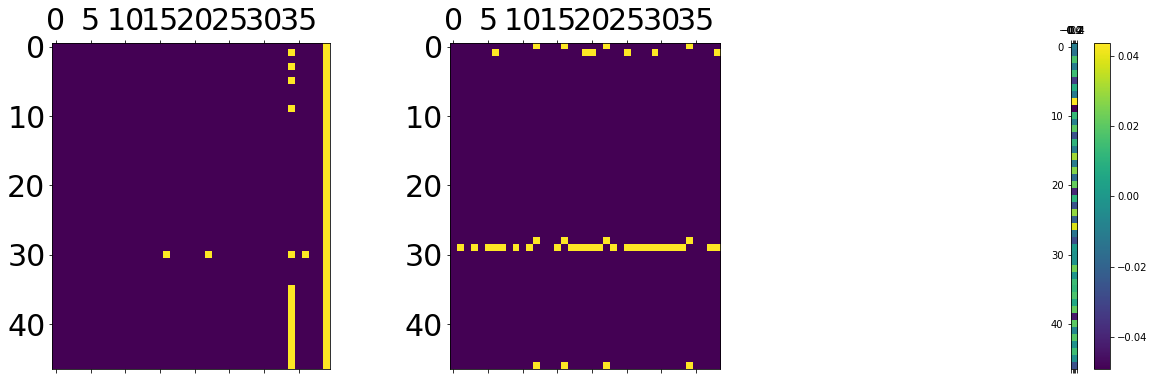

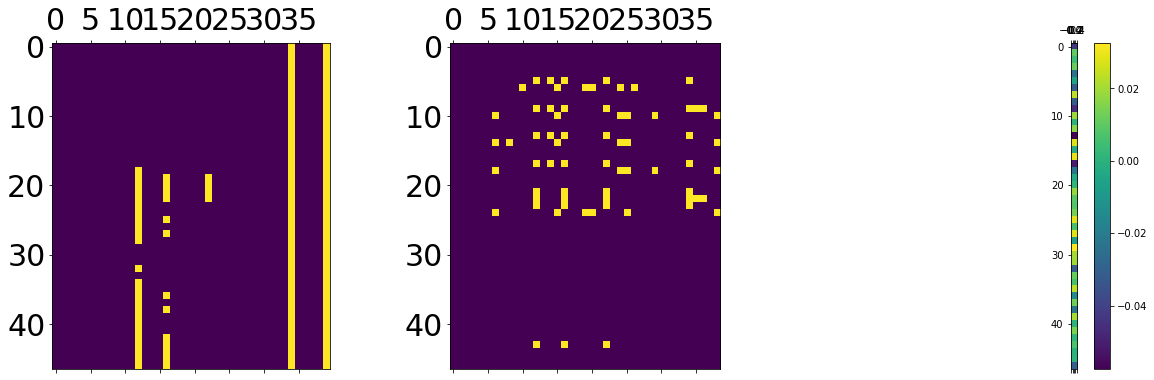

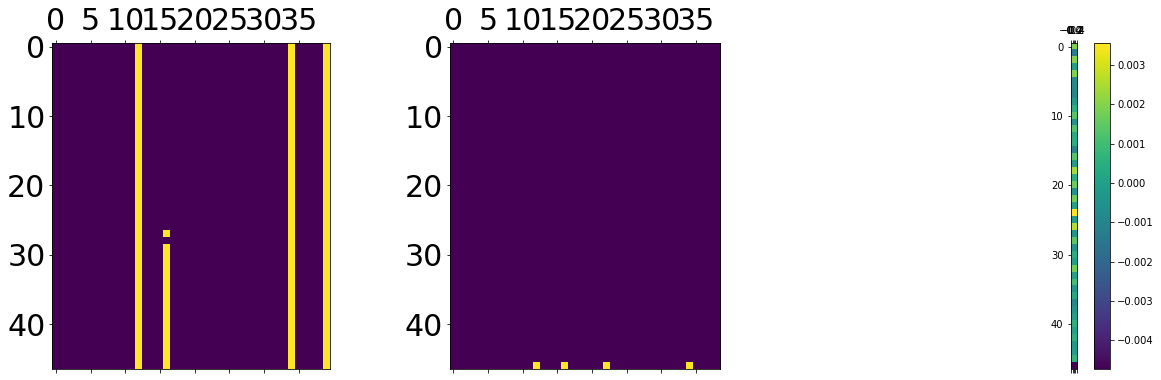

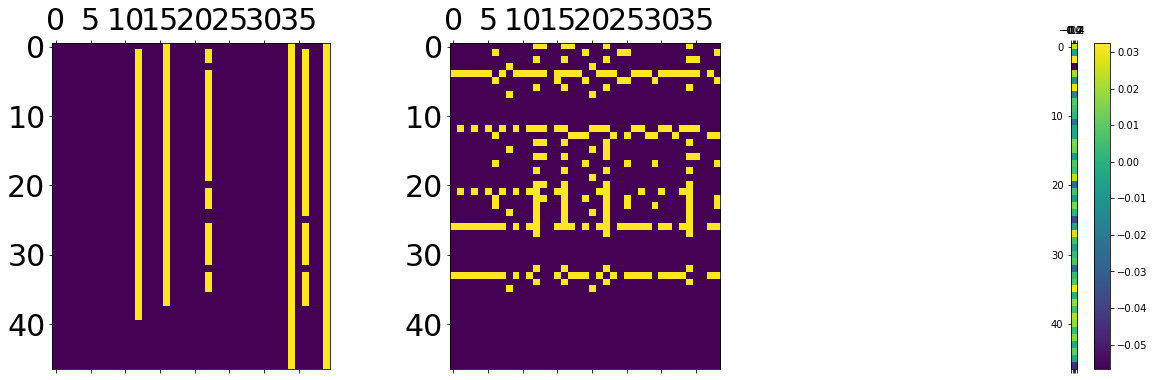

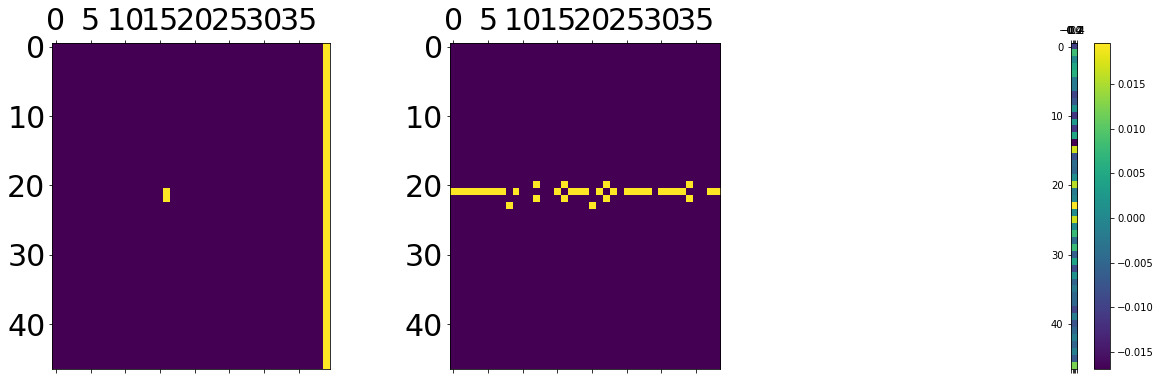

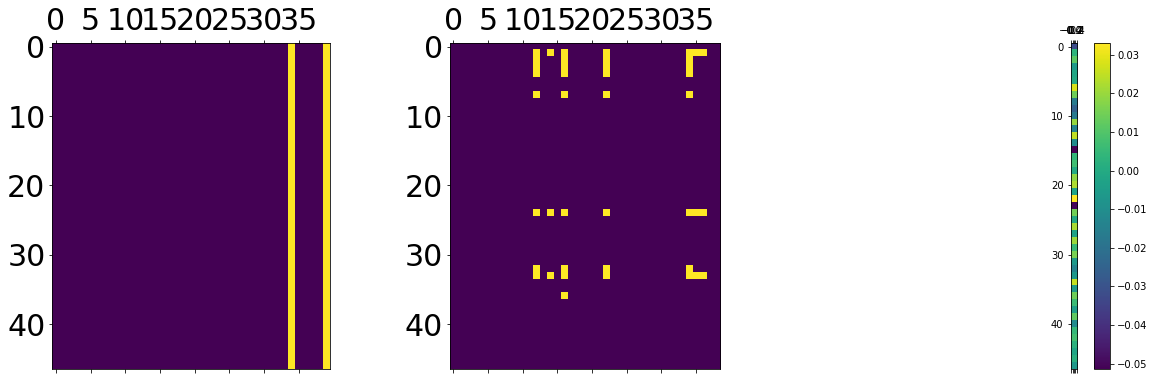

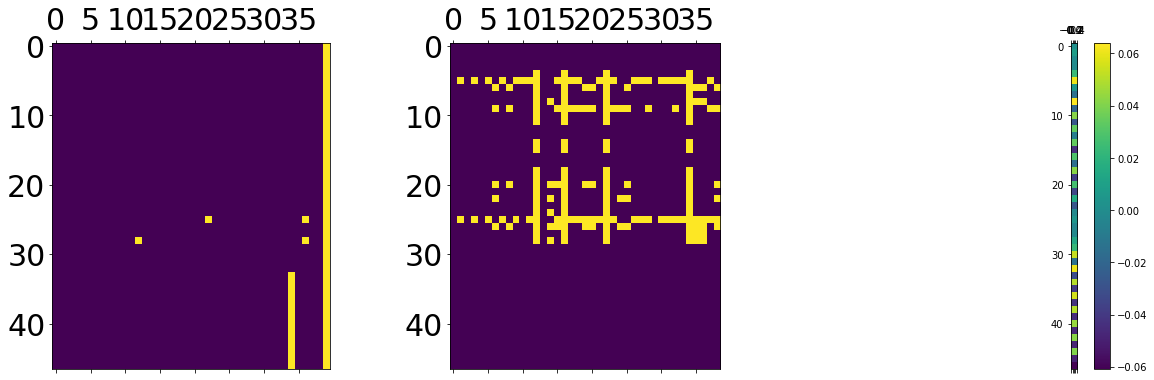

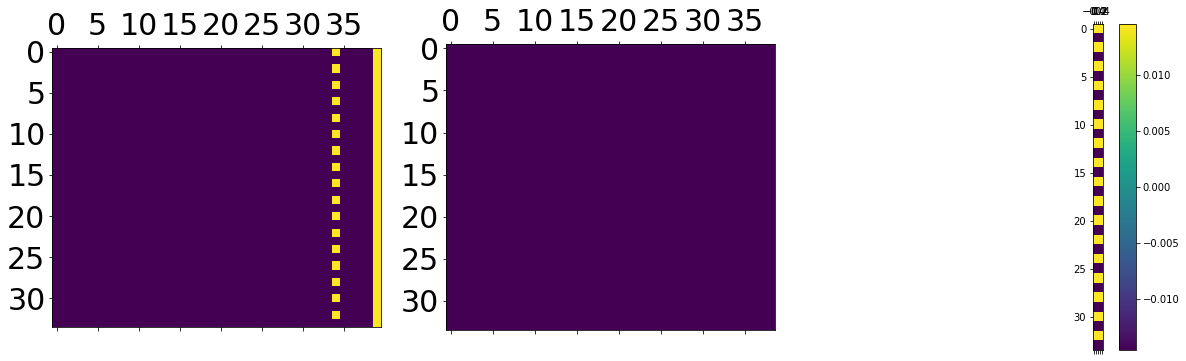

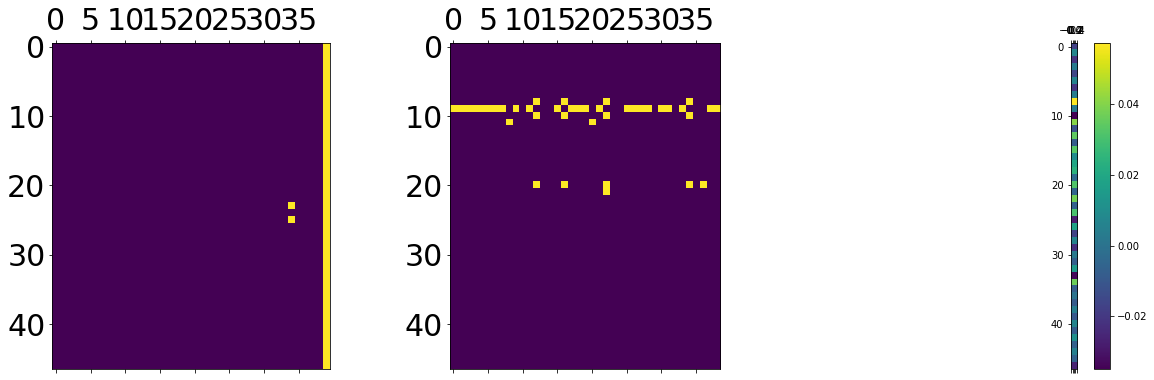

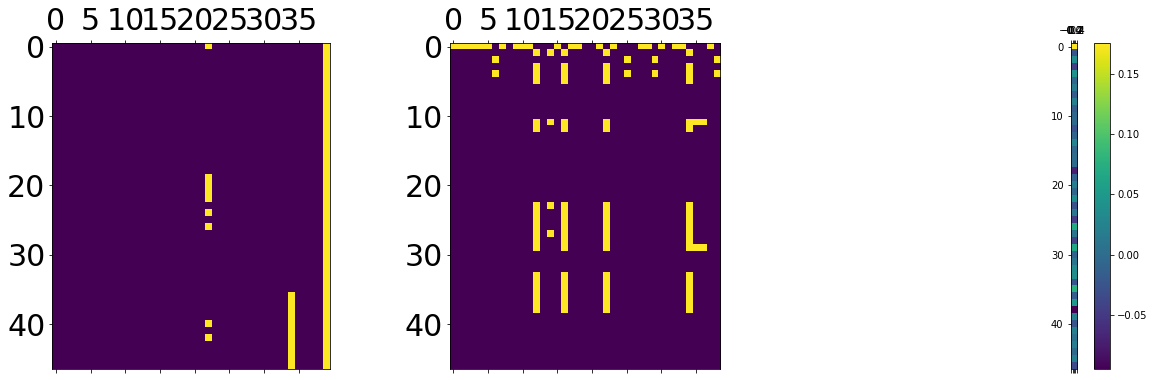

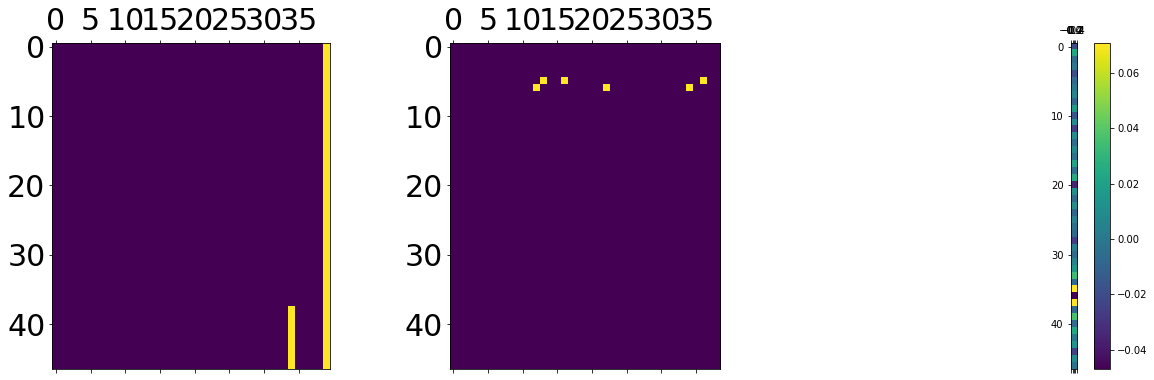

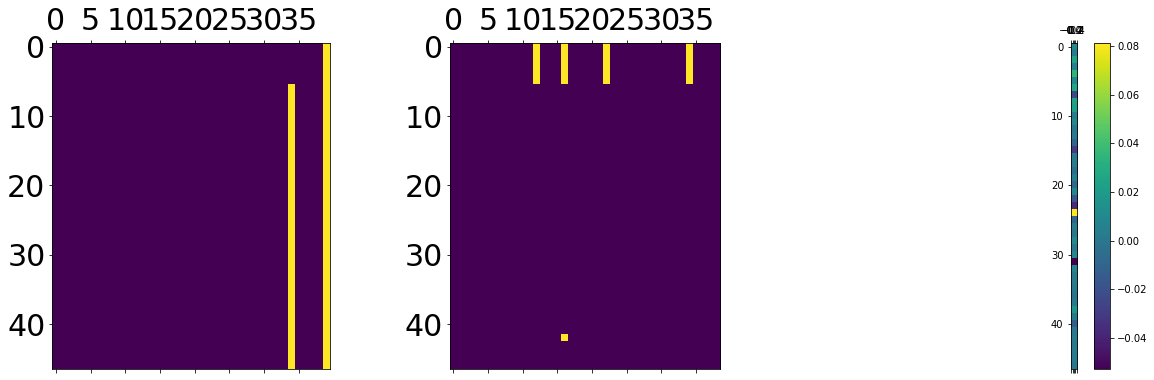

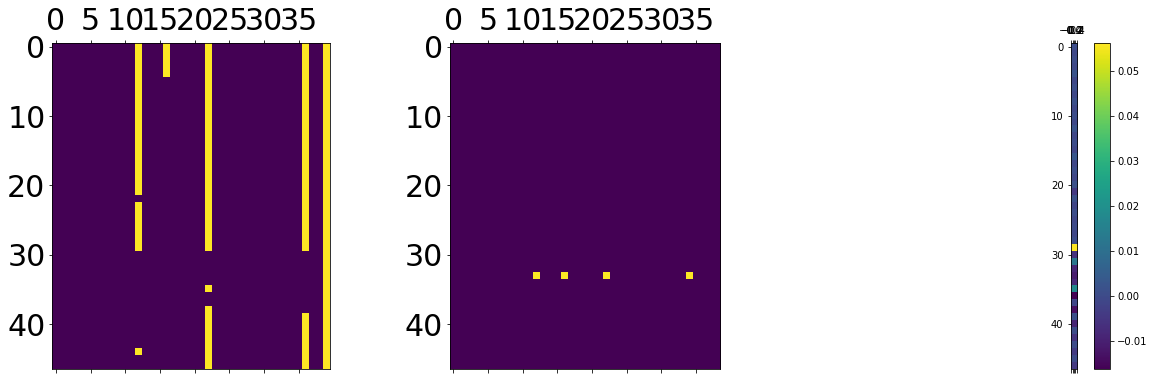

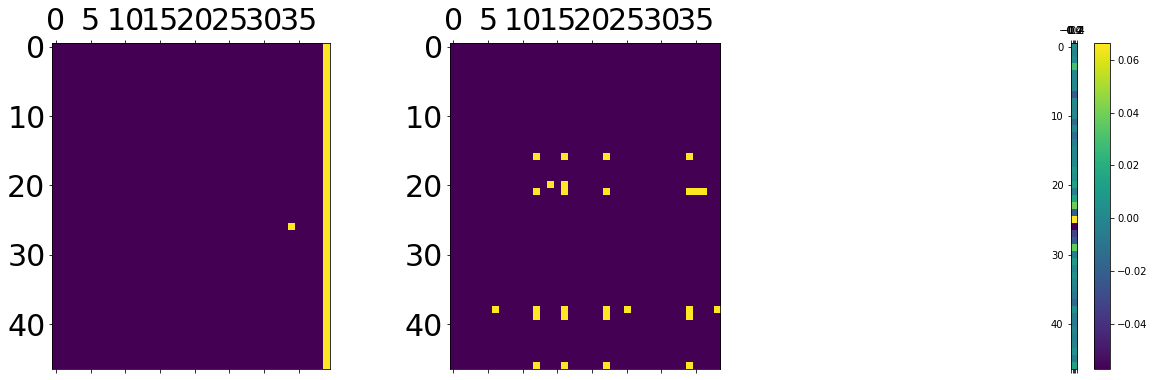

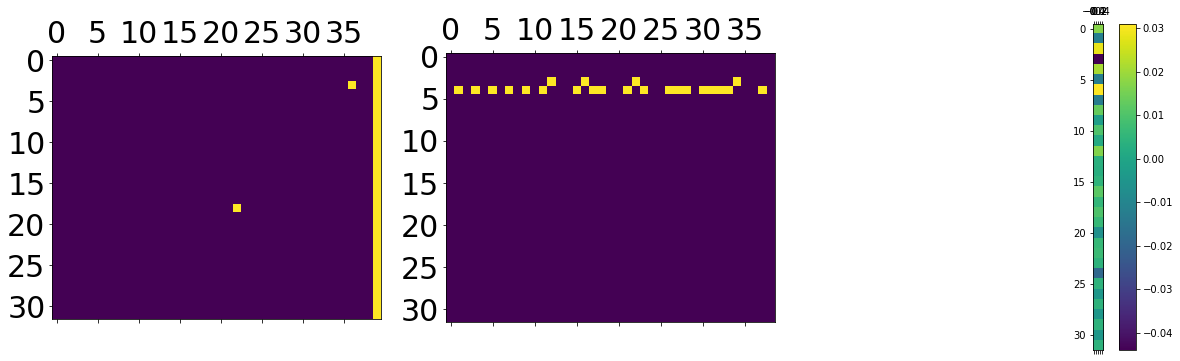

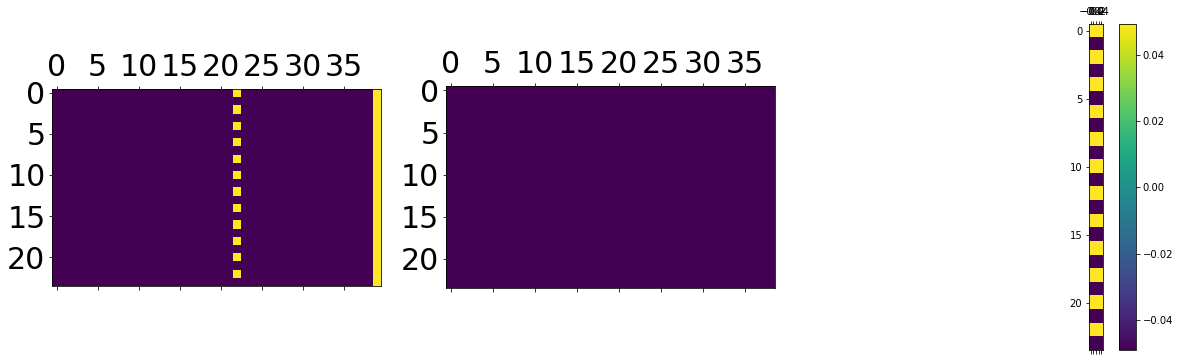

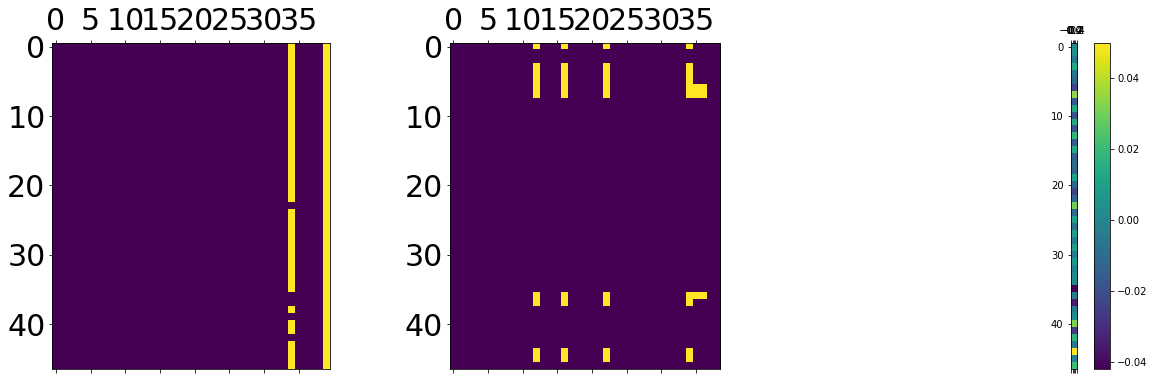

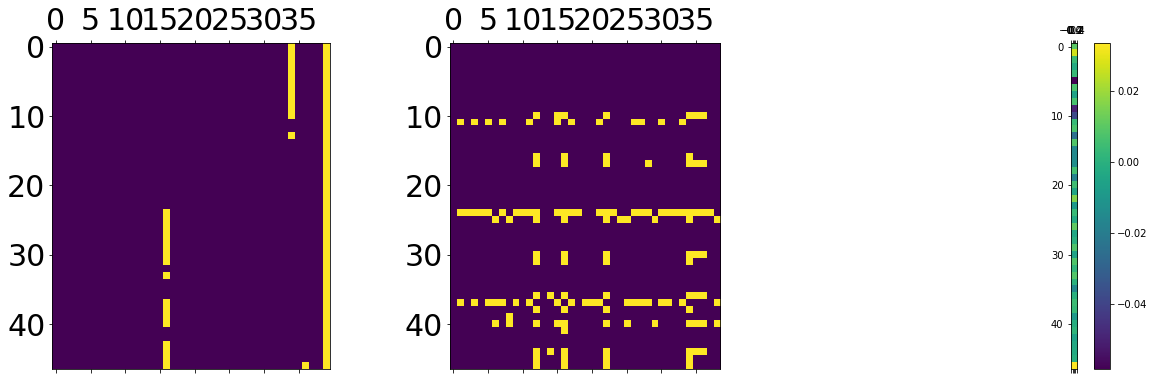

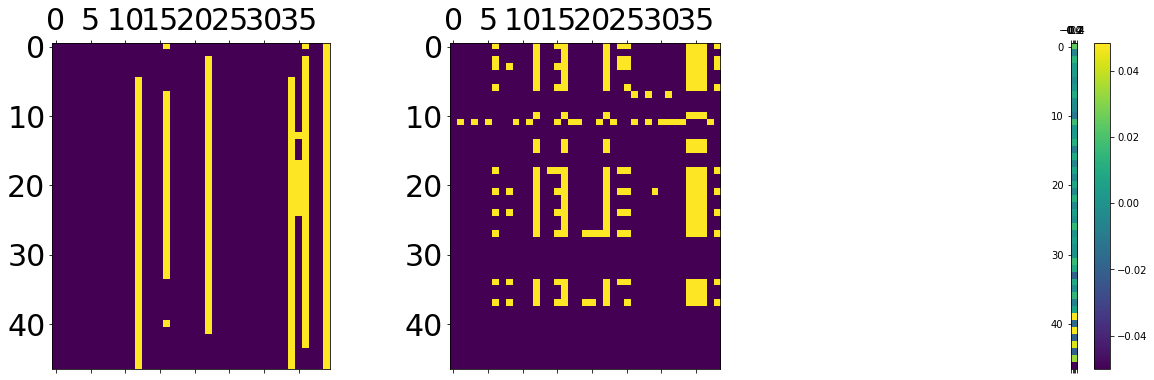

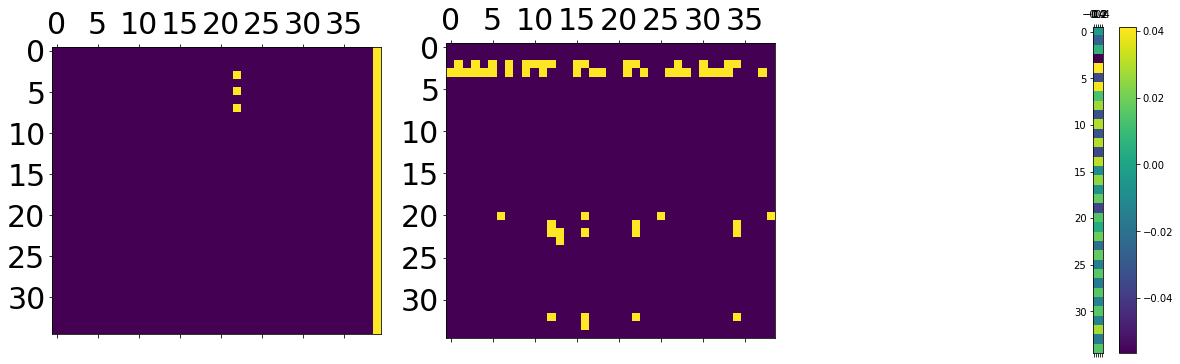

In [17]:
for i in range(20):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    ax[0].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].seq_actions.values))
    ax[1].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].cur_actions.values))
    the_plot = ax[2].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].prob_gain.values))

    plt.colorbar(the_plot, ax=ax[2])

    ax[0].tick_params(axis='both', which='major', labelsize=30)
    ax[1].tick_params(axis='both', which='major', labelsize=30)

    #     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

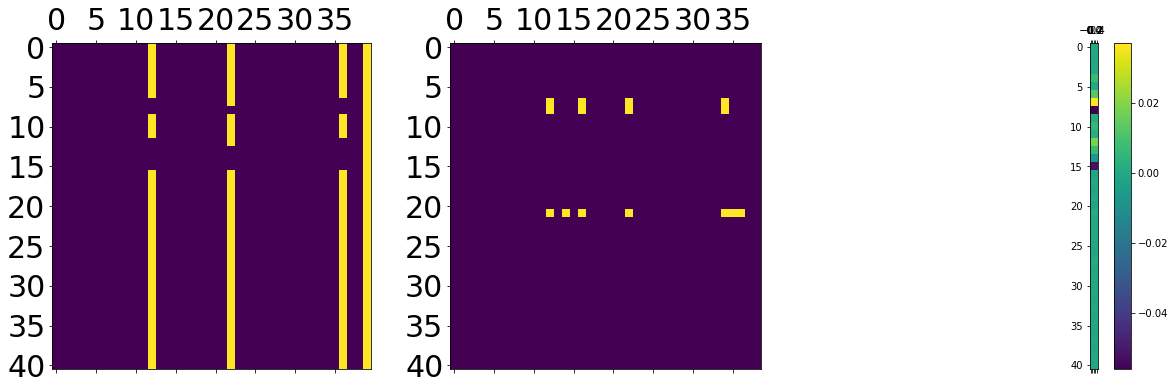

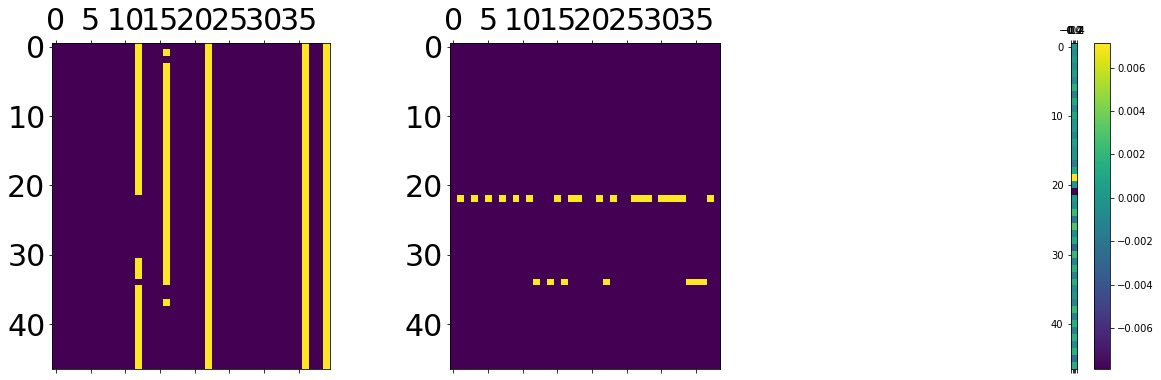

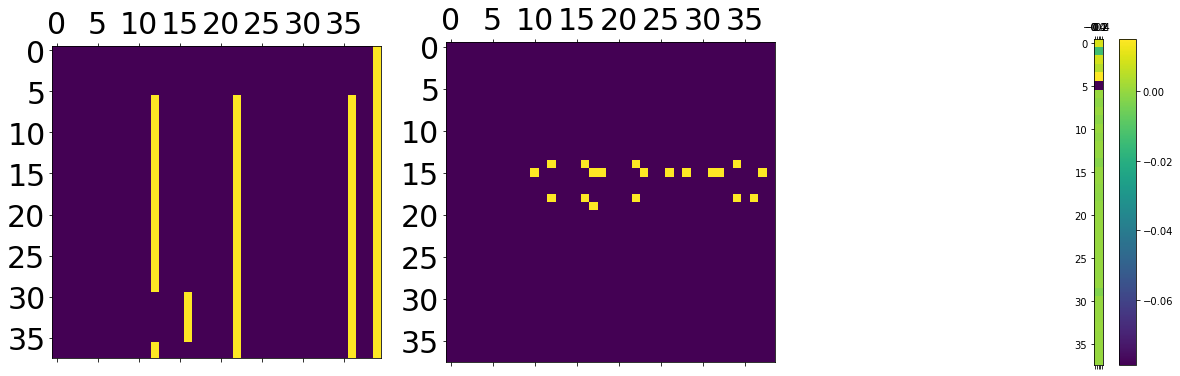

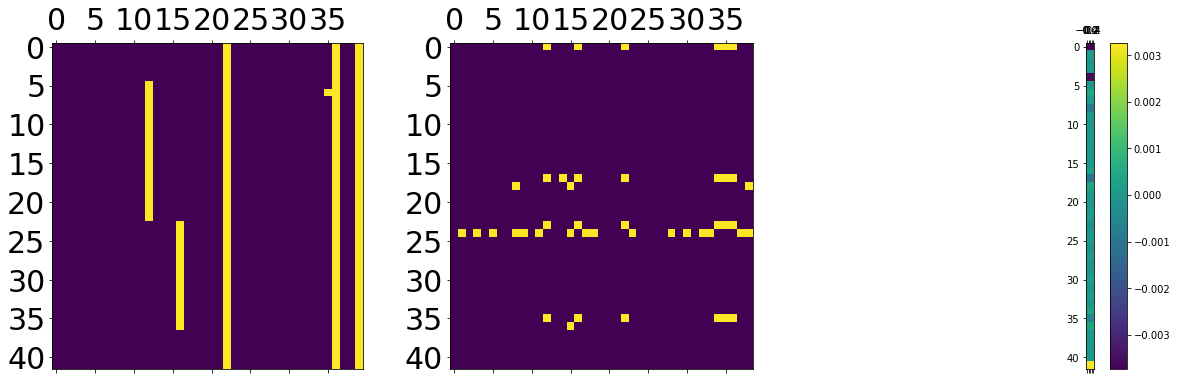

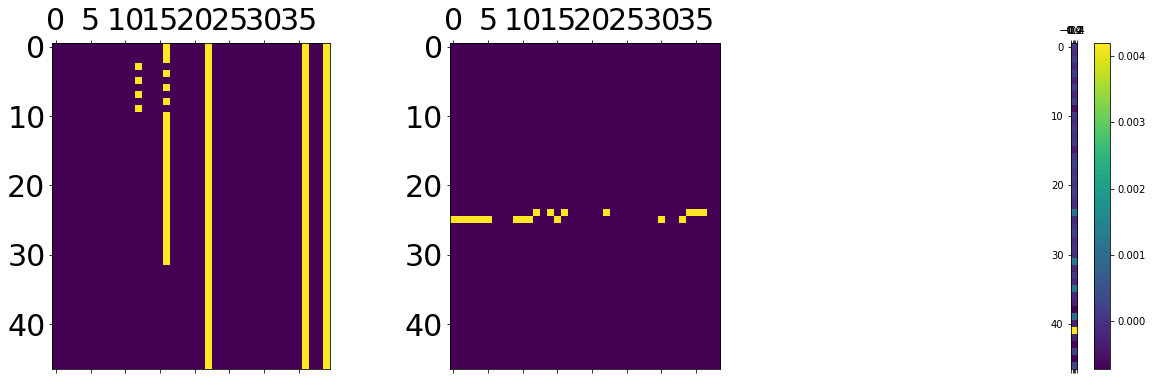

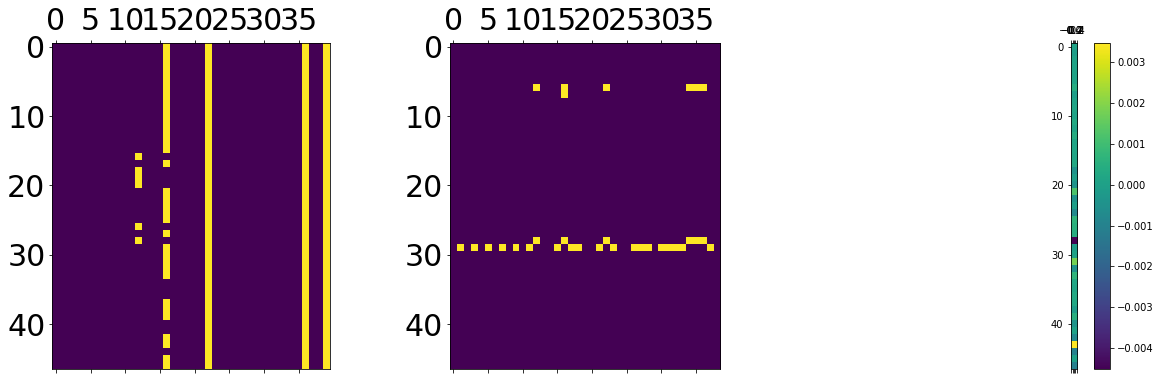

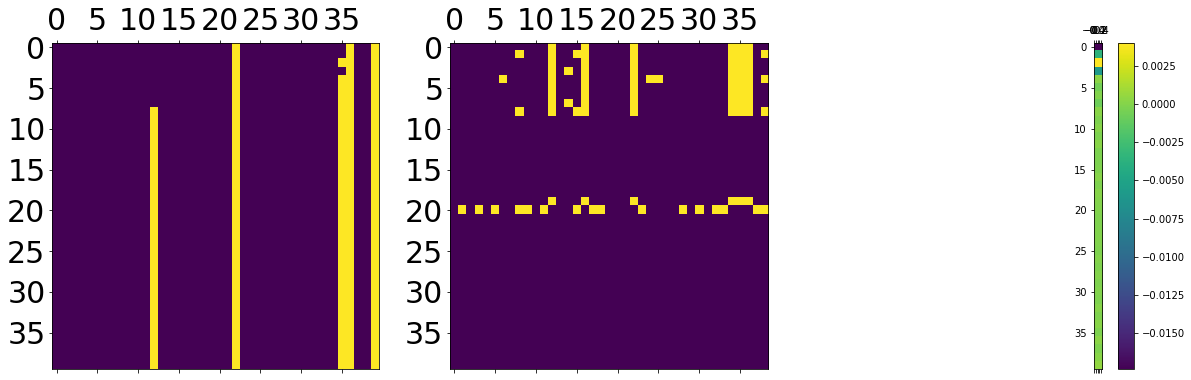

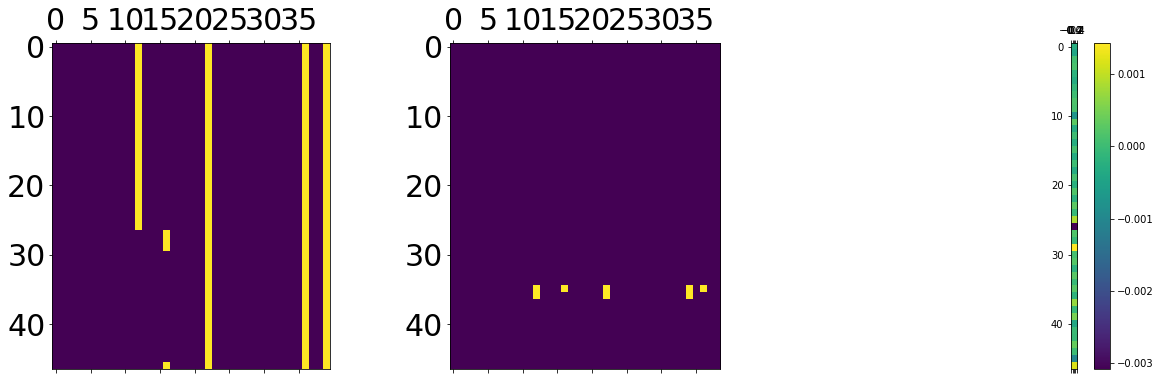

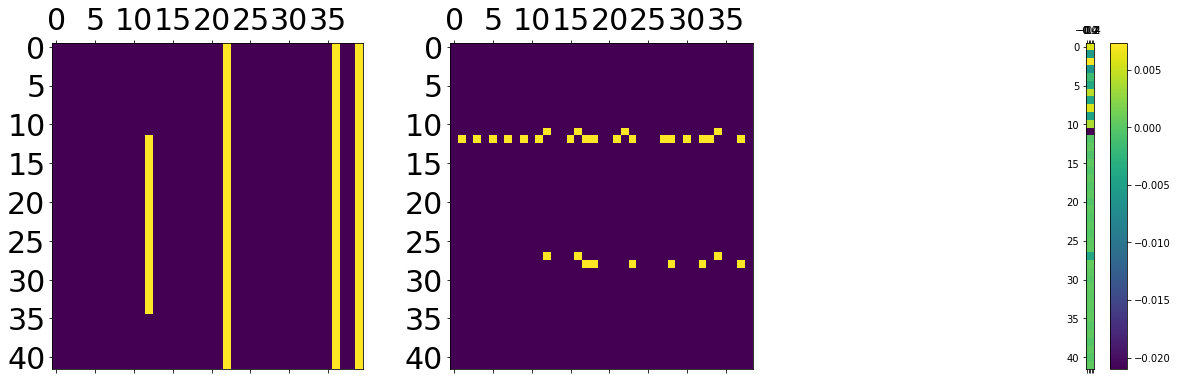

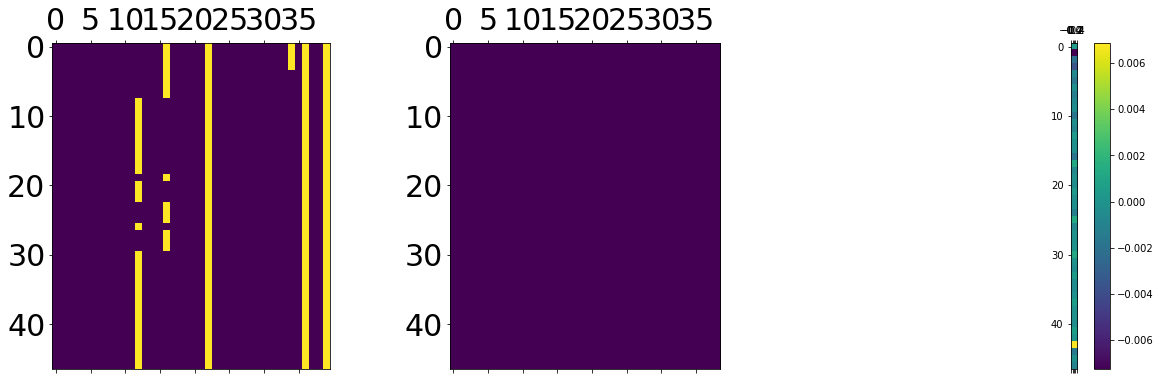

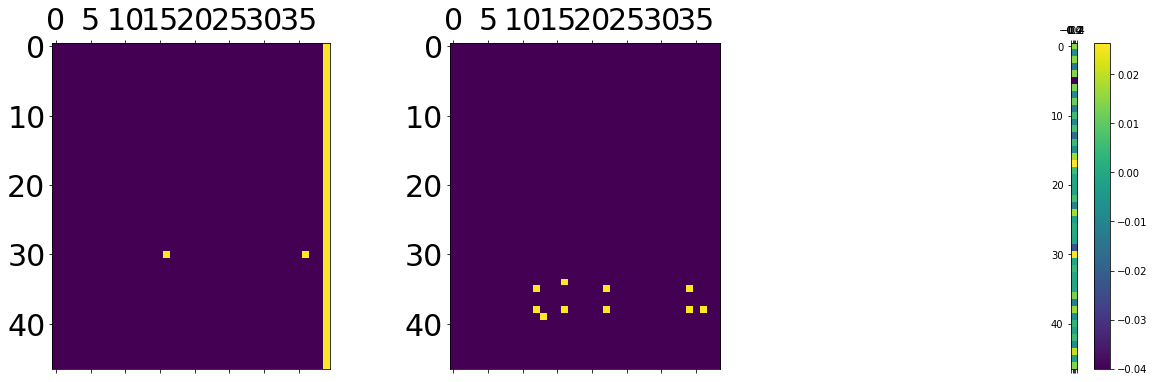

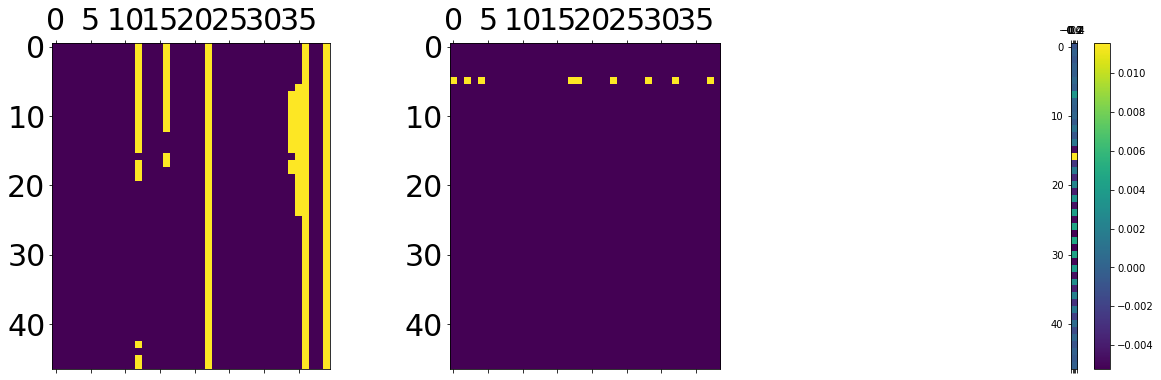

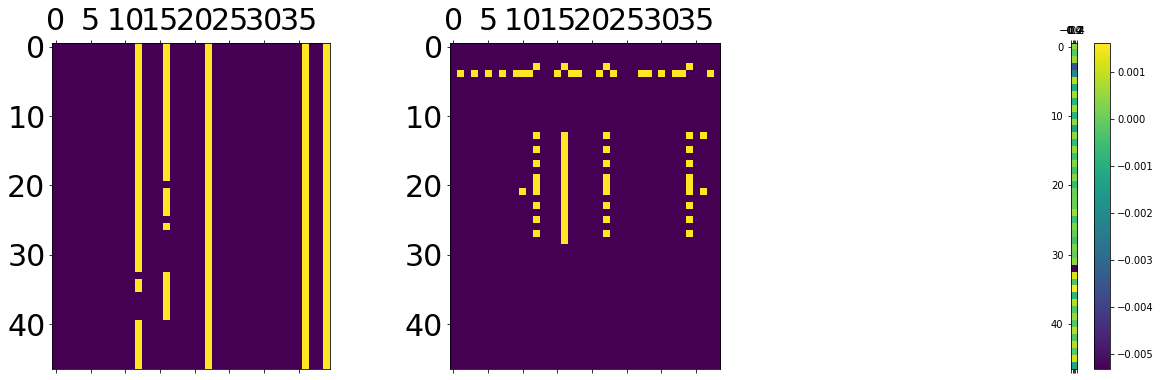

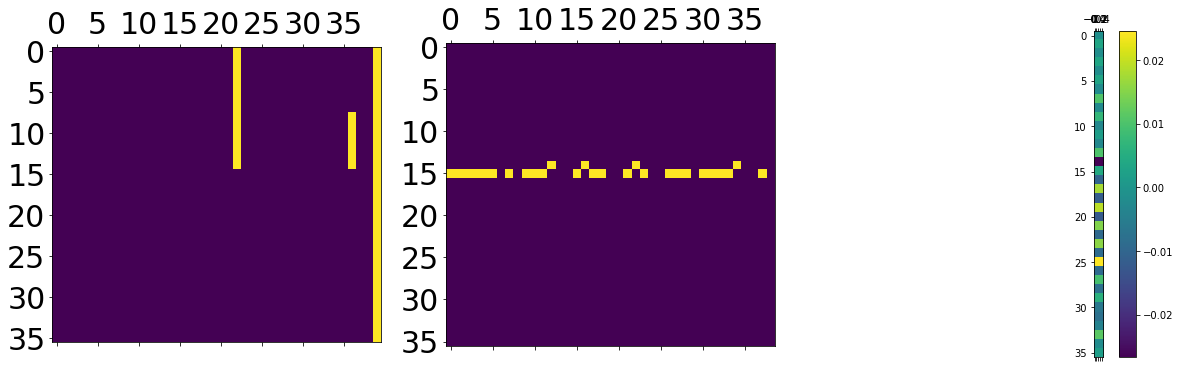

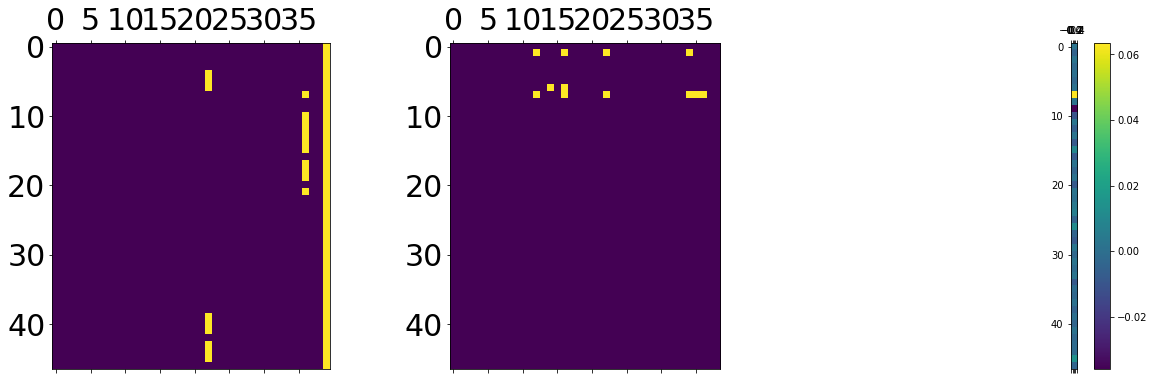

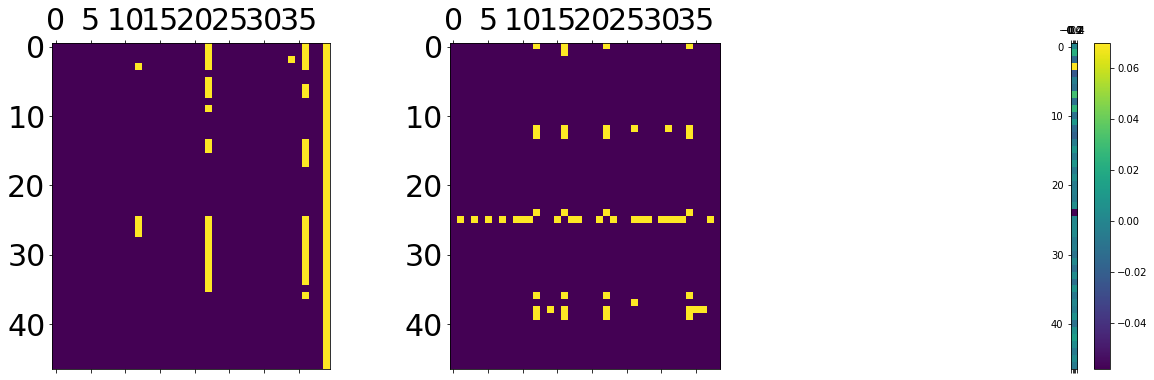

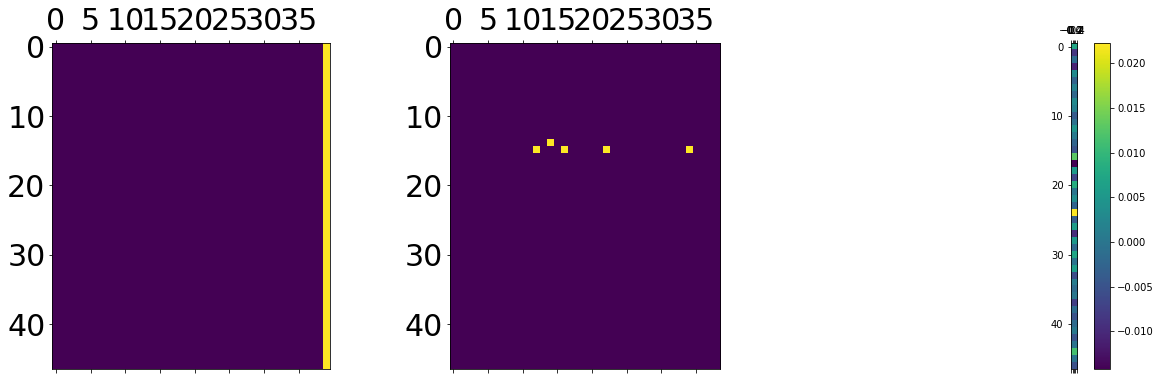

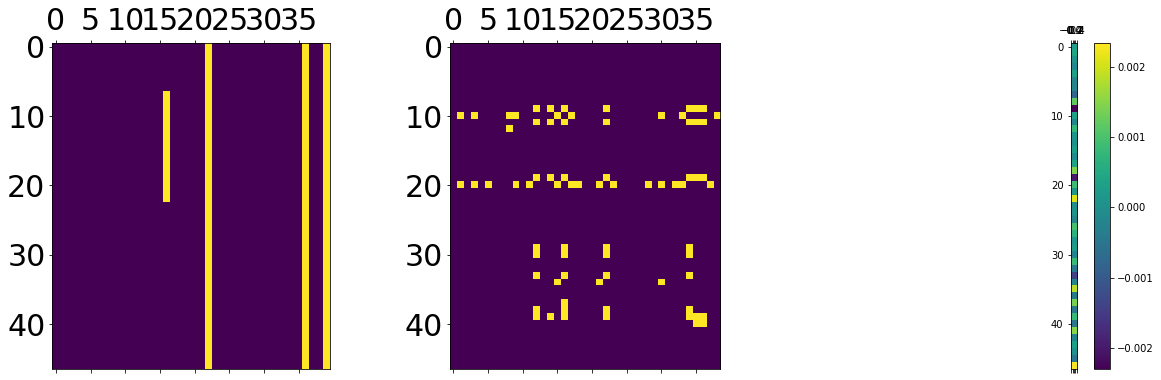

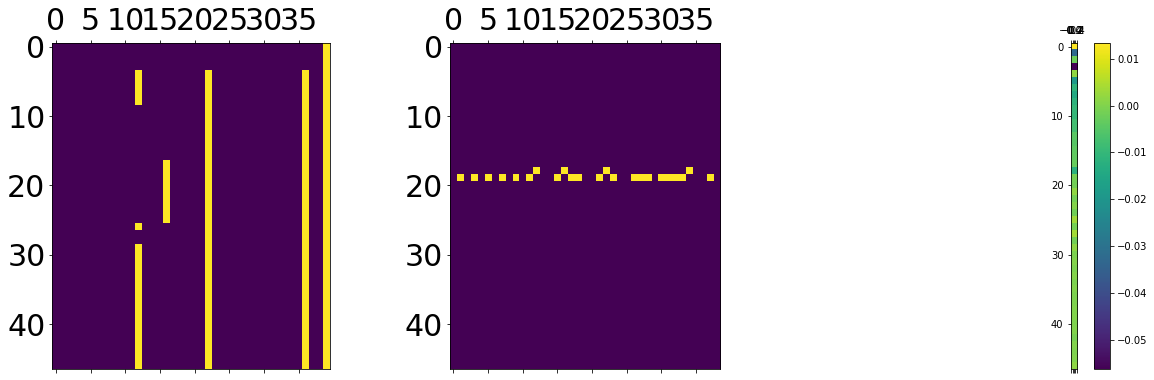

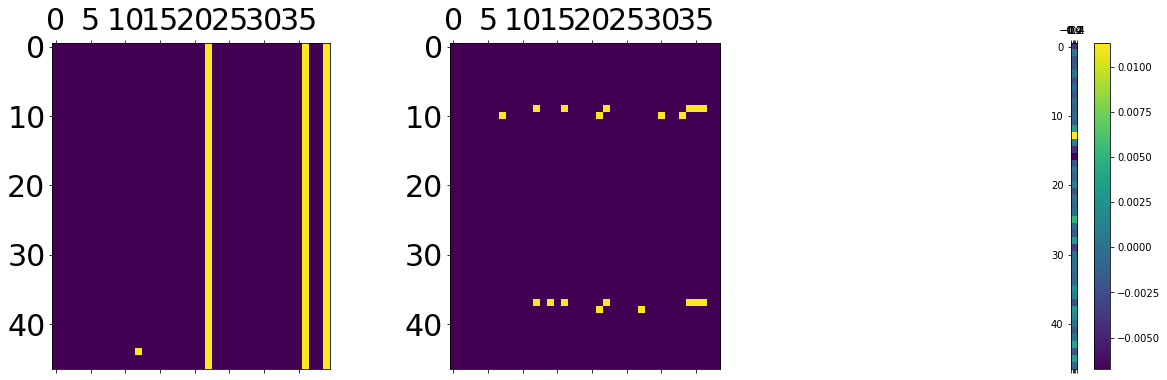

In [18]:
for i in range(20):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    ax[0].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].seq_actions.values))
    ax[1].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].cur_actions.values))
    the_plot = ax[2].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].prob_gain.values))

    plt.colorbar(the_plot, ax=ax[2])

    ax[0].tick_params(axis='both', which='major', labelsize=30)
    ax[1].tick_params(axis='both', which='major', labelsize=30)

    #     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

# Visualization of policy 0118

In [94]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from arch.RewardEstimator import load_model
from policy_training_and_evaluation.run_value_estimator_regression_based import set_up_rl_agent
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [132]:
# Low test loss, good sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-64-lr-0.01-reg-0.01-0.5-s-256-5000-i-50-500-3-1/'
# 1st sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-128-lr-0.01-reg-0.0-0.5-s-256-5000-i-50-500-3-1/'
# 0 action cost for 0108
cache_dir = '../RL_exp_cache/0117-30mins-24hrs-20order-rnn-neg_sampled/'
policy_dir = '../models/dqn_mimic-0118_24hrs_random_order_search-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-32-lr-0.001-reg-0.001-0.7-s-256-5000-i-50-500-3-1'
reward_estimator_dir = '../models/0119_new-StateToStateDiffPerTimeEstimator-0120-hl2-hu128-lr0.001-reg0.001-kp0.7-n1'
rnn_dir = "../models/0117-24hours_39feats_38cov_negsampled_rnn-mimic-nh128-nl2-c1e-07-keeprate0.9_0.7_0.5-npred24-miss1-n_mc_1-MIMIC_window-mingjie_39features_38covs-ManyToOneRNN/"

In [133]:
# Setup the DQN
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.reset_default_graph()
sess = tf.Session(config=config)

dqn = set_up_rl_agent(sess, policy_dir)
rew_estimator = load_model(sess, reward_estimator_dir, rnn_dir=rnn_dir)
test_loader = rew_estimator.get_data_loader(
    mode='test', sess=sess, batch_size=1024)

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0118_24hrs_random_order_search-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-32-lr-0.001-reg-0.001-0.7-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 4
INFO:tensorflow:Restoring parameters from ../models/0119_new-StateToStateDiffPerTimeEstimator-0120-hl2-hu128-lr0.001-reg0.001-kp0.7-n1/model-4
Find model.log ... The best model idx is 5
INFO:tensorflow:Restoring parameters from ../models/0117-24hours_39feats_38cov_negsampled_rnn-mimic-nh128-nl2-c1e-07-keeprate0.9_0.7_0.5-npred24-miss1-n_mc_1-MIMIC_window-mingjie_39features_38covs-ManyToOneRNN/model-5


In [134]:
# collect key value from test experience
# next(test_loader).keys()
# dict_keys(['cur_state', 'next_state', 'cur_obs', 'next_obs', 'cur_actions', 'next_actions',
# 'prob_gain', 'cur_prob', 'next_prob', 'labels', 'patient_inds', 'the_steps', 'total_steps', 'mortality'])
all_keys = [
    'seq_actions', 'patient_inds', 'mortality', 'the_steps', 'cur_actions',
    'prob_gain', 'labels', 'cur_prob', 'pred_agent_prob_gain',
    'pred_phy_prob_gain'
]
result = {k: [] for k in all_keys}
for idx, exp in enumerate(test_loader):
    exp['seq_actions'] = dqn.get_best_sequential_actions(
        sess=sess, cur_state=exp['cur_state'])[:, :-1]
    exp['pred_agent_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp, agent_a=exp['seq_actions'])
    exp['pred_phy_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp)
    for k in all_keys:
        result[k].append(exp[k])

In [135]:
for k in all_keys:
    result[k] = np.concatenate(result[k], axis=0)
    if result[k].ndim > 1:
        result[k] = result[k].tolist()

In [136]:
df = pd.DataFrame(result)

In [137]:
df.shape

(272575, 10)

In [138]:
df.head(10)

seq_actions  patient_inds  mortality  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...             1          0   

   the_steps                                        cur_actions  prob_gain  \
0          1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.011571   
1          2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.000099   
2          3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.000099   
3          4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.000099   
4          5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.004873   
5          6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.000121   
6          7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.006211   
7          8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.010347   
8          9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.020772   
9         10  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.001407   

   labels  cur_prob  pred_agent_prob_gain  pred_phy_prob_gain  
0       0  0.413971             -0.002191            0.000205  
1       0  0.425542             -0.001998            0.000184  
2       0  0.425641             -0.001995            0.000184  
3       0  0.425542             -0.001998            0.000184  
4       0  0.425641             -0.001995            0.000184  
5       0  0.430514             -0.001846            0.000207  
6       0  0.430635             -0.001840            0.000207  
7       0  0.436846             -0.001613           -0.000523  
8       0  0.447193             -0.001471           -0.000428  
9       0  0.426421             -0.001894            0.000198

In [139]:
np.vstack(df[df.patient_inds == 1].seq_actions.values).shape

(41, 39)

In [140]:
np.vstack(df[df.patient_inds == 1].seq_actions.values)[0, :]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0.])

In [141]:
np.vstack(df[df.patient_inds == 1].prob_gain.values).shape

(41, 1)

## Compare physician and agent policy in dead and alive patient

In [142]:
mortality_pat_inds = df[df.mortality ==
                        1].patient_inds.unique()  # dead patient ids
alive_pat_inds = df[df.mortality ==
                    0].patient_inds.unique()  # live patient ids

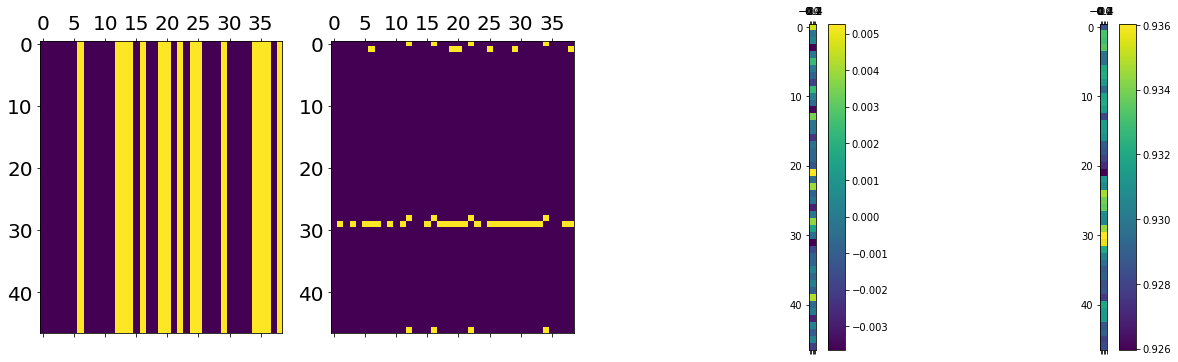

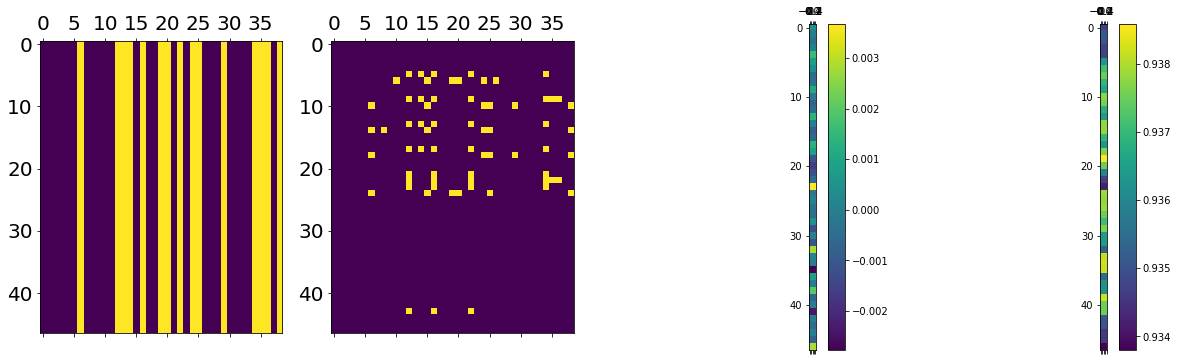

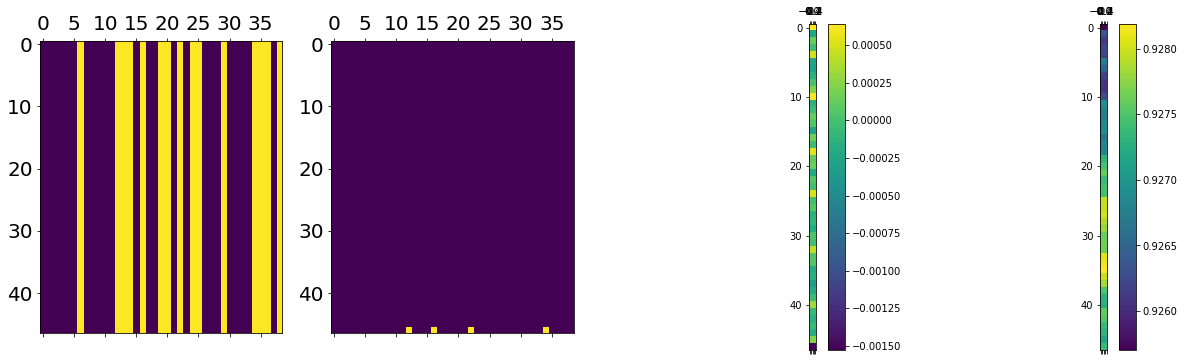

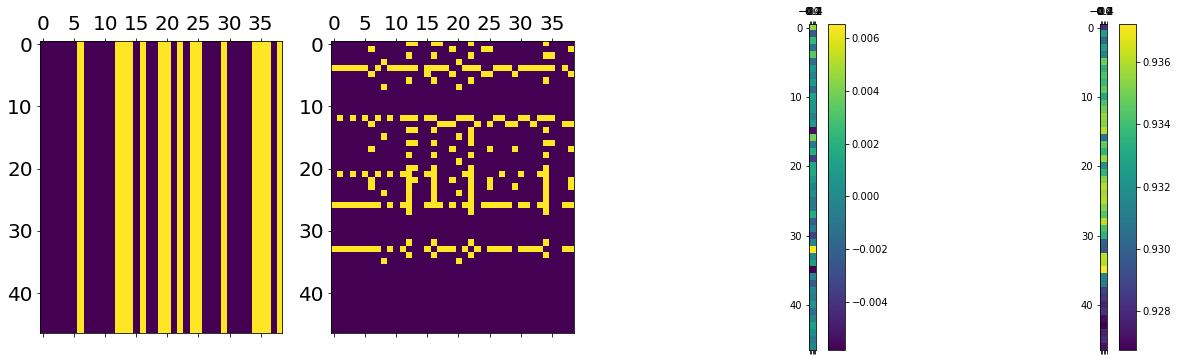

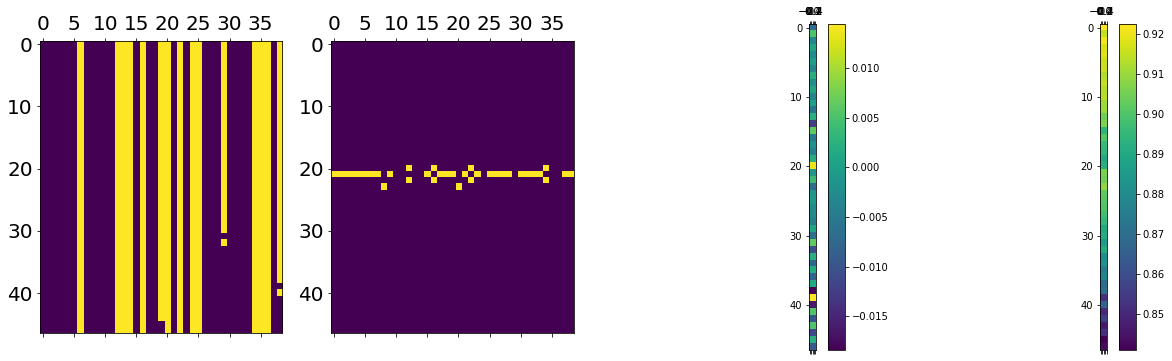

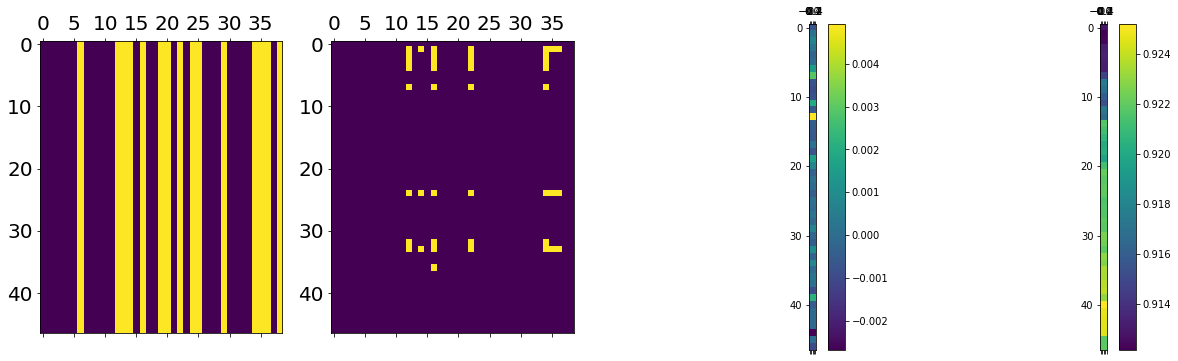

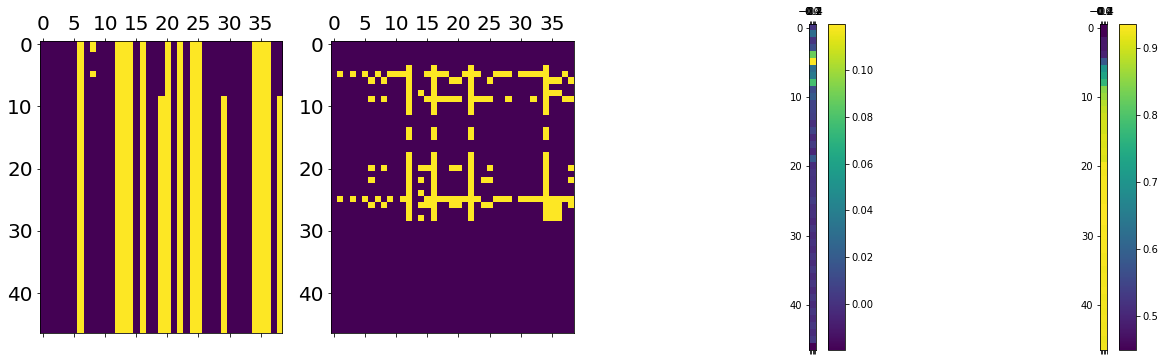

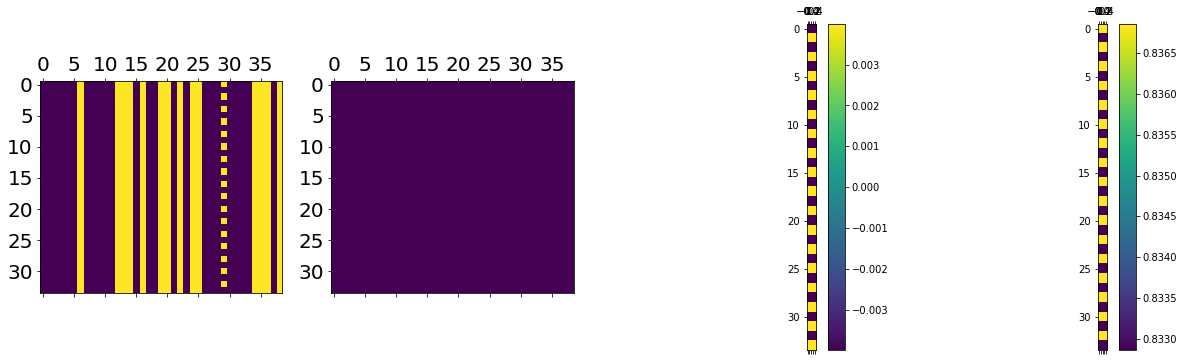

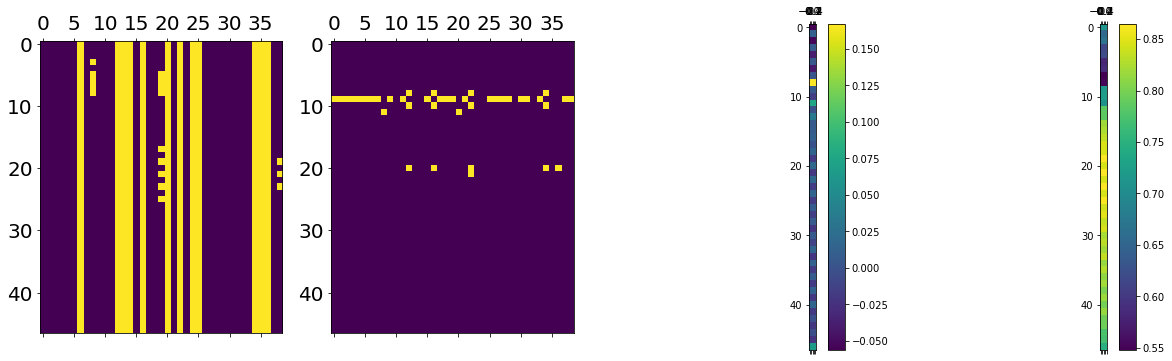

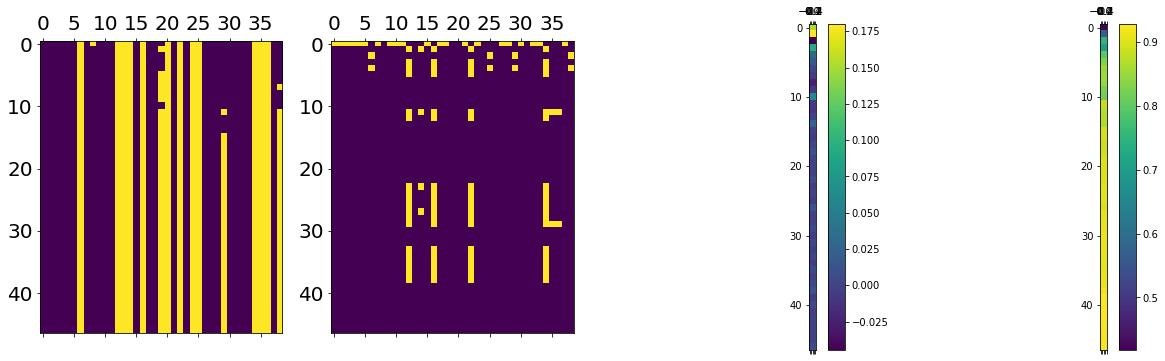

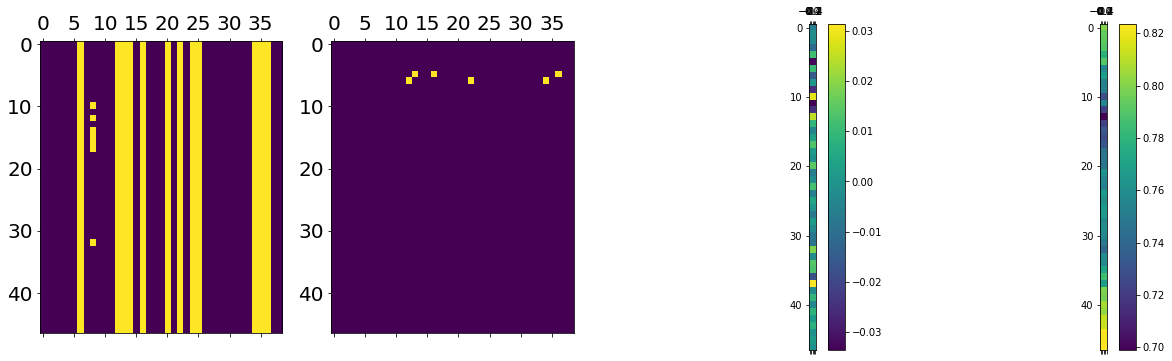

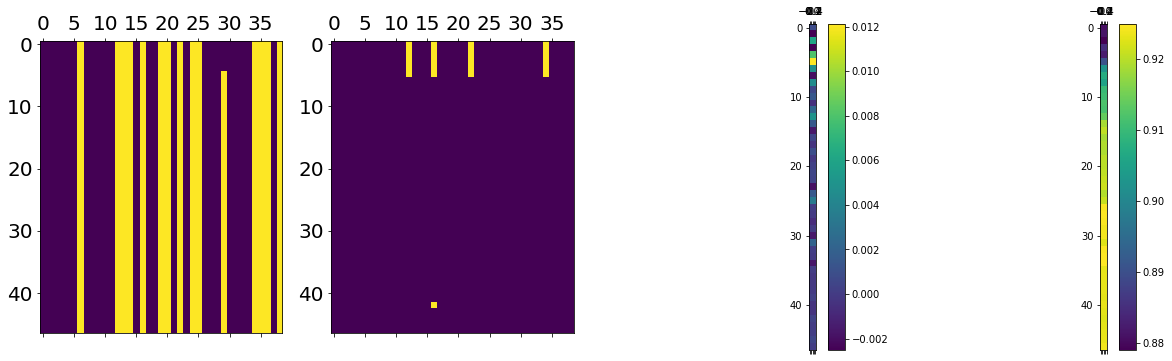

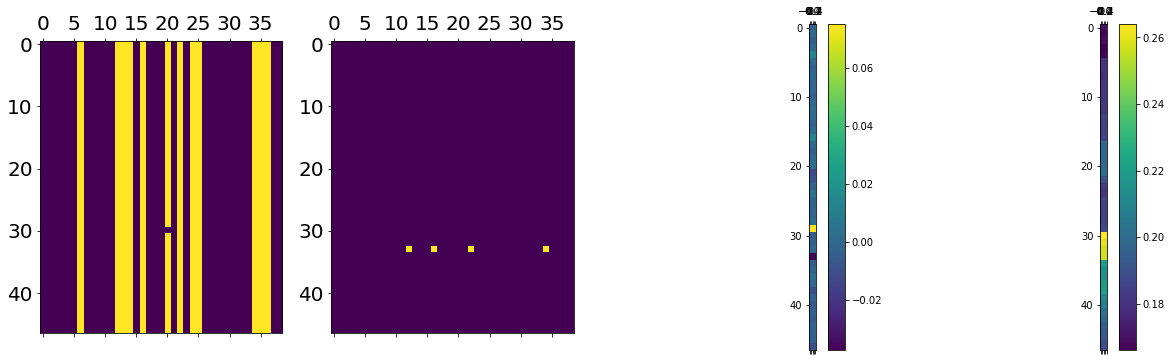

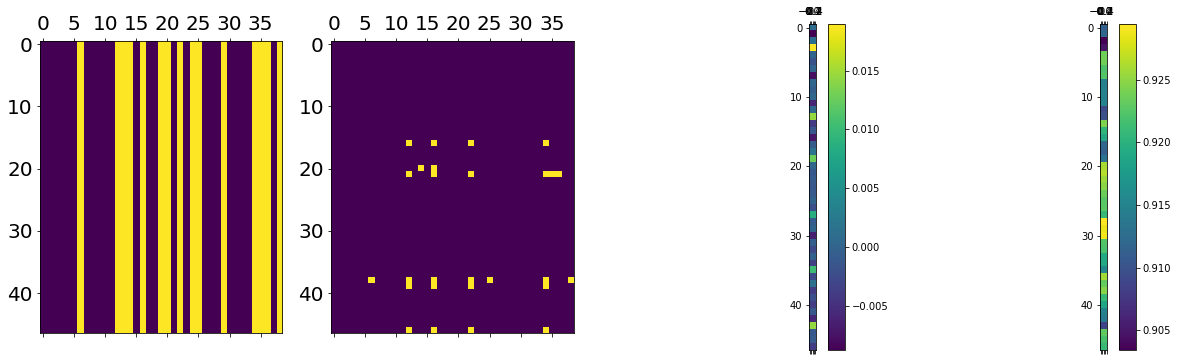

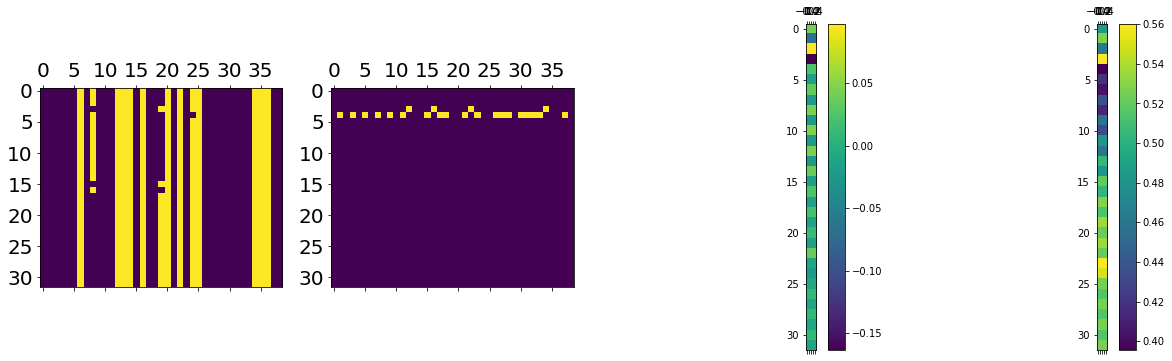

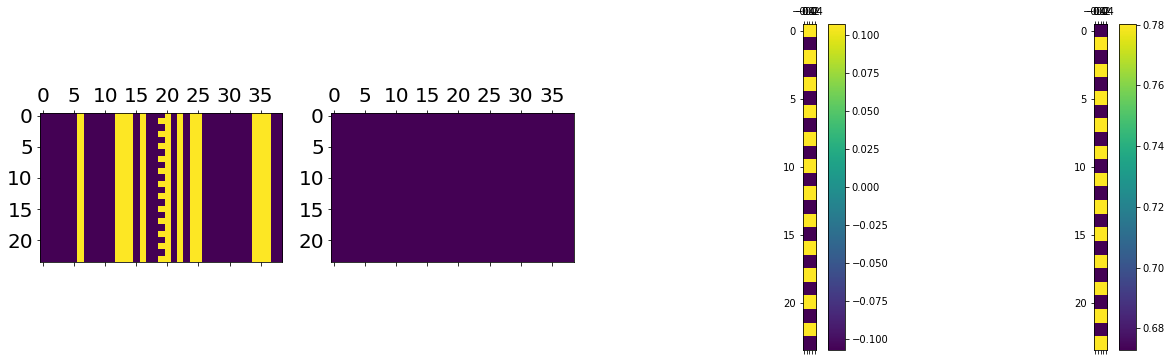

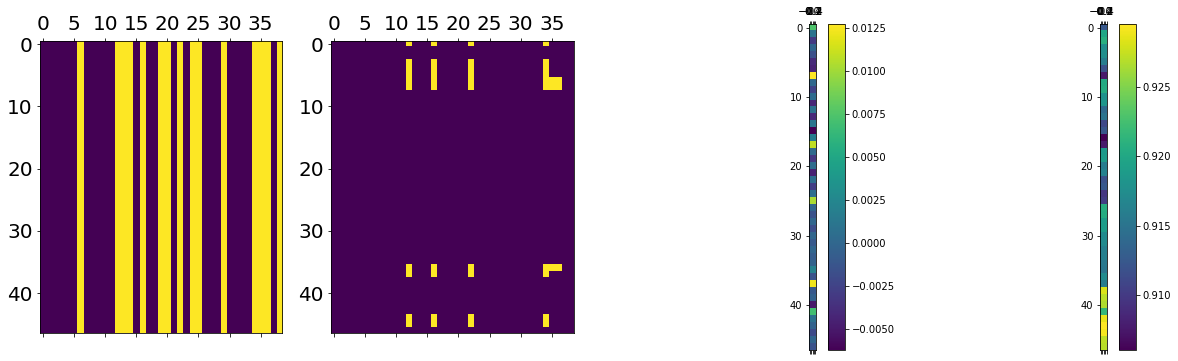

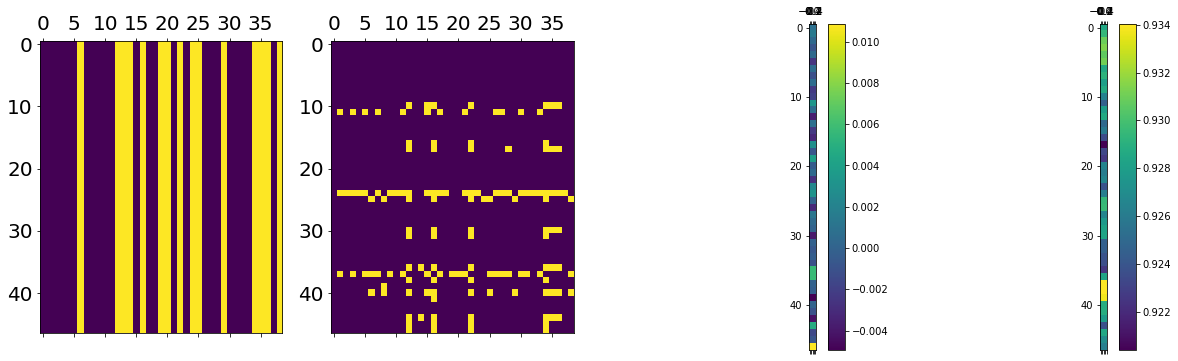

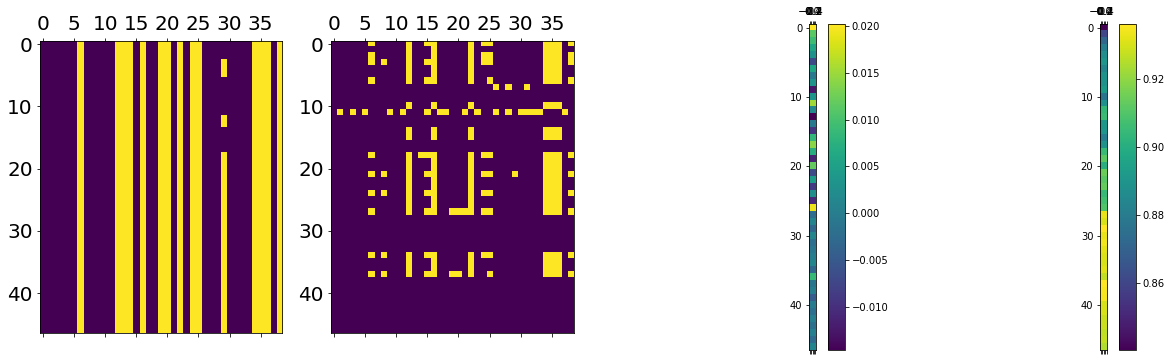

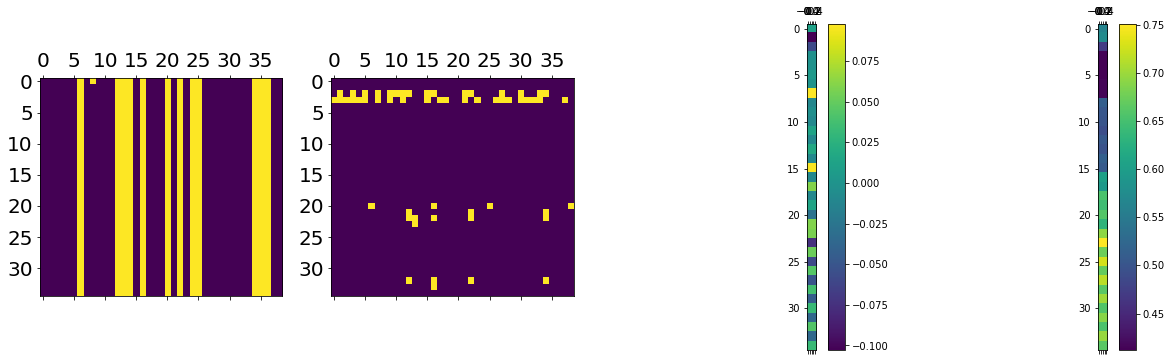

In [143]:
# visualize agent action and physician action for first n dead patients
for i in range(20):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))
    # agent policy
    ax[0].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].seq_actions.values))
    # phy policy
    ax[1].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].cur_actions.values))
    # probability gain
    the_plot = ax[2].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].prob_gain.values))

    plt.colorbar(the_plot, ax=ax[2])
    # cur probability
    the_plot = ax[3].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].cur_prob.values))

    plt.colorbar(the_plot, ax=ax[3])

    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=20)

    #     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

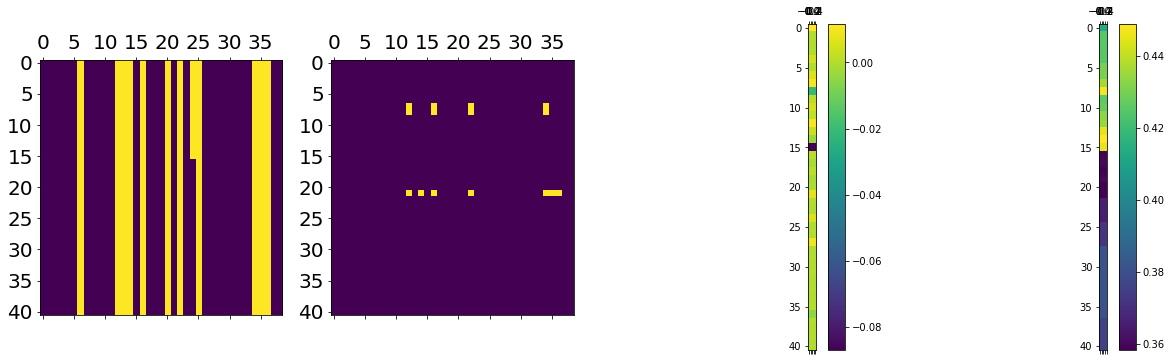

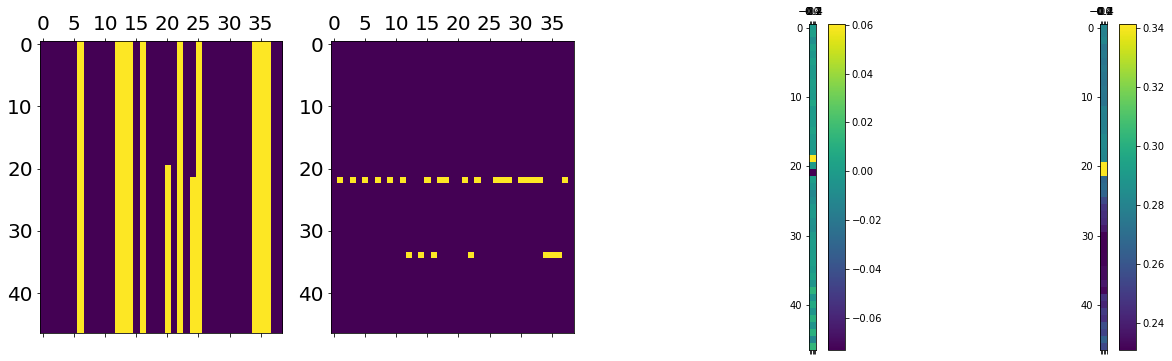

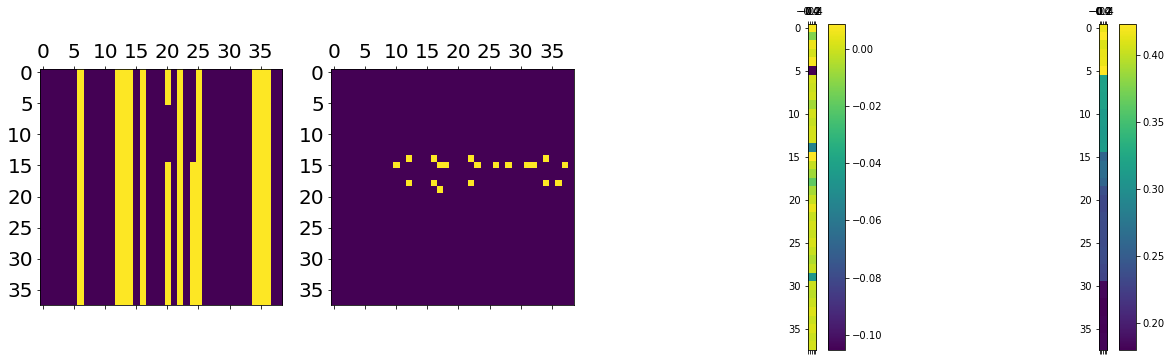

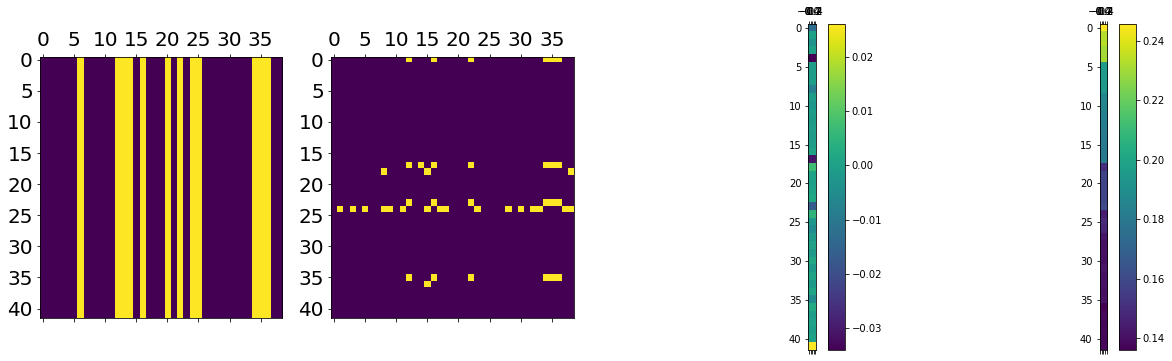

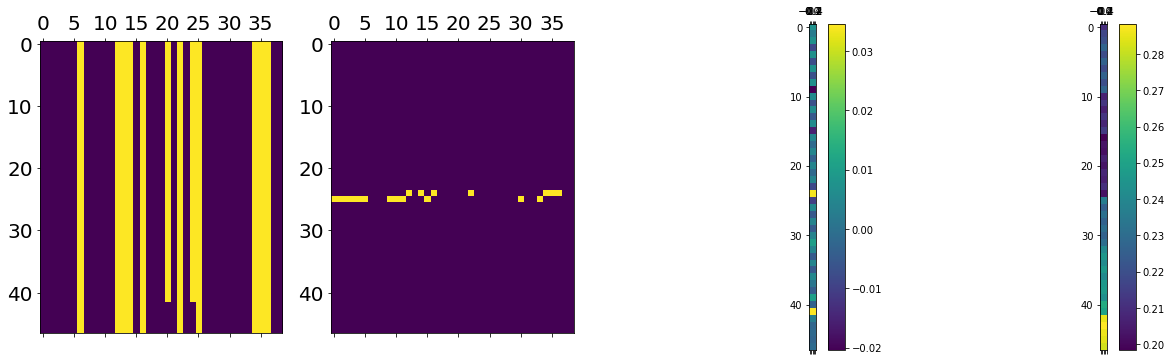

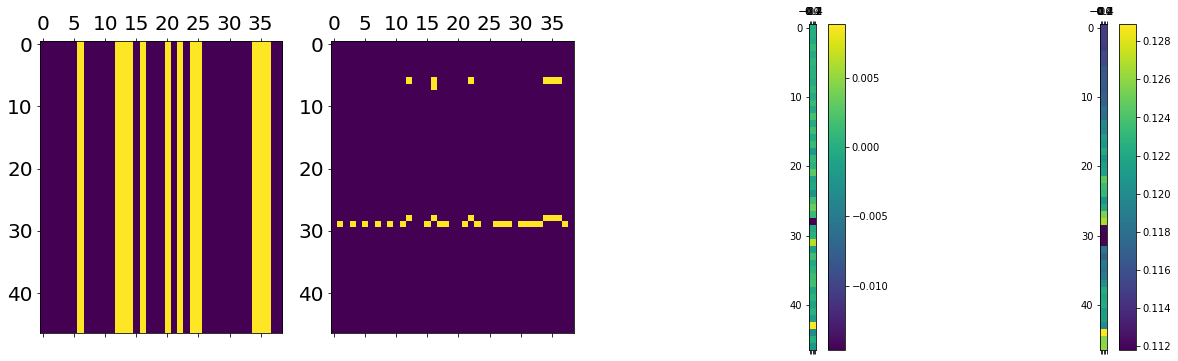

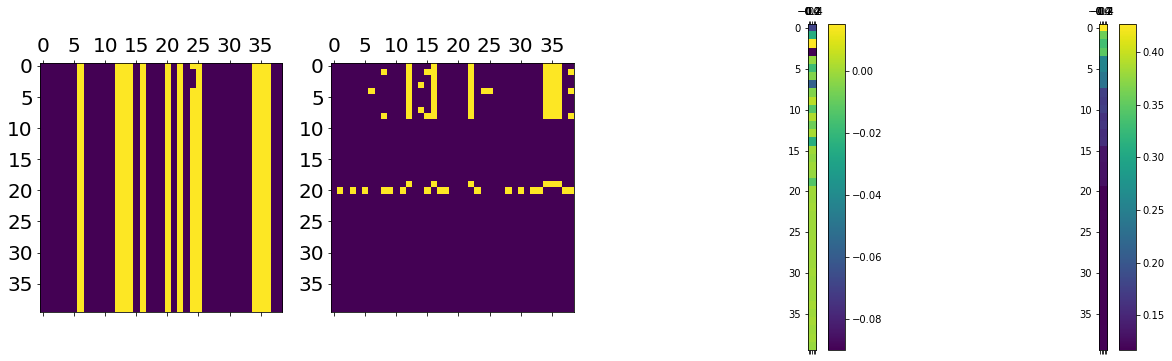

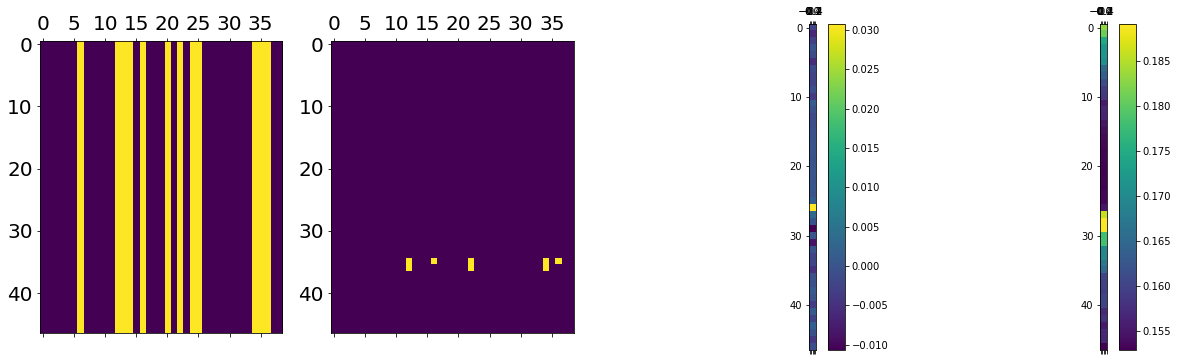

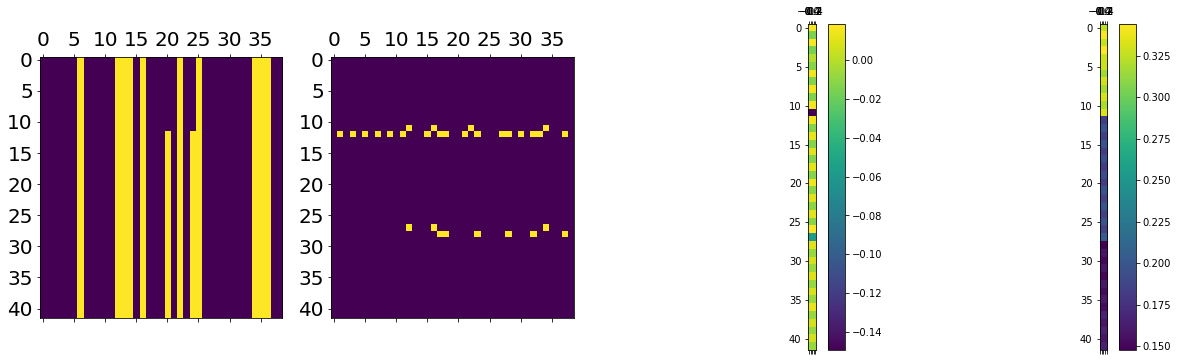

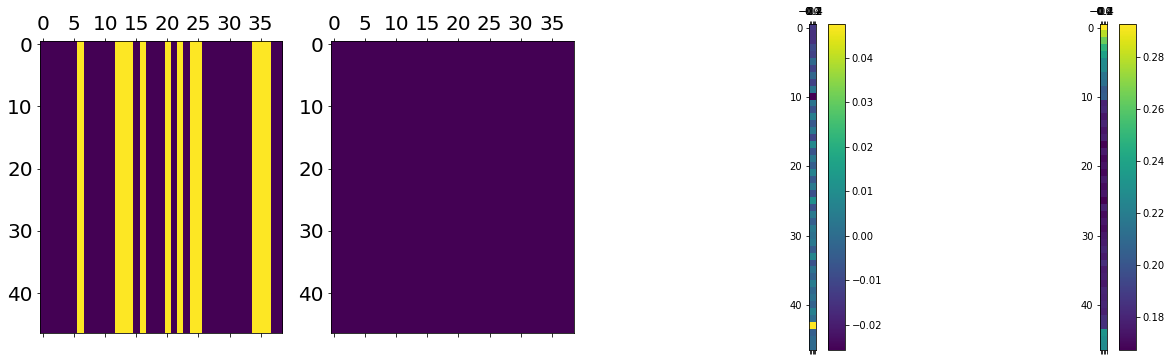

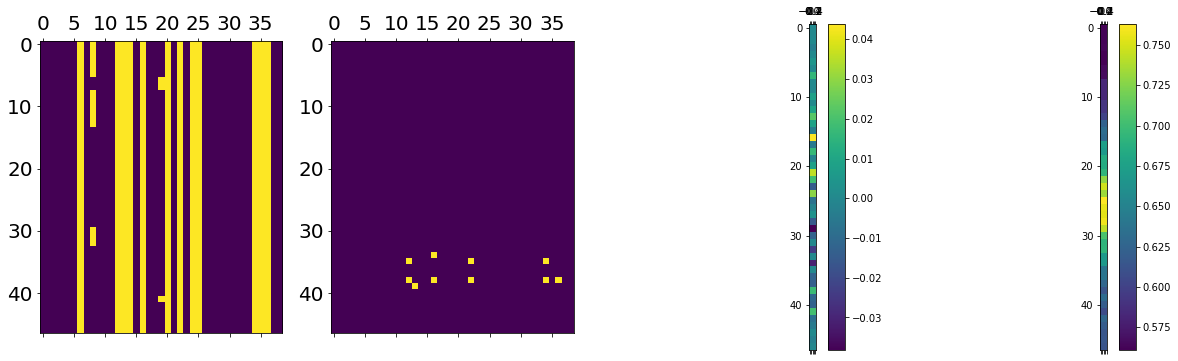

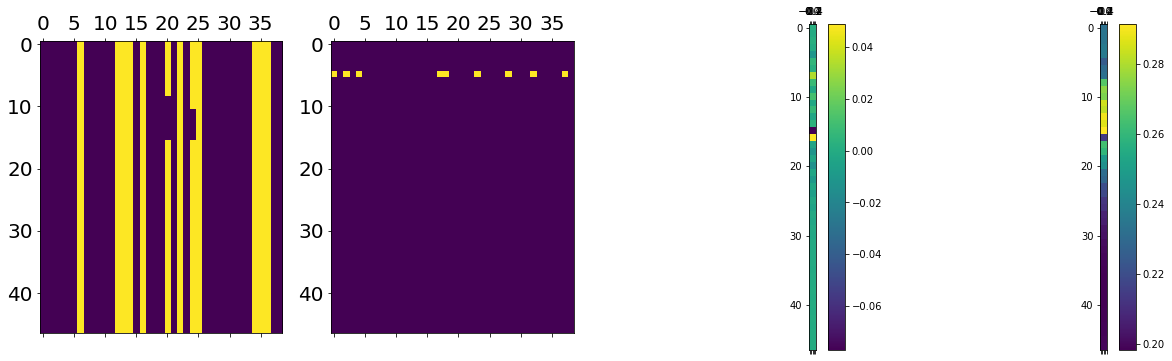

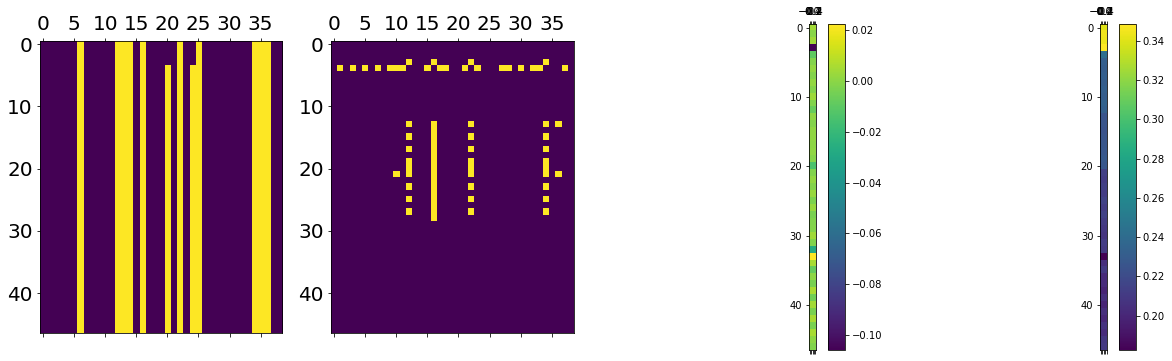

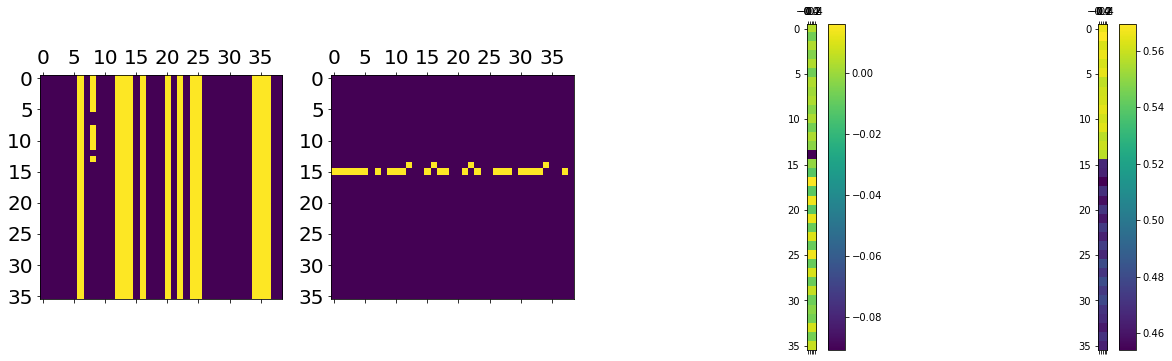

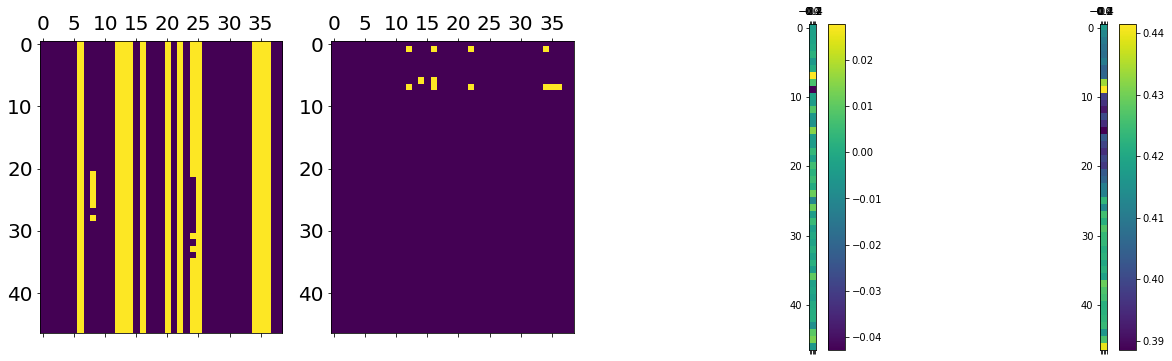

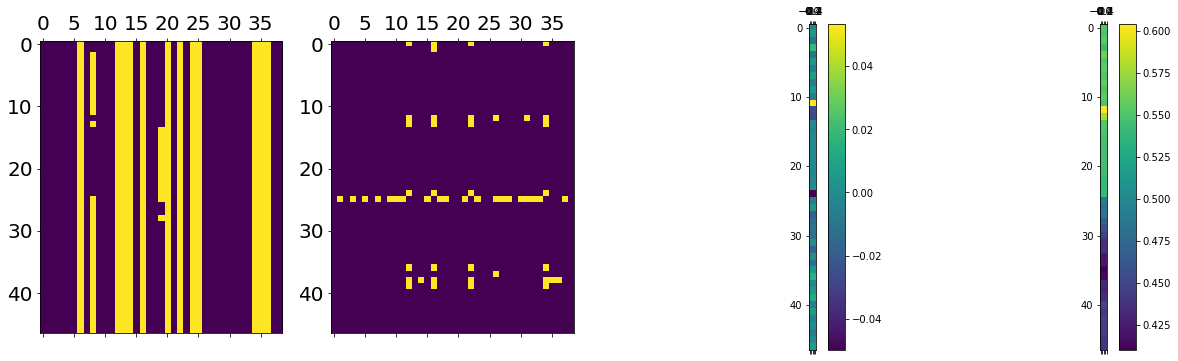

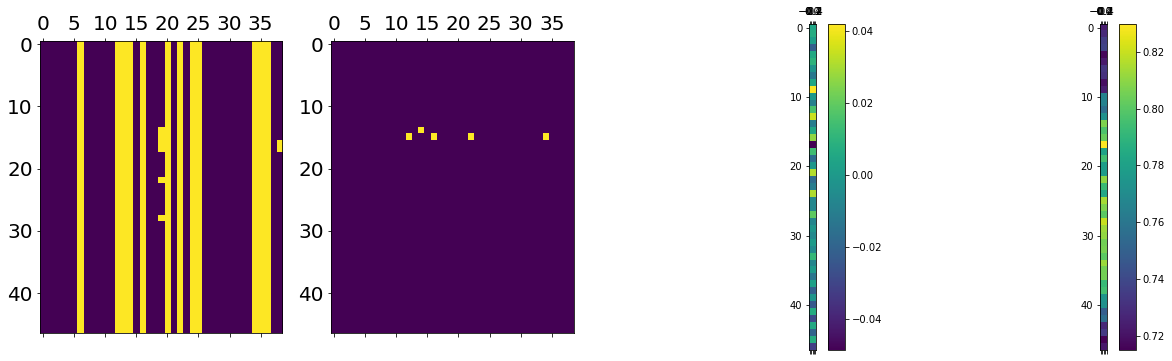

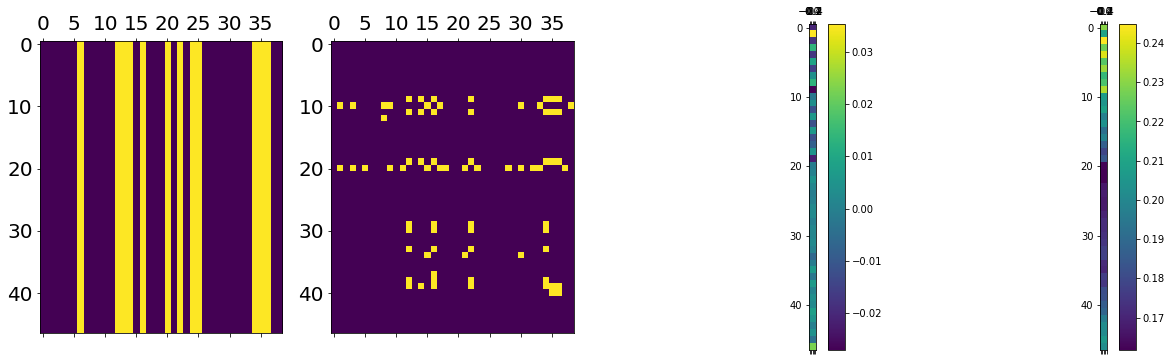

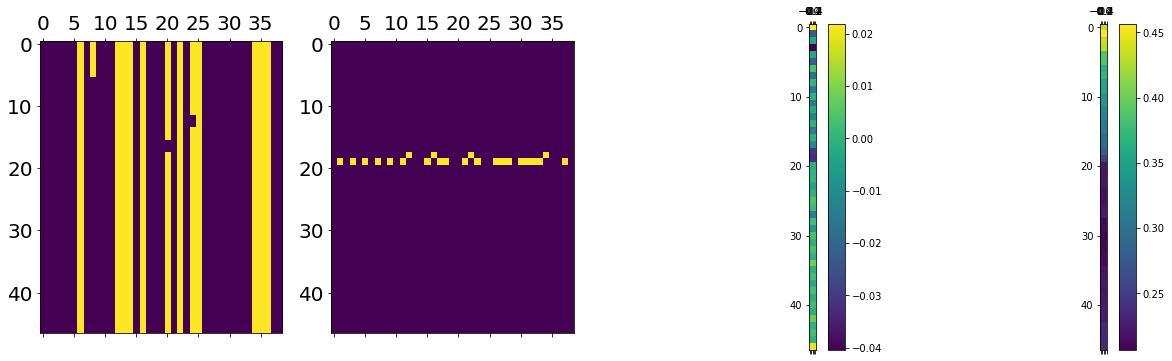

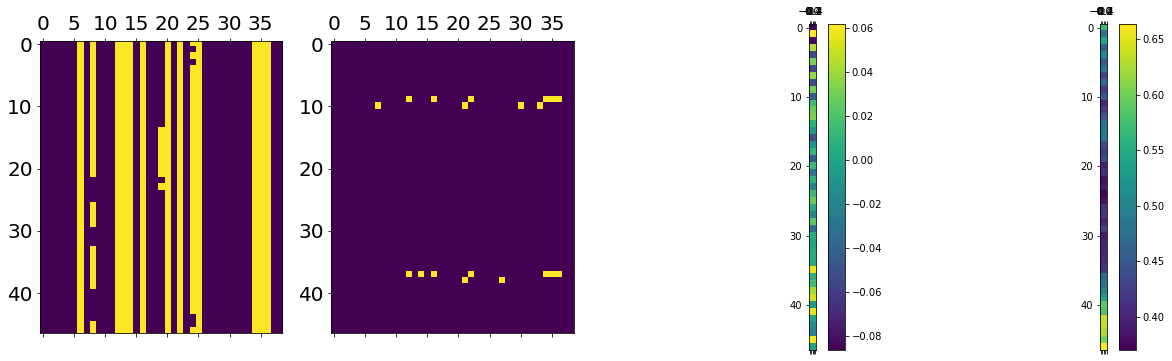

In [144]:
# visualize agent action and physician action for first n live patients
for i in range(20):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))
    # agent policy
    ax[0].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].seq_actions.values))
    # phy policy
    ax[1].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].cur_actions.values))
    # probability gain
    the_plot = ax[2].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].prob_gain.values))

    plt.colorbar(the_plot, ax=ax[2])
    # cur probability
    the_plot = ax[3].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].cur_prob.values))

    plt.colorbar(the_plot, ax=ax[3])

    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=20)

    #     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

## Analyze reward estimator

### Analyze by scatter plot of pred and true reward

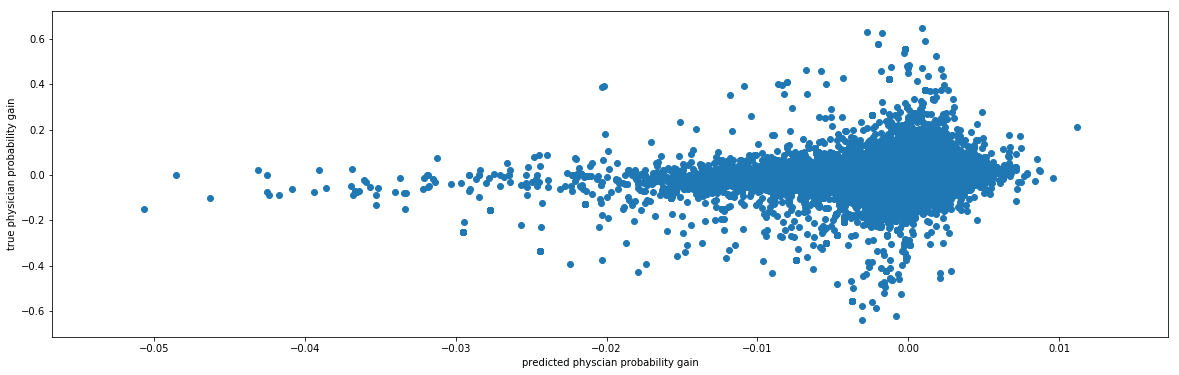

In [108]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(df.pred_phy_prob_gain, df.prob_gain)
plt.xlabel('predicted physcian probability gain')
plt.ylabel('true physician probability gain')
plt.show()

In [109]:
# mean and std of predicted physician probability gain
np.mean(df.pred_phy_prob_gain), np.std(df.pred_phy_prob_gain)

(0.00049586414, 0.0018344929)

In [110]:
# mean and std of true physician probability gain
np.mean(df.prob_gain), np.std(df.prob_gain)

(-0.00059219013, 0.025686897)

In [111]:
# mean and std of predicted agent probability gain
np.mean(df.pred_agent_prob_gain), np.std(df.pred_agent_prob_gain)

(4.9508275e-05, 0.0018891904)

### Calculate correlation and r2

In [112]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, r2_score

In [113]:
# Pearson score
pearsonr(df.pred_phy_prob_gain, df.prob_gain)

(0.17021999, 0.0)

In [114]:
# spearman correlation
spearmanr(df.pred_phy_prob_gain, df.prob_gain)

SpearmanrResult(correlation=0.1412798684168446, pvalue=0.0)

In [131]:
# r square with shift
r2_score(
    df.prob_gain,
    df.pred_phy_prob_gain + np.mean(df.prob_gain) - np.mean(
        df.pred_phy_prob_gain),
    multioutput='variance_weighted')

0.019212902845875623

In [124]:
# r square
r2_score(df.prob_gain, df.pred_phy_prob_gain, multioutput='variance_weighted')

0.01741867339296843

In [128]:
for i in np.arange(1, 200, 0.5):
    print((i, pearsonr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           spearmanr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           r2_score(
               df.prob_gain,
               df.pred_phy_prob_gain * i,
               multioutput='variance_weighted')))

(1.0, 0.17021999, 0.1412798684168446, 0.01741867339296843)
(1.5, 0.17022, 0.1412798684168446, 0.02228893094565043)
(2.0, 0.17021999, 0.1412798684168446, 0.02442263415527457)
(2.5, 0.17021999, 0.1412798684168446, 0.02381978833228149)
(3.0, 0.17022, 0.1412798684168446, 0.020480384115566186)
(3.5, 0.17021997, 0.1412798684168446, 0.014404430258555201)
(4.0, 0.17021999, 0.1412798684168446, 0.005591927617791814)
(4.5, 0.17021997, 0.1412798684168446, -0.005957129213366886)
(5.0, 0.17021999, 0.1412798684168446, -0.02024274116220104)
(5.5, 0.17022002, 0.1412798684168446, -0.03726490297420515)
(6.0, 0.17022, 0.1412798684168446, -0.0570236134501243)
(6.5, 0.17021999, 0.1412798684168446, -0.0795188827128186)
(7.0, 0.17021997, 0.1412798684168446, -0.10475069931656567)
(7.5, 0.17021999, 0.1412798684168446, -0.13271907339275213)
(8.0, 0.17021999, 0.1412798684168446, -0.1634239974993692)
(8.5, 0.17021999, 0.1412798684168446, -0.1968654712934017)
(9.0, 0.17021997, 0.1412798684168446, -0.233043498378816

(71.0, 0.17021999, 0.1412798684168446, -25.927398790402094)
(71.5, 0.17022, 0.1412798684168446, -26.305645717532585)
(72.0, 0.17021997, 0.1412798684168446, -26.686629398462983)
(72.5, 0.17021996, 0.1412798684168446, -27.070349535256916)
(73.0, 0.17021997, 0.1412798684168446, -27.456806312740095)
(73.5, 0.17022002, 0.1412798684168446, -27.845999442585107)
(74.0, 0.17021999, 0.1412798684168446, -28.237929264713927)
(74.5, 0.17021997, 0.1412798684168446, -28.632595704453106)
(75.0, 0.17021997, 0.1412798684168446, -29.02999874817075)
(75.5, 0.17022, 0.1412798684168446, -29.430138008885876)
(76.0, 0.17022005, 0.1412798684168446, -29.833014205409814)
(76.5, 0.17021999, 0.1412798684168446, -30.23862682651239)
(77.0, 0.17021997, 0.1412798684168446, -30.646975968863938)
(77.5, 0.17021997, 0.1412798684168446, -31.05806150650764)
(78.0, 0.17021997, 0.1412798684168446, -31.471883783707984)
(78.5, 0.17021997, 0.1412798684168446, -31.888442642624348)
(79.0, 0.17021996, 0.1412798684168446, -32.307737

(141.0, 0.17022002, 0.1412798684168446, -105.50864010467588)
(141.5, 0.17022, 0.1412798684168446, -106.27000447390381)
(142.0, 0.17021999, 0.1412798684168446, -107.03410525940446)
(142.5, 0.17021999, 0.1412798684168446, -107.80094283656128)
(143.0, 0.17022, 0.1412798684168446, -108.57051690036768)
(143.5, 0.17022, 0.1412798684168446, -109.34282689880702)
(144.0, 0.17021997, 0.1412798684168446, -110.11787426404788)
(144.5, 0.17022, 0.1412798684168446, -110.89565823823534)
(145.0, 0.17021996, 0.1412798684168446, -111.67617829667682)
(145.5, 0.17021996, 0.1412798684168446, -112.4594347269768)
(146.0, 0.17021997, 0.1412798684168446, -113.2454283858326)
(146.5, 0.17022, 0.1412798684168446, -114.03415813296583)
(147.0, 0.17022002, 0.1412798684168446, -114.82562440076151)
(147.5, 0.17021996, 0.1412798684168446, -115.61982778817197)
(148.0, 0.17021999, 0.1412798684168446, -116.41676712299504)
(148.5, 0.17021999, 0.1412798684168446, -117.21644324670008)
(149.0, 0.17021997, 0.1412798684168446, -

In [122]:
for i in np.arange(1, 500, 5):
    print((i, pearsonr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           spearmanr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           r2_score(
               df.prob_gain,
               df.pred_phy_prob_gain / i,
               multioutput='variance_weighted')))

(1, 0.17021999, 0.1412798684168446, 0.01741867339296843)
(6, 0.17022, 0.1412798684168446, 0.00322035046144642)
(11, 0.17022002, 0.1412798684168446, 0.0015526627565878306)
(16, 0.17021999, 0.1412798684168446, 0.0009110790706688965)
(21, 0.17021999, 0.1412798684168446, 0.0005714931030296189)
(26, 0.17021999, 0.1412798684168446, 0.00036130414980617426)
(31, 0.17021997, 0.1412798684168446, 0.00021839668161804934)
(36, 0.17021997, 0.1412798684168446, 0.00011492876683627529)
(41, 0.17022, 0.1412798684168446, 3.654884671333569e-05)
(46, 0.17021999, 0.1412798684168446, -2.4882075557508543e-05)
(51, 0.17022, 0.1412798684168446, -7.432326431078273e-05)
(56, 0.17021997, 0.1412798684168446, -0.0001149688835608842)
(61, 0.17022, 0.1412798684168446, -0.00014897783048972713)
(66, 0.17021999, 0.1412798684168446, -0.00017785772969514113)
(71, 0.17021999, 0.1412798684168446, -0.0002026750128318877)
(76, 0.17022005, 0.1412798684168446, -0.00022423845015295818)
(81, 0.17022002, 0.1412798684168446, -0.0002

In [ ]:
# reward_dir="../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/"

# Analyze Reward estimator 0121

In [11]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from arch.RewardEstimator import load_model
from policy_training_and_evaluation.run_value_estimator_regression_based import set_up_rl_agent
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [12]:
# Low test loss, good sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-64-lr-0.01-reg-0.01-0.5-s-256-5000-i-50-500-3-1/'
# 1st sum_reward
# policy_dir = '../models/dqn_mimic-0107_random_order_search-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-128-lr-0.01-reg-0.0-0.5-s-256-5000-i-50-500-3-1/'
# 0 action cost for 0108
cache_dir = '../RL_exp_cache/0117-30mins-24hrs-20order-rnn-neg_sampled/'
#policy_dir = '../models/dqn_mimic-0118_24hrs_random_order_search-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-32-lr-0.001-reg-0.001-0.7-s-256-5000-i-50-500-3-1'
reward_estimator_dir = "../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/"
rnn_dir = "../models/0117-24hours_39feats_38cov_negsampled_rnn-mimic-nh128-nl2-c1e-07-keeprate0.9_0.7_0.5-npred24-miss1-n_mc_1-MIMIC_window-mingjie_39features_38covs-ManyToOneRNN/"

In [13]:
# Setup the DQN
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.reset_default_graph()
sess = tf.Session(config=config)

#dqn = set_up_rl_agent(sess, policy_dir)
rew_estimator = load_model(sess, reward_estimator_dir, rnn_dir=rnn_dir)
test_loader = rew_estimator.get_data_loader(
    mode='test', sess=sess, batch_size=1024)

Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


In [16]:
# collect key value from test experience
# next(test_loader).keys()
# dict_keys(['cur_state', 'next_state', 'cur_obs', 'next_obs', 'cur_actions', 'next_actions',
# 'prob_gain', 'cur_prob', 'next_prob', 'labels', 'patient_inds', 'the_steps', 'total_steps', 'mortality'])
all_keys = [
    'patient_inds', 'mortality', 'the_steps', 'cur_actions', 'prob_gain',
    'labels', 'cur_prob', 'pred_phy_prob_gain'
]
result = {k: [] for k in all_keys}
for idx, exp in enumerate(test_loader):
    #     exp['seq_actions'] = dqn.get_best_sequential_actions(
    #         sess=sess, cur_state=exp['cur_state'])[:, :-1]
    #     exp['pred_agent_prob_gain'] = rew_estimator.get_predicted_prob_gain(sess, exp, agent_a=exp['seq_actions'])
    exp['pred_phy_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp, agent_a=None)
    for k in all_keys:
        result[k].append(exp[k])

In [17]:
for k in all_keys:
    result[k] = np.concatenate(result[k], axis=0)
    if result[k].ndim > 1:
        result[k] = result[k].tolist()

In [18]:
df = pd.DataFrame(result)

In [19]:
df.shape

(270527, 8)

In [20]:
df.head(10)

patient_inds  mortality  the_steps  \
0           343          0         42   
1           343          0         43   
2           343          0         44   
3           343          0         45   
4           343          0         46   
5           343          0         47   
6           344          0          1   
7           344          0          2   
8           344          0          3   
9           344          0          4   

                                         cur_actions  prob_gain  labels  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.000356       0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.001686       0   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.000355       0   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.000050       0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.000364       0   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.000324       0   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.003878       0   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.001498       0   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  -0.002866       0   
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.001205       0   

   cur_prob  pred_phy_prob_gain  
0  0.202974            0.002406  
1  0.202619            0.002417  
2  0.200932            0.002740  
3  0.200578            0.002752  
4  0.200528            0.002808  
5  0.200164            0.002820  
6  0.277448            0.002228  
7  0.273569            0.002214  
8  0.275067            0.002110  
9  0.272201            0.002182

### Analyze by scatter plot of pred and true reward

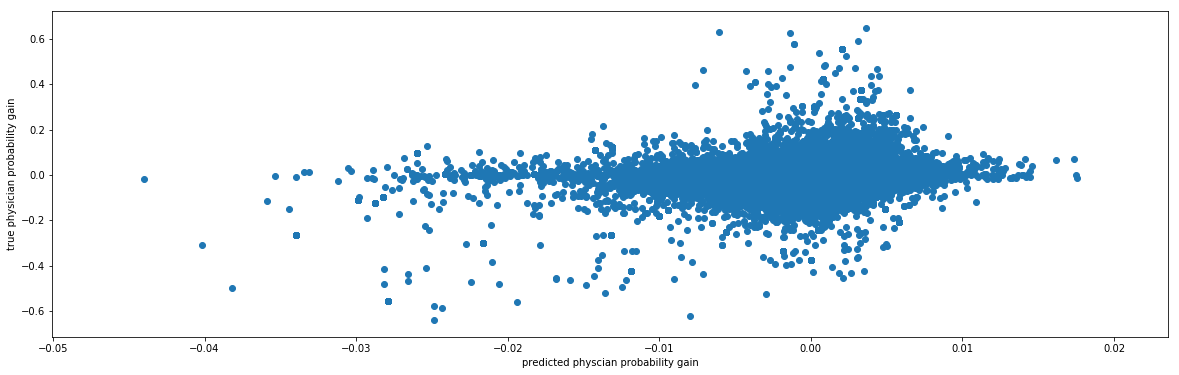

In [22]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(df.pred_phy_prob_gain, df.prob_gain)
plt.xlabel('predicted physcian probability gain')
plt.ylabel('true physician probability gain')
plt.show()

In [23]:
# mean and std of predicted physician probability gain
np.mean(df.pred_phy_prob_gain), np.std(df.pred_phy_prob_gain)

(0.0013088257, 0.0024416894)

In [24]:
# mean and std of true physician probability gain
np.mean(df.prob_gain), np.std(df.prob_gain)

(-0.00058900495, 0.02573131)

### Calculate correlation and r2

In [26]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, r2_score

In [27]:
# Pearson score
pearsonr(df.pred_phy_prob_gain, df.prob_gain)

(0.18704012, 0.0)

In [28]:
# spearman correlation
spearmanr(df.pred_phy_prob_gain, df.prob_gain)

SpearmanrResult(correlation=0.16260536418099844, pvalue=0.0)

In [29]:
# r square with shift
r2_score(
    df.prob_gain,
    df.pred_phy_prob_gain + np.mean(df.prob_gain) - np.mean(
        df.pred_phy_prob_gain),
    multioutput='variance_weighted')

0.026492687324078723

In [30]:
# r square
r2_score(df.prob_gain, df.pred_phy_prob_gain, multioutput='variance_weighted')

0.02105278043725567

In [31]:
for i in np.arange(1, 200, 0.5):
    print((i, pearsonr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           spearmanr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           r2_score(
               df.prob_gain,
               df.pred_phy_prob_gain * i,
               multioutput='variance_weighted')))

(1.0, 0.18704012, 0.16260536418099844, 0.02105278043725567)
(1.5, 0.18704009, 0.1626053641606012, 0.02314737969030578)
(2.0, 0.18704012, 0.16260536418099844, 0.01944613412596652)
(2.5, 0.18704008, 0.16260536403799322, 0.009949029173514035)
(3.0, 0.18704009, 0.1626053641606012, -0.005343925090564916)
(3.5, 0.18704009, 0.16260536504157302, -0.026432732927122556)
(4.0, 0.18704012, 0.16260536418099844, -0.05331739755253673)
(4.5, 0.18704012, 0.1626053641950034, -0.08599791150248604)
(5.0, 0.18704008, 0.16260536403799322, -0.12447428215205057)
(5.5, 0.18704014, 0.16260536435033618, -0.16874649718192813)
(6.0, 0.18704009, 0.1626053641606012, -0.21881456432297952)
(6.5, 0.18704009, 0.16260536443782825, -0.27467848851378096)
(7.0, 0.18704009, 0.16260536504157302, -0.33633826551059687)
(7.5, 0.18704009, 0.16260536454611385, -0.40379389496258455)
(8.0, 0.18704012, 0.16260536418099844, -0.4770453730922939)
(8.5, 0.18704008, 0.1626053641950034, -0.5560927054032994)
(9.0, 0.18704012, 0.162605364195

(70.0, 0.18704008, 0.16260536418099844, -54.47808577388415)
(70.5, 0.18704014, 0.16260536418099844, -55.275818529069774)
(71.0, 0.1870401, 0.16260536418099844, -56.0793474331711)
(71.5, 0.1870401, 0.1626053641950034, -56.88867239021765)
(72.0, 0.18704012, 0.1626053641950034, -57.70379297576402)
(72.5, 0.18704008, 0.16260536418148322, -58.52470927660024)
(73.0, 0.1870401, 0.16260536411306167, -59.3514217858803)
(73.5, 0.18704012, 0.16260536414020546, -60.18392993369182)
(74.0, 0.1870401, 0.16260536389946478, -61.02223360241862)
(74.5, 0.18704009, 0.16260536385716898, -61.866333471857345)
(75.0, 0.18704009, 0.16260536393844227, -62.716229438055294)
(75.5, 0.1870401, 0.16260536392687133, -63.57192081673342)
(76.0, 0.18704015, 0.16260536395692093, -64.43340826049801)
(76.5, 0.18704008, 0.16260536401536058, -65.30069180646937)
(77.0, 0.18704014, 0.1626053639472025, -66.17377070013022)
(77.5, 0.18704014, 0.16260536403232725, -67.05264570359672)
(78.0, 0.18704014, 0.1626053640607905, -67.9373

(139.0, 0.18704009, 0.16260536418099844, -219.35343852323606)
(139.5, 0.1870401, 0.16260536418099844, -220.9509987007626)
(140.0, 0.18704008, 0.16260536418099844, -222.55435583096303)
(140.5, 0.18704008, 0.16260536418099844, -224.16350847502108)
(141.0, 0.18704014, 0.16260536418099844, -225.7784558061872)
(141.5, 0.18704009, 0.16260536418099844, -227.39919933861026)
(142.0, 0.1870401, 0.16260536418099844, -229.02573986797282)
(142.5, 0.1870401, 0.16260536418099844, -230.65807581947146)
(143.0, 0.1870401, 0.1626053641950034, -232.29620771653447)
(143.5, 0.1870401, 0.162605364168399, -233.94013502195935)
(144.0, 0.18704012, 0.1626053641950034, -235.58985888574193)
(144.5, 0.18704008, 0.16260536415487883, -237.24537718404937)
(145.0, 0.18704008, 0.16260536418148322, -238.90669253476577)
(145.5, 0.1870401, 0.16260536397092587, -240.57380346808776)
(146.0, 0.1870401, 0.16260536411306167, -242.24671062464174)
(146.5, 0.18704012, 0.16260536418081487, -243.92541235050143)
(147.0, 0.18704012, 0

In [32]:
for i in np.arange(1, 500, 5):
    print((i, pearsonr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           spearmanr(df.pred_phy_prob_gain * i, df.prob_gain)[0],
           r2_score(
               df.prob_gain,
               df.pred_phy_prob_gain / i,
               multioutput='variance_weighted')))

(1, 0.18704012, 0.16260536418099844, 0.02105278043725567)
(6, 0.18704009, 0.1626053641606012, 0.004682103637159818)
(11, 0.18704014, 0.16260536435033618, 0.002395529990425027)
(16, 0.18704012, 0.16260536418099844, 0.0015037703369389368)
(21, 0.18704014, 0.1626053640602052, 0.0010291824806381022)
(26, 0.18704009, 0.16260536443782825, 0.0007345886936942492)
(31, 0.18704012, 0.16260536403329537, 0.000533907745006279)
(36, 0.18704012, 0.1626053641950034, 0.0003884267974094691)
(41, 0.1870401, 0.16260536417900542, 0.000278114118835604)
(46, 0.18704008, 0.16260536431606762, 0.00019159873932184102)
(51, 0.18704014, 0.1626053650432041, 0.00012192524962062466)
(56, 0.18704009, 0.16260536504157302, 6.462150883901341e-05)
(61, 0.18704012, 0.16260536459540534, 1.665310556997479e-05)
(66, 0.1870401, 0.16260536418099844, -2.4090886356020746e-05)
(71, 0.1870401, 0.16260536418099844, -5.911526475221862e-05)
(76, 0.18704015, 0.16260536395692093, -8.955367517038404e-05)
(81, 0.18704009, 0.16260536416374

# Visualization of policy 0118

In [51]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from arch.RewardEstimator import load_model
from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [148]:
cache_dir = '../RL_exp_cache/0117-30mins-24hrs-20order-rnn-neg_sampled/'
policy_dir = '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-64-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1'
policy_dir = '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1'
reward_estimator_dir = '../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/'
rnn_dir = "../models/0117-24hours_39feats_38cov_negsampled_rnn-mimic-nh128-nl2-c1e-07-keeprate0.9_0.7_0.5-npred24-miss1-n_mc_1-MIMIC_window-mingjie_39features_38covs-ManyToOneRNN/"

In [149]:
selected_feature_name_to_idx = pickle.load(
    open(
        '../data/in_hospital_mortality_181111/selected_feature_name_to_idx.pkl',
        'rb'))
idx_to_feature_name = {
    selected_feature_name_to_idx[k]: k
    for k in selected_feature_name_to_idx
}
idx_to_feature_name

{0: 'Anion gap',
 1: 'Bicarbonate',
 2: 'Blood urea nitrogen',
 3: 'Calcium (total)',
 4: 'Chloride (blood)',
 5: 'Creatine kinase',
 6: 'Creatinine (blood)',
 7: 'Diastolic blood pressure',
 8: 'Glascow coma scale total',
 9: 'Glucose (blood)',
 10: 'Heart Rate',
 11: 'Hematocrit',
 12: 'Hemoglobin',
 13: 'Magnesium',
 14: 'Mean blood pressure',
 15: 'Mean corpuscular hemoglobin',
 16: 'Phosphate',
 17: 'Platelets',
 18: 'Potassium',
 19: 'Prothrombin time',
 20: 'Red blood cell count (blood)',
 21: 'Sodium',
 22: 'Systolic blood pressure',
 23: 'Temperature (C)',
 24: 'White blood cell count (blood)',
 25: 'CO2 (ETCO2, PCO2, etc.)',
 26: 'Oxygen saturation',
 27: 'Partial pressure of carbon dioxide',
 28: 'Partial thromboplastin time',
 29: 'pH (blood)',
 30: 'Bilirubin (total)',
 31: 'Lactate',
 32: 'Lactic acid',
 33: 'Positive end-expiratory pressure',
 34: 'Fraction inspired oxygen',
 35: 'Calcium ionized',
 36: 'Alanine aminotransferase',
 37: 'Alkaline phosphate',
 38: 'Asparat

In [150]:
# Setup the DQN
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.reset_default_graph()
sess = tf.Session(config=config)

dqn = SequencialDuelingDQN.load_saved_model(sess, the_dir=policy_dir)
rew_estimator = load_model(sess, reward_estimator_dir, rnn_dir=rnn_dir)
test_loader = rew_estimator.get_data_loader(
    mode='test', sess=sess, batch_size=1024)

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring para

In [151]:
# collect key value from test experience
# next(test_loader).keys()
# dict_keys(['cur_state', 'next_state', 'cur_obs', 'next_obs', 'cur_actions', 'next_actions',
# 'prob_gain', 'cur_prob', 'next_prob', 'labels', 'patient_inds', 'the_steps', 'total_steps', 'mortality'])
all_keys = [
    'seq_actions', 'patient_inds', 'mortality', 'the_steps', 'cur_actions',
    'prob_gain', 'labels', 'cur_prob', 'pred_agent_prob_gain',
    'pred_phy_prob_gain'
]
result = {k: [] for k in all_keys}
for idx, exp in enumerate(test_loader):
    exp['seq_actions'] = dqn.get_best_sequential_actions(
        sess=sess, cur_state=exp['cur_state'])[:, :-1]
    exp['pred_agent_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp, agent_a=exp['seq_actions'])
    exp['pred_phy_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp)
    for k in all_keys:
        result[k].append(exp[k])

In [152]:
for k in all_keys:
    result[k] = np.concatenate(result[k], axis=0)
    if result[k].ndim > 1:
        result[k] = result[k].tolist()

In [153]:
df = pd.DataFrame(result)

In [154]:
df.shape

(272575, 10)

In [155]:
df.head(2)

seq_actions  patient_inds  mortality  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             1          0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             1          0   

   the_steps                                        cur_actions  prob_gain  \
0          1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.011571   
1          2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   0.000099   

   labels  cur_prob  pred_agent_prob_gain  pred_phy_prob_gain  
0       0  0.413971              0.000775            0.001796  
1       0  0.425542              0.000446            0.001468

In [156]:
np.vstack(df[df.patient_inds == 1].seq_actions.values).shape

(41, 39)

In [157]:
np.vstack(df[df.patient_inds == 1].seq_actions.values)[0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.])

In [158]:
np.vstack(df[df.patient_inds == 1].prob_gain.values).shape

(41, 1)

## Compare physician and agent policy in dead and alive patient

In [159]:
mortality_pat_inds = df[df.mortality ==
                        1].patient_inds.unique()  # dead patient ids
alive_pat_inds = df[df.mortality ==
                    0].patient_inds.unique()  # live patient ids

In [160]:
enumerate(np.mean(action_mat_dead, axis=1))

In [161]:
action_mat_dead.shape

(23429, 39)

In [162]:
action_mat_all_phy = np.vstack(df.cur_actions)
{
    idx_to_feature_name[idx]: val
    for idx, val in enumerate(np.mean(action_mat_all_phy, axis=0))
}

{'Anion gap': 0.0021682105842428688,
 'Bicarbonate': 0.011860955700265982,
 'Blood urea nitrogen': 0.0022232413097312666,
 'Calcium (total)': 0.012040722736861414,
 'Chloride (blood)': 0.002237916169861506,
 'Creatine kinase': 0.012235164633587085,
 'Creatinine (blood)': 0.005965330642942309,
 'Diastolic blood pressure': 0.010184352930386132,
 'Glascow coma scale total': 0.004695955241676603,
 'Glucose (blood)': 0.012524993121159313,
 'Heart Rate': 0.0022635971750894247,
 'Hematocrit': 0.012301201504173163,
 'Hemoglobin': 0.06426121251031826,
 'Magnesium': 0.002971659176373475,
 'Mean blood pressure': 0.00855911217096212,
 'Mean corpuscular hemoglobin': 0.014894983032192975,
 'Phosphate': 0.06622764376777034,
 'Platelets': 0.014385031642667155,
 'Potassium': 0.011299642300284326,
 'Prothrombin time': 0.0023443089058057414,
 'Red blood cell count (blood)': 0.0024947262221406952,
 'Sodium': 0.012213152343391726,
 'Systolic blood pressure': 0.06357149408419702,
 'Temperature (C)': 0.01117

In [163]:
action_mat_all_phy.shape

(272575, 39)

In [164]:
{
    idx_to_feature_name[idx]: val
    for idx, val in enumerate(np.mean(action_mat_all_phy, axis=0))
    if val > 0.01
}

{'Bicarbonate': 0.011860955700265982,
 'Calcium (total)': 0.012040722736861414,
 'Creatine kinase': 0.012235164633587085,
 'Diastolic blood pressure': 0.010184352930386132,
 'Glucose (blood)': 0.012524993121159313,
 'Hematocrit': 0.012301201504173163,
 'Hemoglobin': 0.06426121251031826,
 'Mean corpuscular hemoglobin': 0.014894983032192975,
 'Phosphate': 0.06622764376777034,
 'Platelets': 0.014385031642667155,
 'Potassium': 0.011299642300284326,
 'Sodium': 0.012213152343391726,
 'Systolic blood pressure': 0.06357149408419702,
 'Temperature (C)': 0.011174905989177291,
 'Partial pressure of carbon dioxide': 0.010334770246721086,
 'Partial thromboplastin time': 0.01162982665321471,
 'Bilirubin (total)': 0.013467852884527195,
 'Lactic acid': 0.011222599284600569,
 'Positive end-expiratory pressure': 0.012668073007429148,
 'Fraction inspired oxygen': 0.06430890580574154,
 'Calcium ionized': 0.01332477299825736,
 'Alanine aminotransferase': 0.019396496377143906,
 'Alkaline phosphate': 0.01124

In [165]:
action_mat_all = np.vstack(df.seq_actions)
{
    idx_to_feature_name[idx]: val
    for idx, val in enumerate(np.mean(action_mat_all, axis=0))
}

{'Anion gap': 0.012304870219205724,
 'Bicarbonate': 0.012304870219205724,
 'Blood urea nitrogen': 0.012304870219205724,
 'Calcium (total)': 0.012304870219205724,
 'Chloride (blood)': 0.012304870219205724,
 'Creatine kinase': 0.013196367972117765,
 'Creatinine (blood)': 0.015537008162890947,
 'Diastolic blood pressure': 0.01449509309364395,
 'Glascow coma scale total': 0.01547097129230487,
 'Glucose (blood)': 0.012304870219205724,
 'Heart Rate': 0.012304870219205724,
 'Hematocrit': 0.012304870219205724,
 'Hemoglobin': 0.34459139686324863,
 'Magnesium': 0.012304870219205724,
 'Mean blood pressure': 0.012359900944694122,
 'Mean corpuscular hemoglobin': 0.012304870219205724,
 'Phosphate': 0.10719985325139869,
 'Platelets': 0.012304870219205724,
 'Potassium': 0.012304870219205724,
 'Prothrombin time': 0.014454737228285794,
 'Red blood cell count (blood)': 0.012304870219205724,
 'Sodium': 0.012304870219205724,
 'Systolic blood pressure': 0.09981106117582317,
 'Temperature (C)': 0.01230487021

[Text(0,0,'0'), Text(0,0,'0'), Text(0,0,'13'), Text(0,0,'26')]

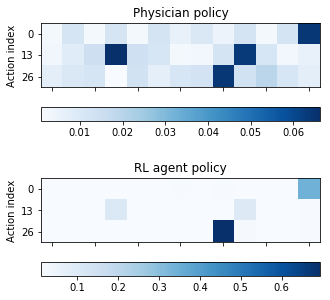

In [169]:
fig = plt.figure(figsize=(5, 1.618 * 5))
plt.subplot('311')
plt.title('Physician policy')
plt.imshow(
    np.mean(action_mat_all_phy, axis=0).reshape(3, 13), cmap=plt.cm.Blues)
plt.colorbar(orientation='horizontal')
plt.ylabel('Action index')
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([0, 0, 13, 26])

plt.subplot('312')
plt.title('RL agent policy')
plt.imshow(np.mean(action_mat_all, axis=0).reshape(3, 13), cmap=plt.cm.Blues)
plt.colorbar(orientation='horizontal')
plt.ylabel('Action index')

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([0, 0, 13, 26])

## Policy for live/dead patient

In [77]:
action_mat_dead = np.vstack(df[df.mortality == 1].seq_actions)
{
    idx_to_feature_name[idx]: val
    for idx, val in enumerate(np.mean(action_mat_dead, axis=0))
}

{'Anion gap': 0.0,
 'Bicarbonate': 0.0,
 'Blood urea nitrogen': 0.00029877502240812666,
 'Calcium (total)': 0.0,
 'Chloride (blood)': 0.0,
 'Creatine kinase': 0.0,
 'Creatinine (blood)': 0.0,
 'Diastolic blood pressure': 0.0,
 'Glascow coma scale total': 0.0,
 'Glucose (blood)': 0.0,
 'Heart Rate': 0.0,
 'Hematocrit': 0.0,
 'Hemoglobin': 0.0008109607751077725,
 'Magnesium': 0.0,
 'Mean blood pressure': 0.0,
 'Mean corpuscular hemoglobin': 0.0,
 'Phosphate': 0.18763071407230356,
 'Platelets': 0.0,
 'Potassium': 0.0,
 'Prothrombin time': 0.0,
 'Red blood cell count (blood)': 0.0,
 'Sodium': 0.0,
 'Systolic blood pressure': 0.008579111357719067,
 'Temperature (C)': 0.0,
 'White blood cell count (blood)': 0.0,
 'CO2 (ETCO2, PCO2, etc.)': 0.0,
 'Oxygen saturation': 0.0,
 'Partial pressure of carbon dioxide': 0.0,
 'Partial thromboplastin time': 0.0,
 'pH (blood)': 0.0,
 'Bilirubin (total)': 0.0,
 'Lactate': 0.0,
 'Lactic acid': 0.0,
 'Positive end-expiratory pressure': 0.0,
 'Fraction inspi

In [78]:
action_mat_alive = np.vstack(df[df.mortality == 0].seq_actions)
{
    idx_to_feature_name[idx]: val
    for idx, val in enumerate(np.mean(action_mat_alive, axis=0))
}

{'Anion gap': 0.0,
 'Bicarbonate': 0.0,
 'Blood urea nitrogen': 4.013710836216515e-06,
 'Calcium (total)': 0.0,
 'Chloride (blood)': 0.0,
 'Creatine kinase': 0.0,
 'Creatinine (blood)': 0.0,
 'Diastolic blood pressure': 0.0,
 'Glascow coma scale total': 0.0,
 'Glucose (blood)': 0.0,
 'Heart Rate': 0.0,
 'Hematocrit': 0.0,
 'Hemoglobin': 0.001549292382779575,
 'Magnesium': 0.0,
 'Mean blood pressure': 0.0,
 'Mean corpuscular hemoglobin': 0.0,
 'Phosphate': 0.535127997238567,
 'Platelets': 0.0,
 'Potassium': 0.0,
 'Prothrombin time': 0.0,
 'Red blood cell count (blood)': 0.0,
 'Sodium': 0.0,
 'Systolic blood pressure': 0.00656643092805022,
 'Temperature (C)': 0.0,
 'White blood cell count (blood)': 0.0,
 'CO2 (ETCO2, PCO2, etc.)': 0.0,
 'Oxygen saturation': 0.0,
 'Partial pressure of carbon dioxide': 0.0,
 'Partial thromboplastin time': 0.0,
 'pH (blood)': 0.0,
 'Bilirubin (total)': 0.0,
 'Lactate': 0.0,
 'Lactic acid': 0.0,
 'Positive end-expiratory pressure': 0.0,
 'Fraction inspired o

In [83]:
np.mean(action_mat_alive)

0.018125506473703916

In [84]:
np.mean(action_mat_dead)

0.0070797641756709575

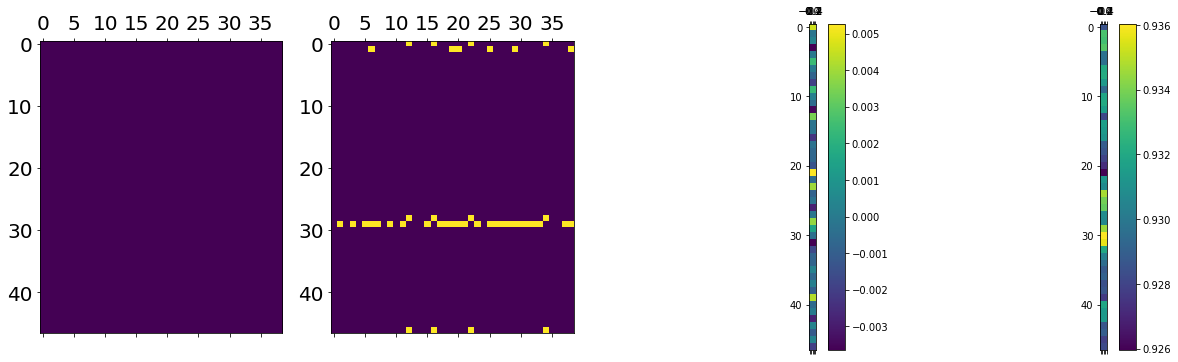

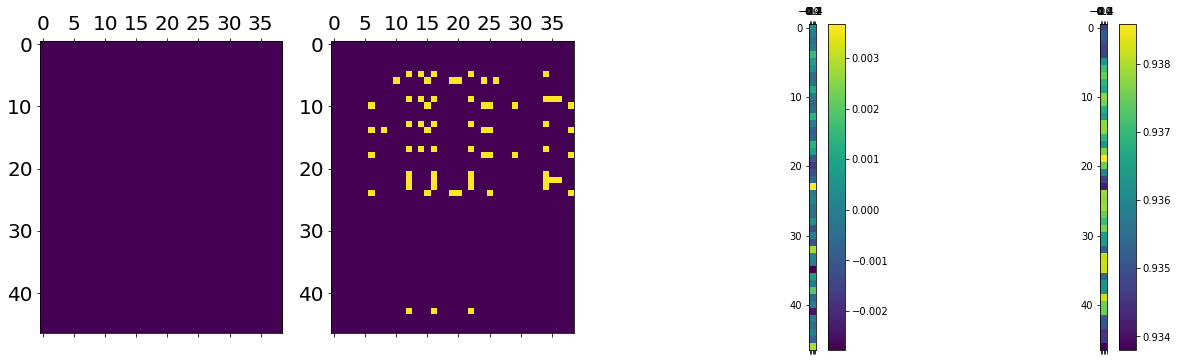

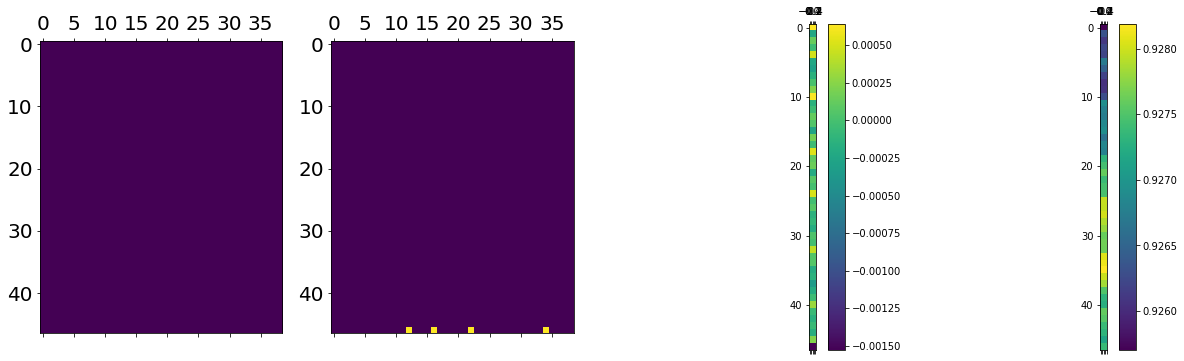

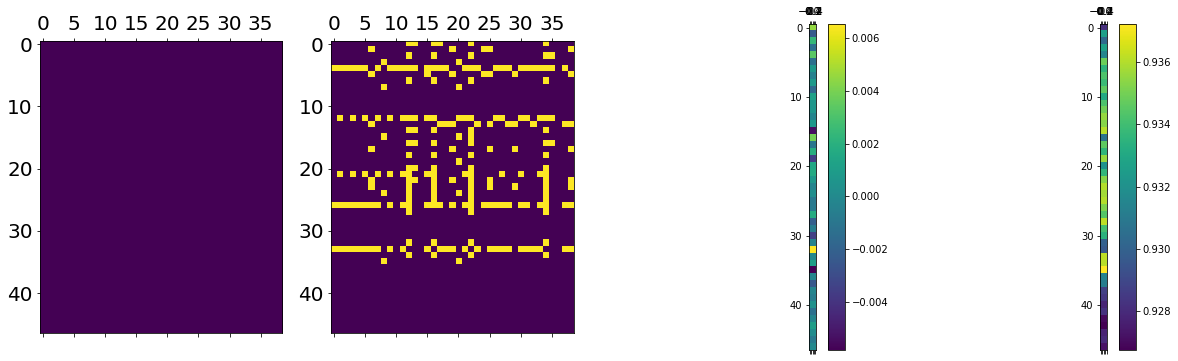

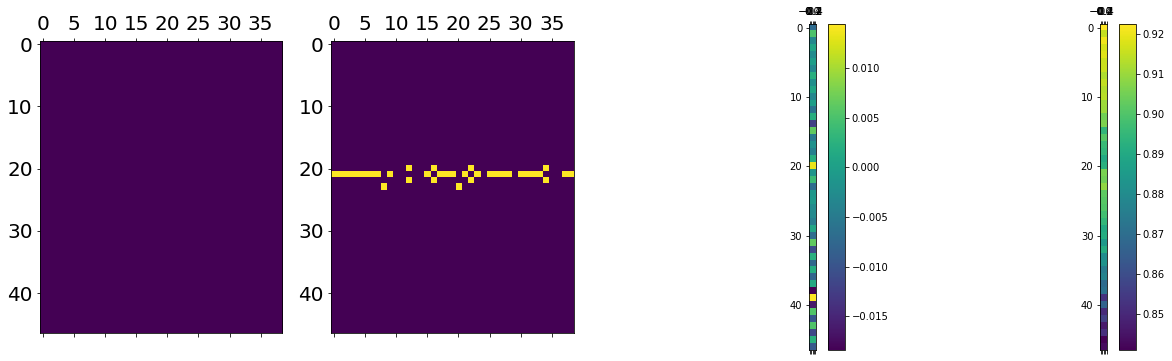

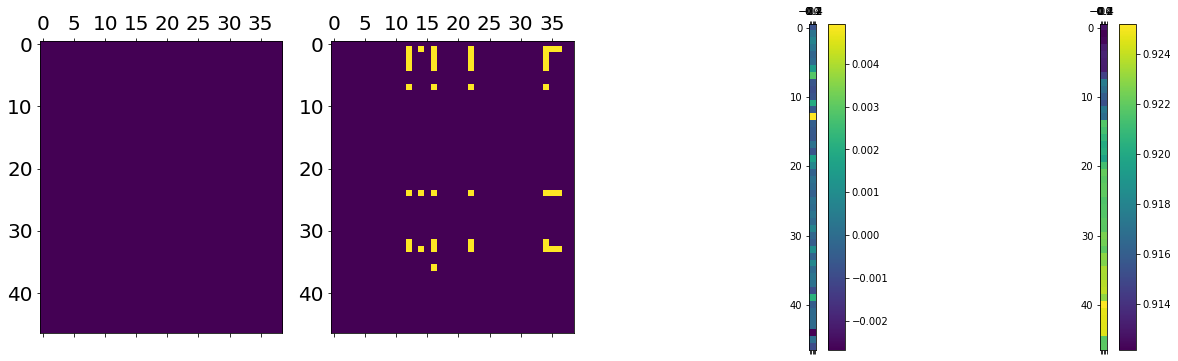

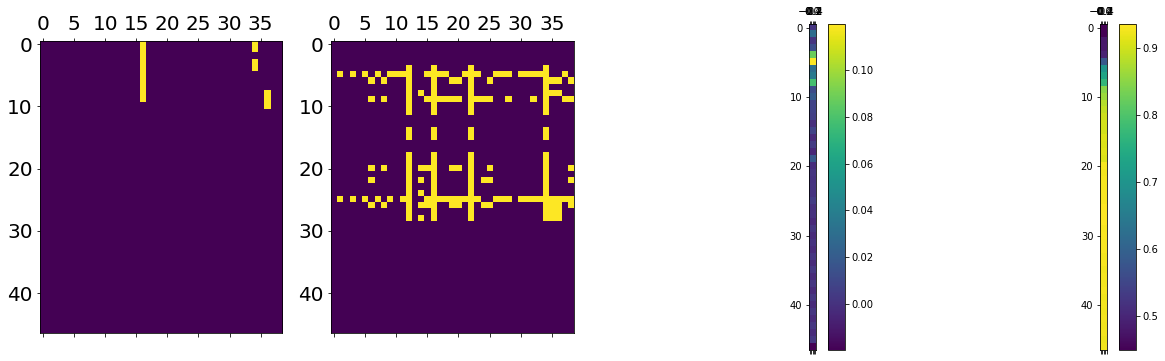

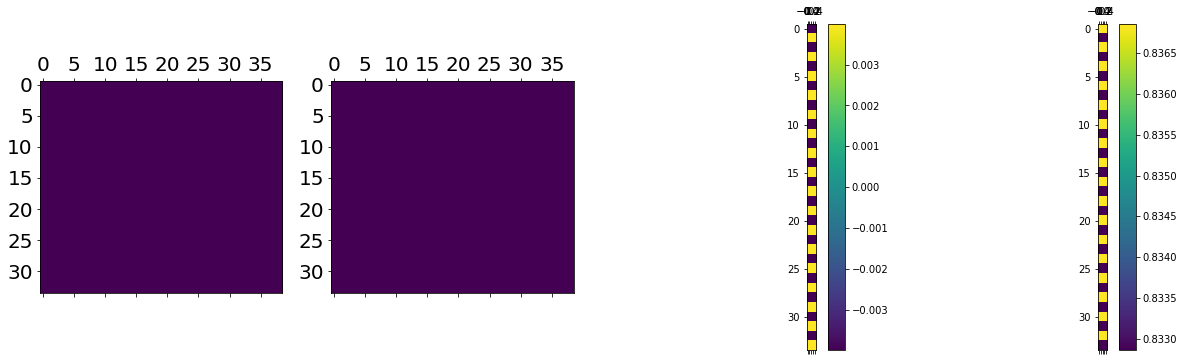

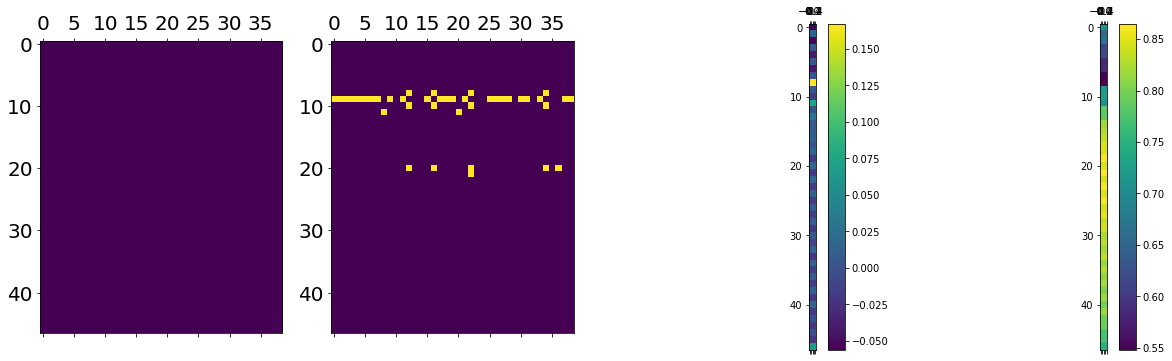

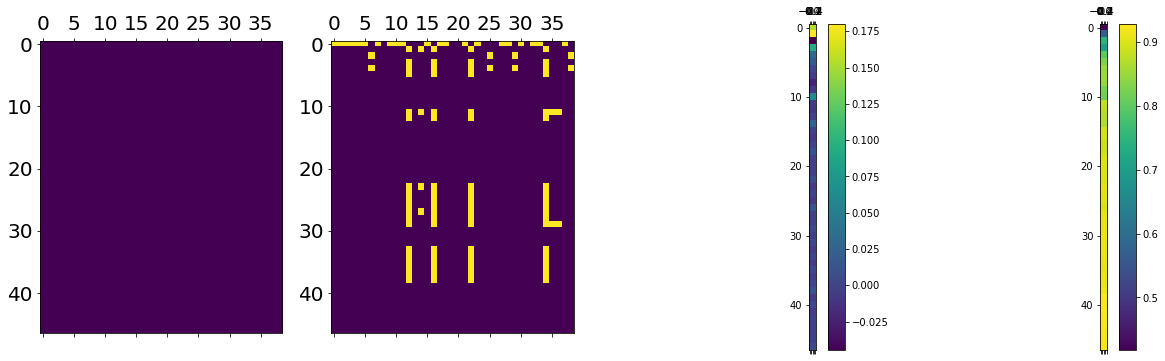

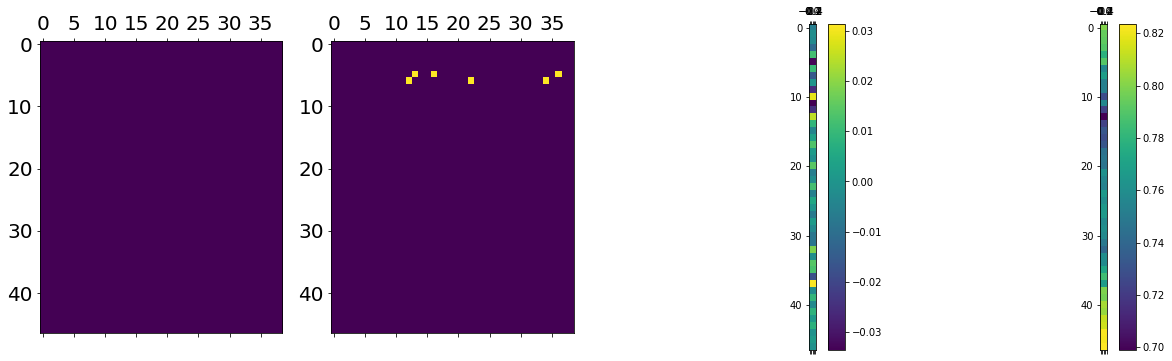

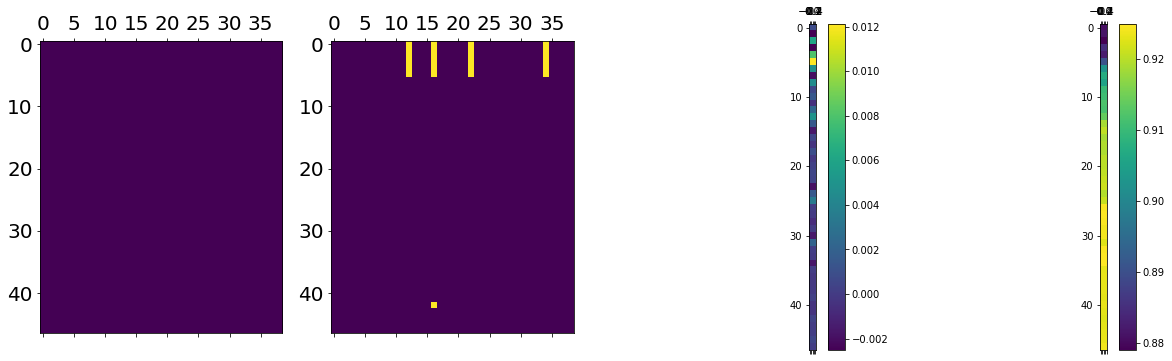

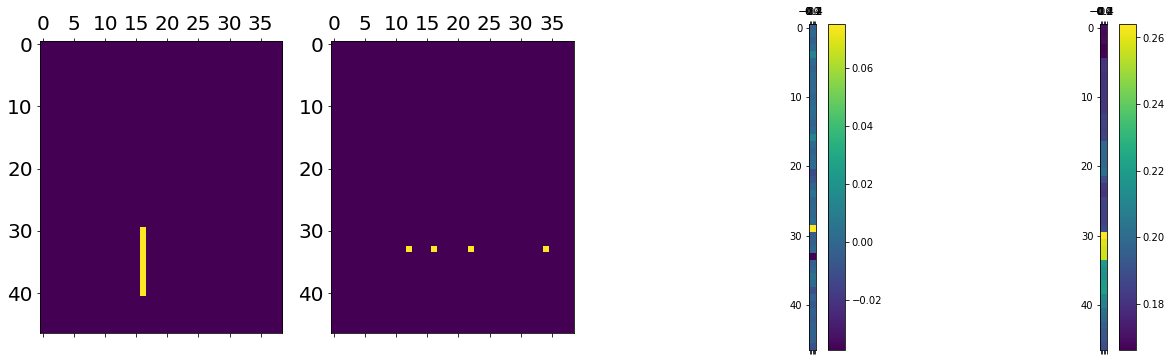

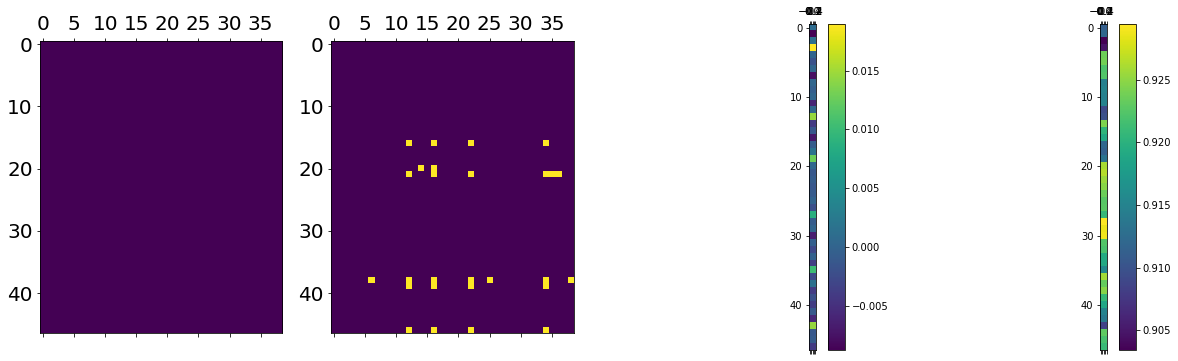

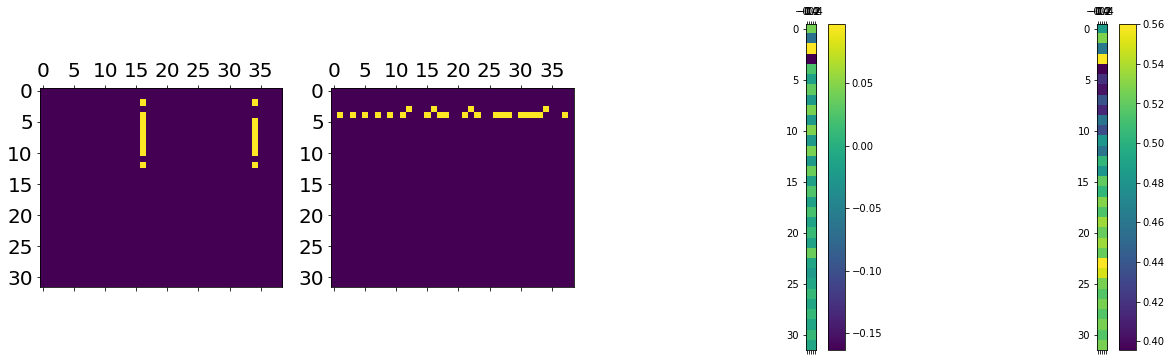

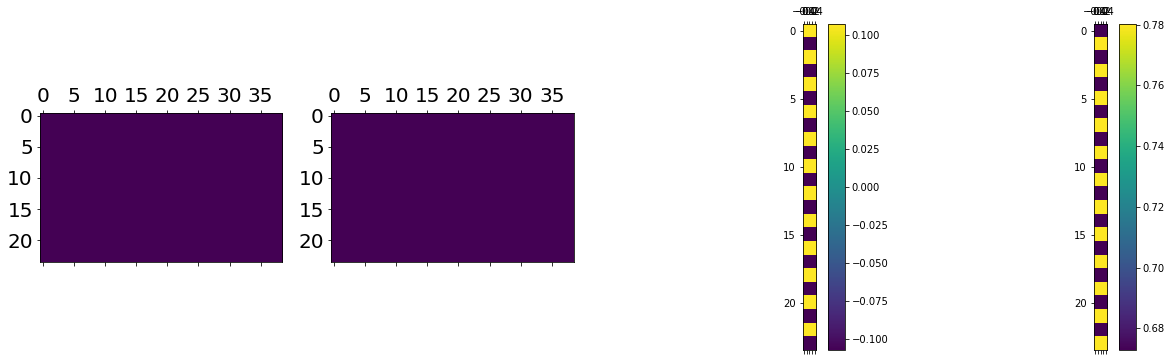

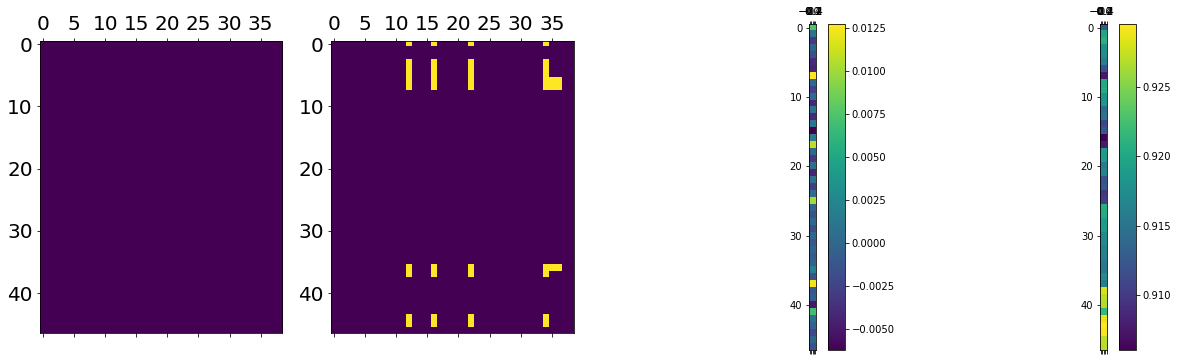

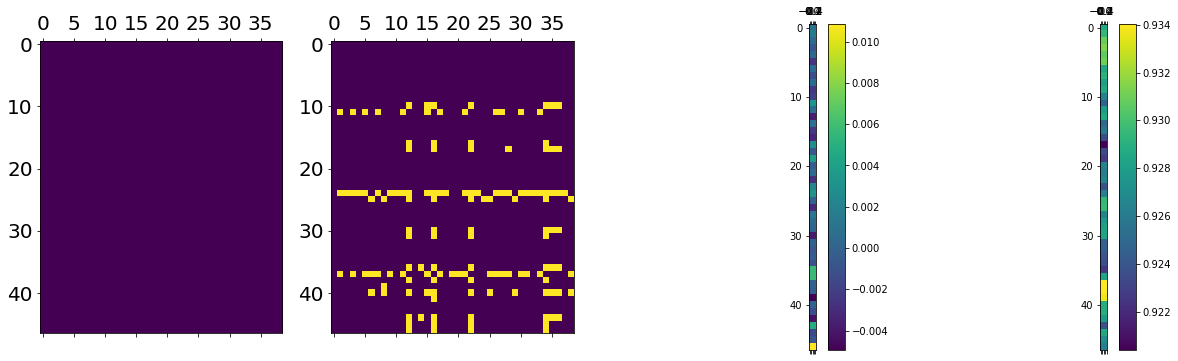

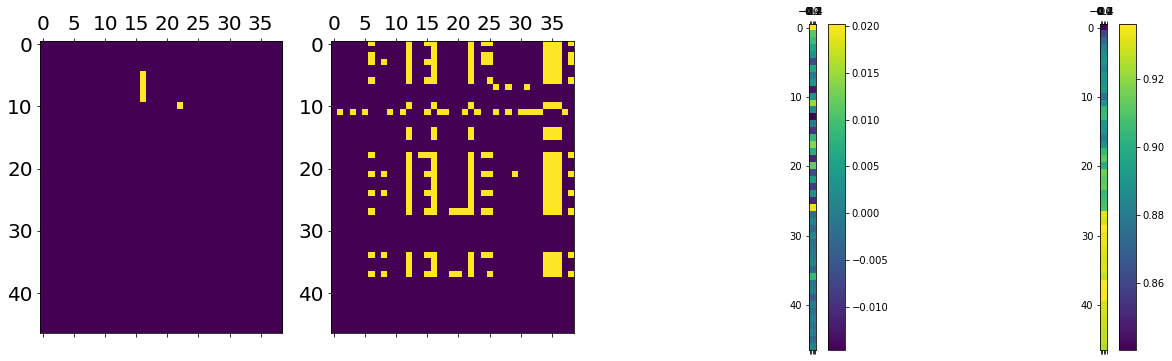

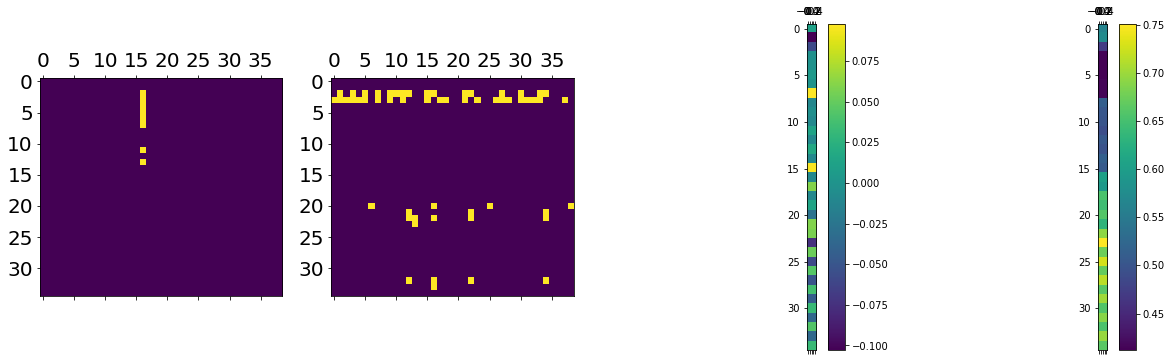

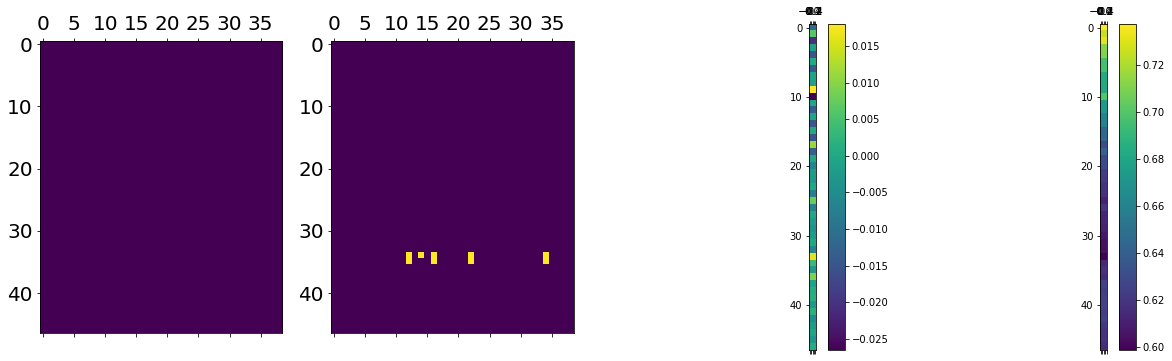

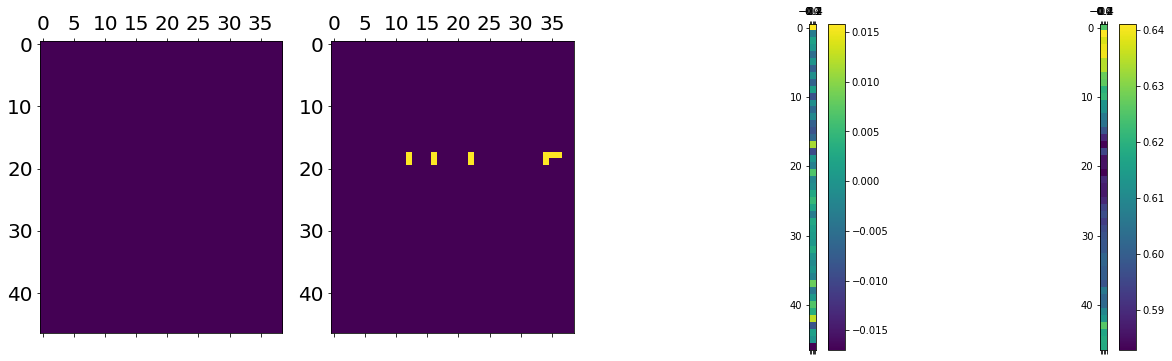

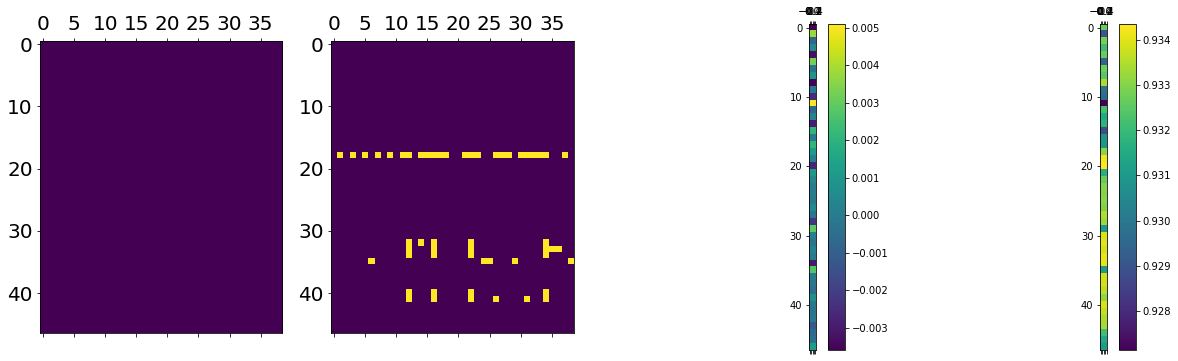

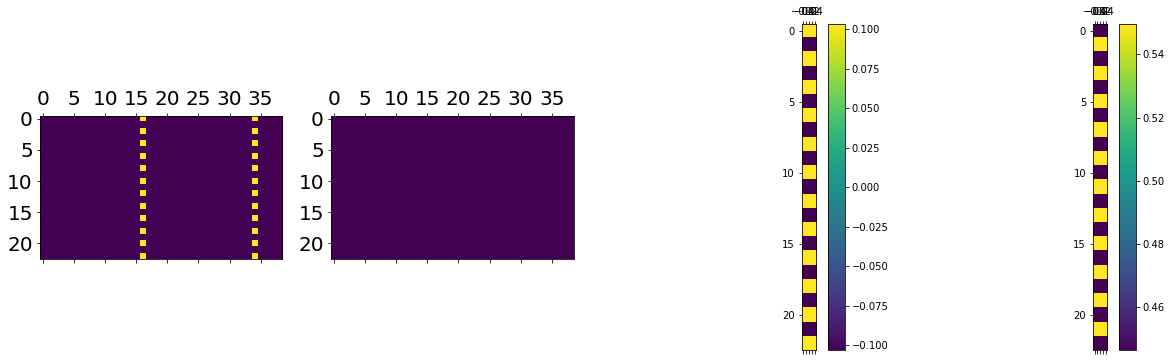

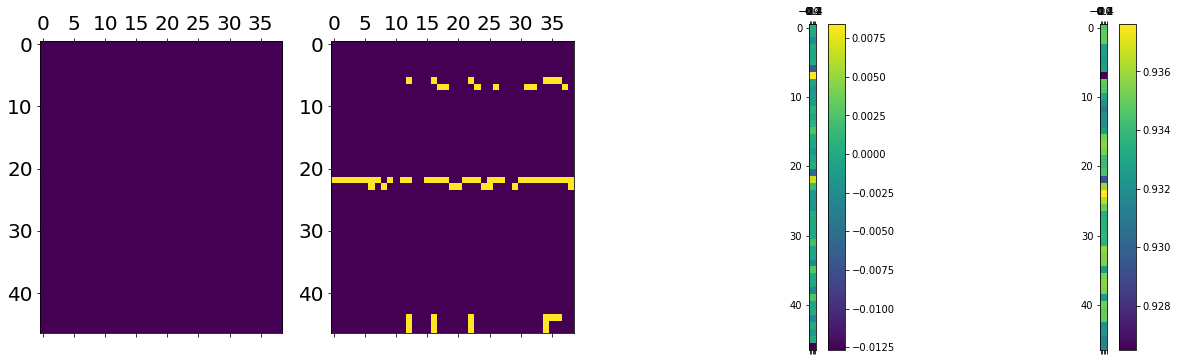

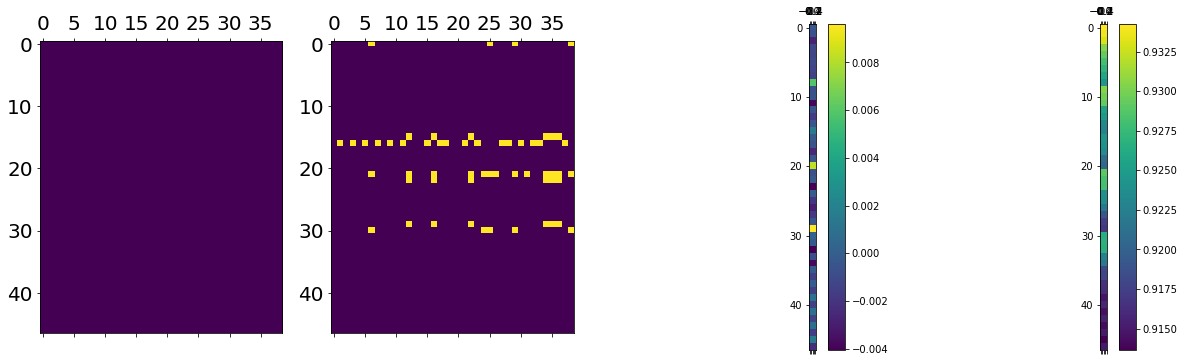

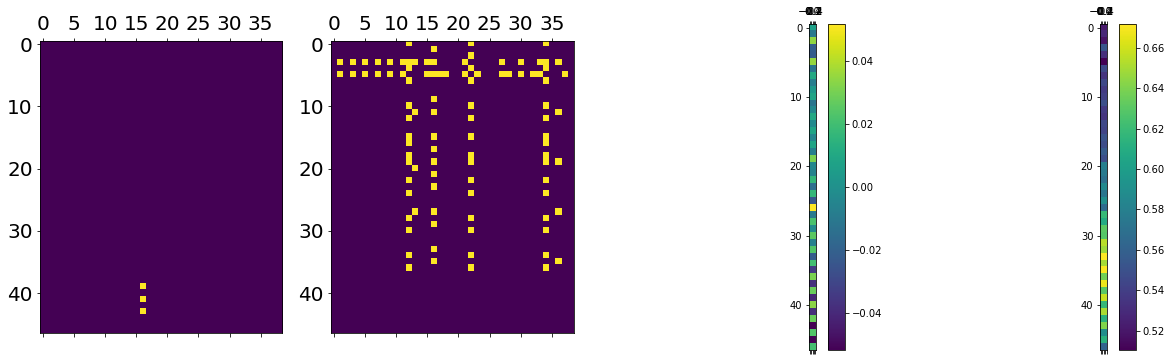

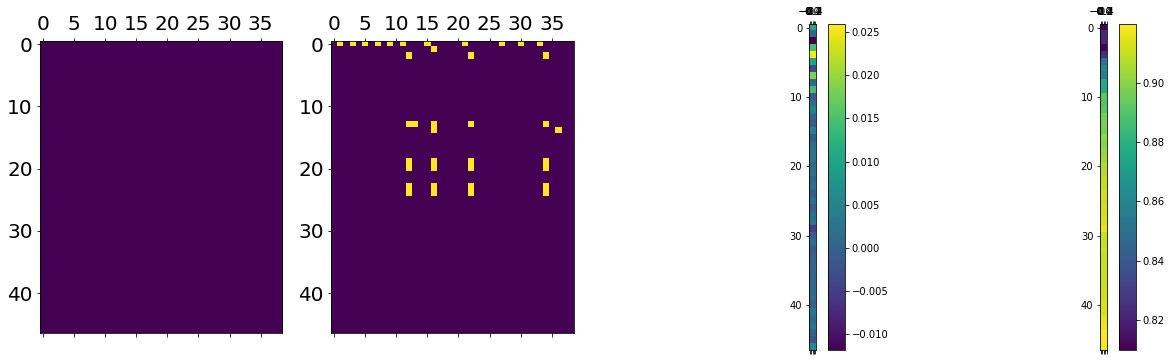

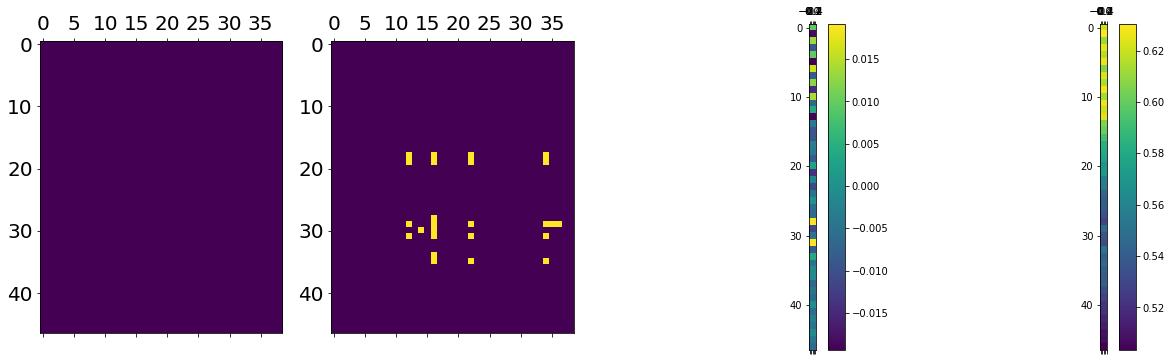

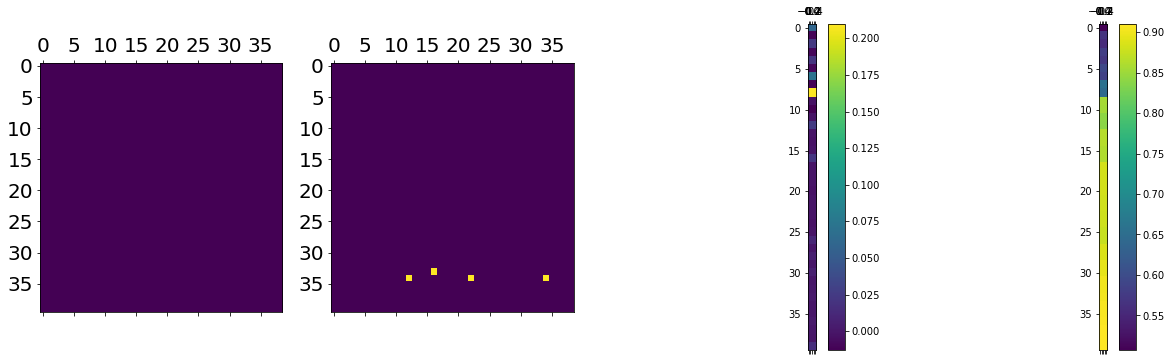

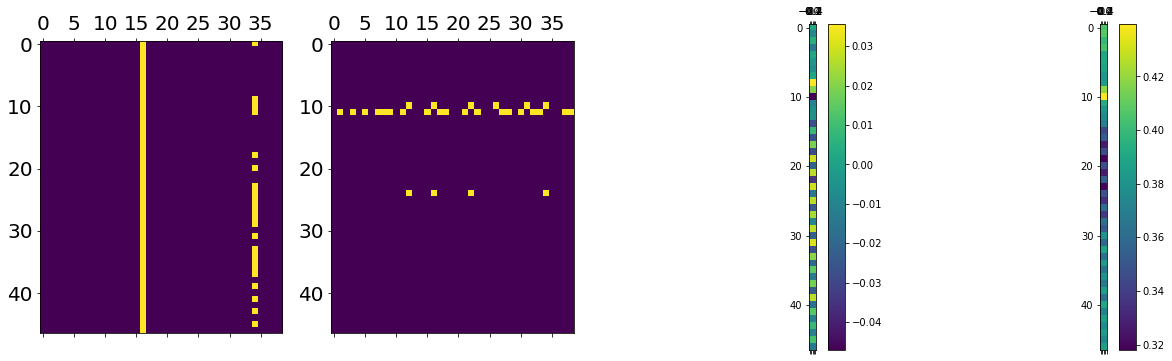

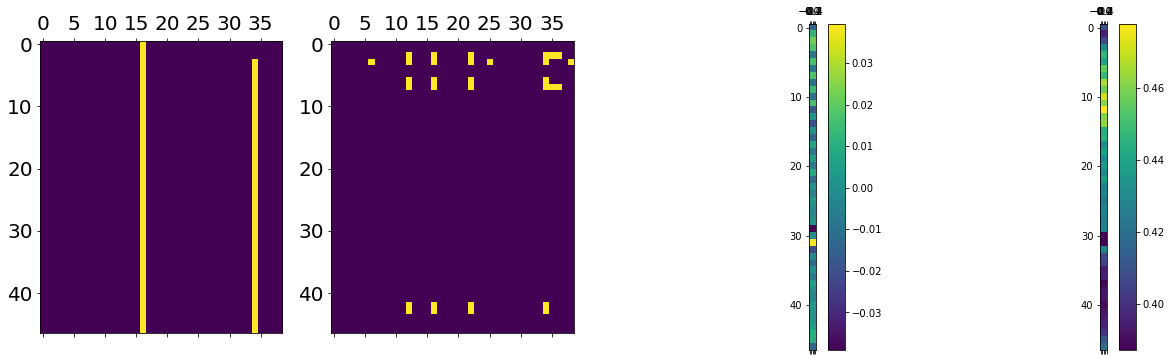

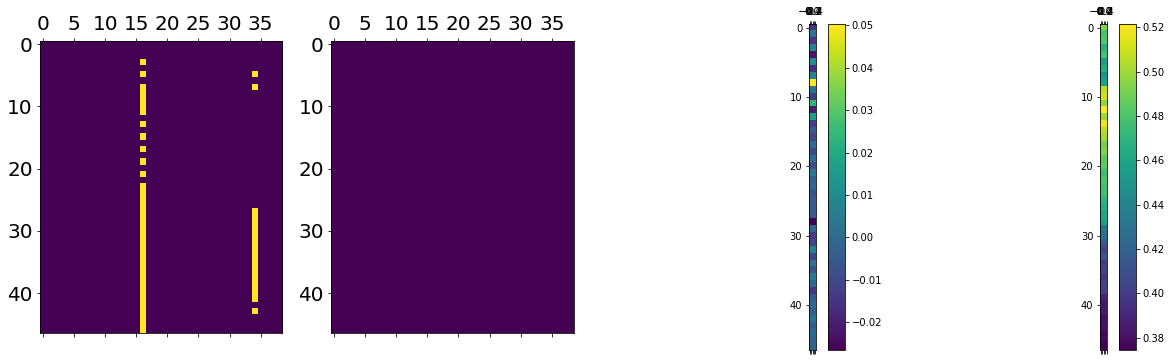

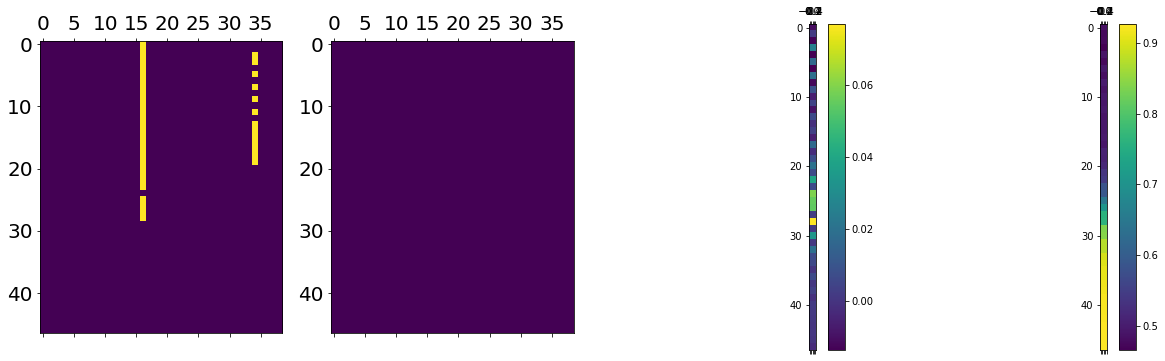

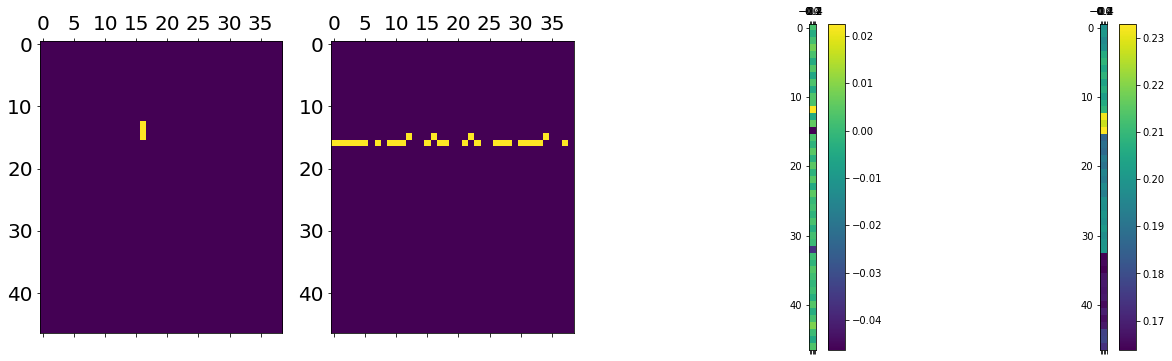

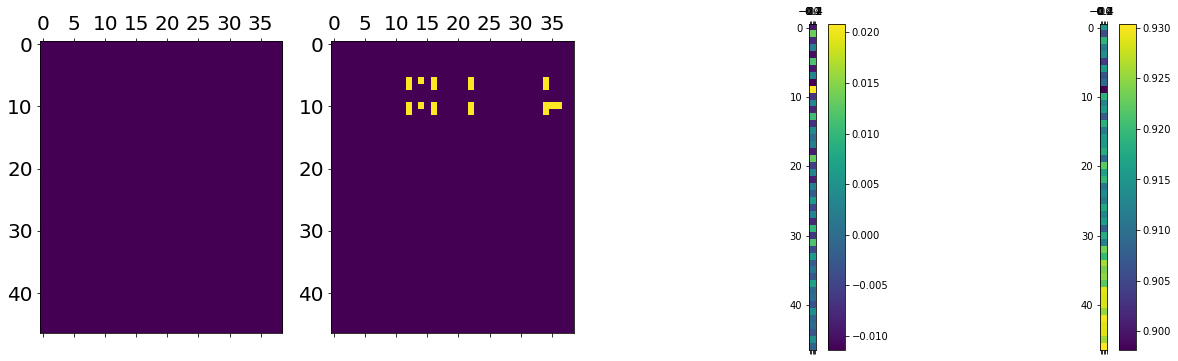

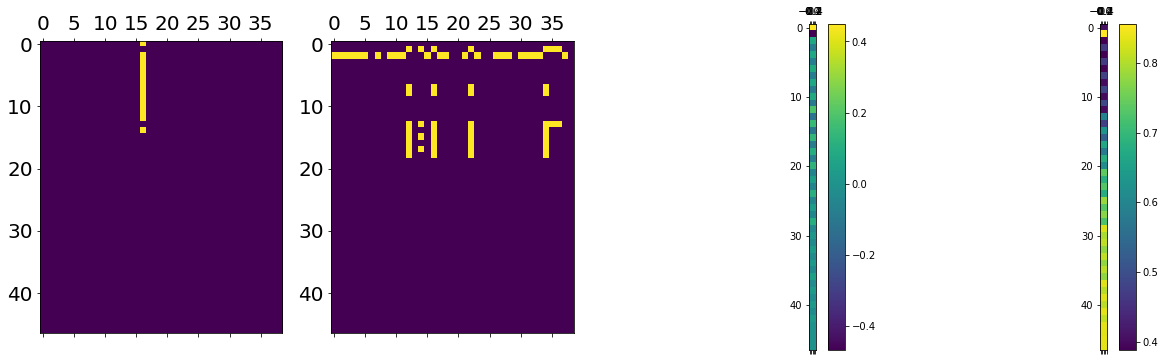

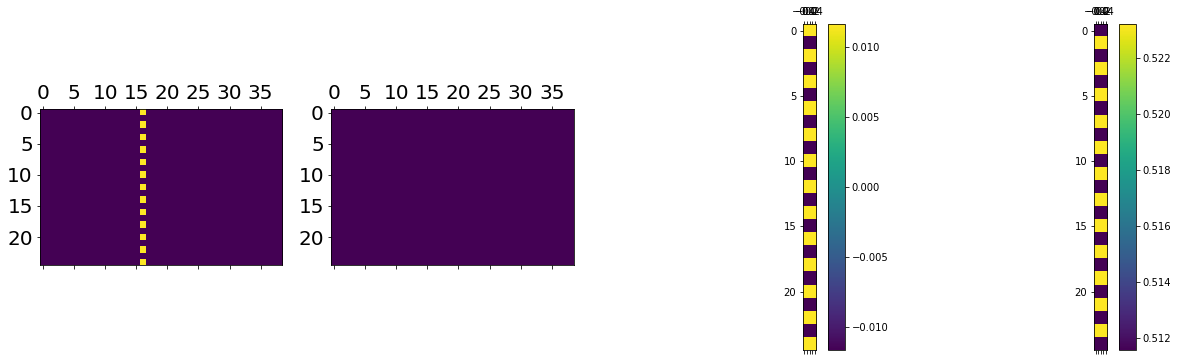

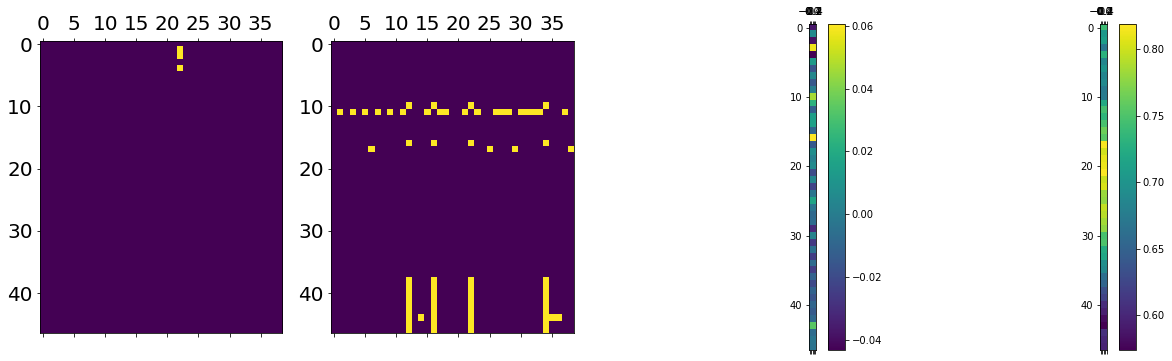

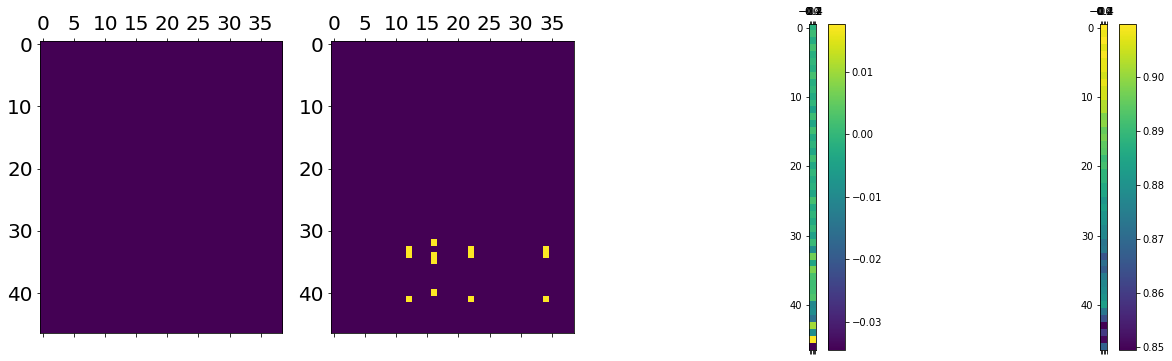

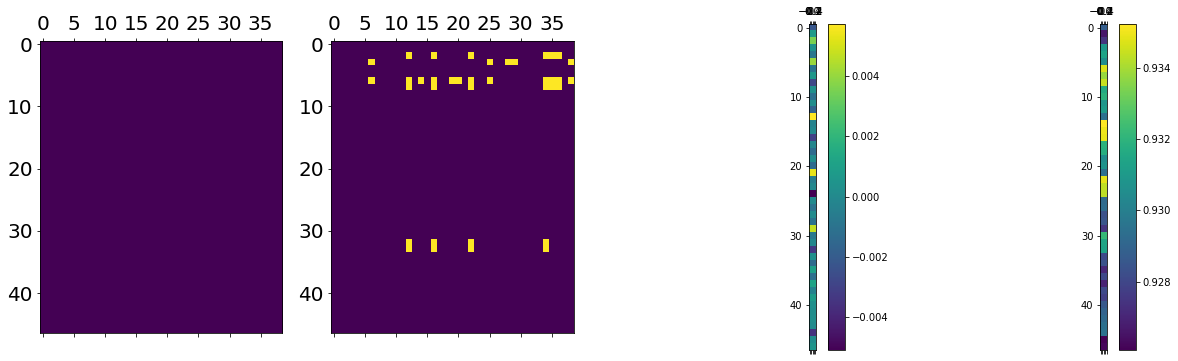

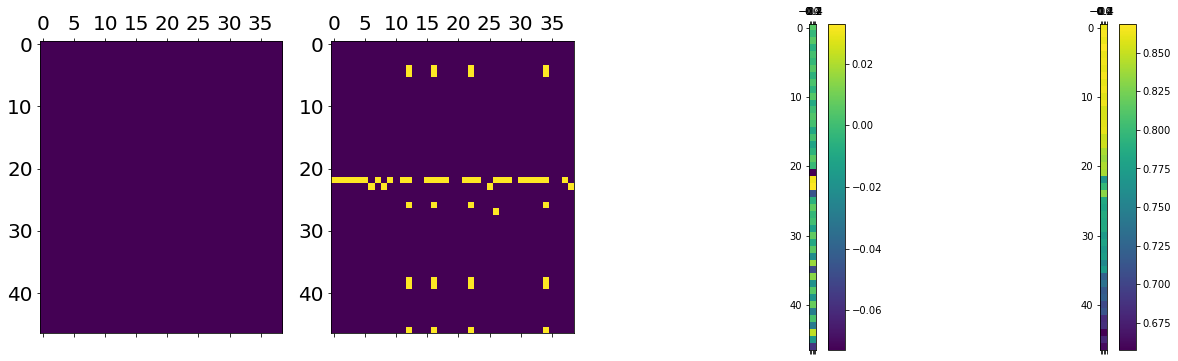

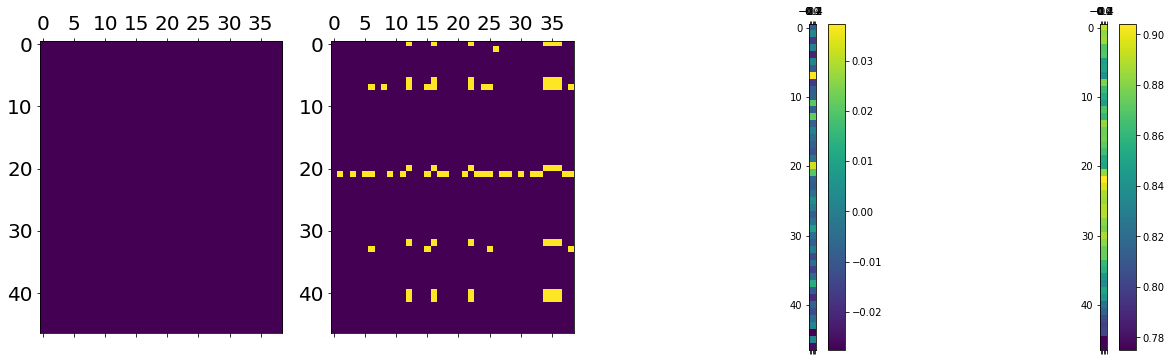

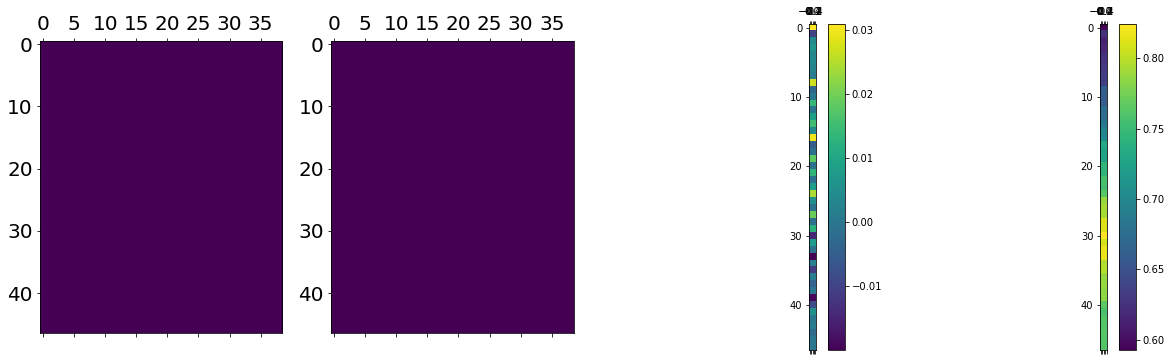

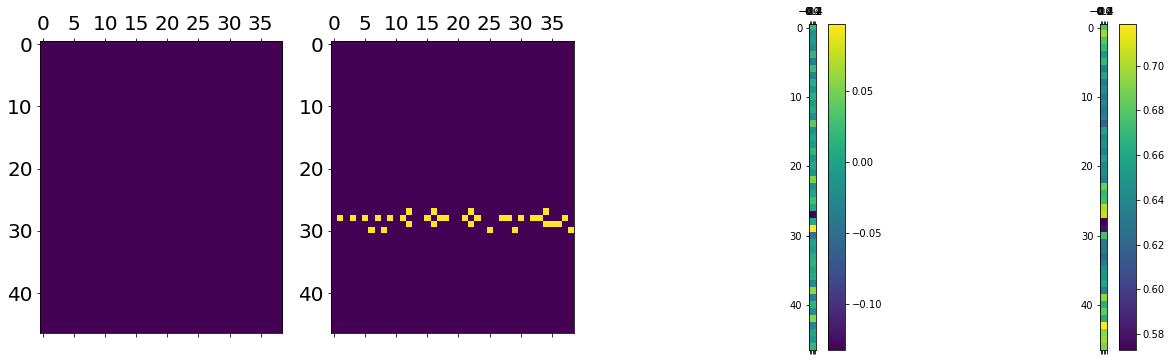

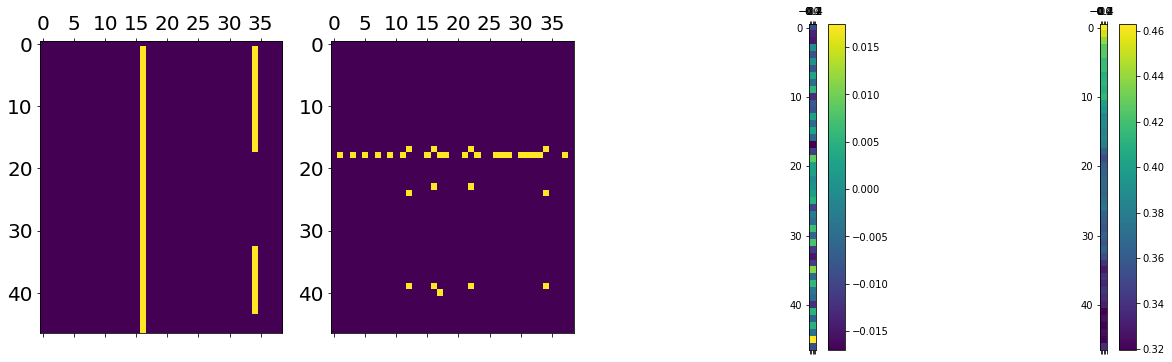

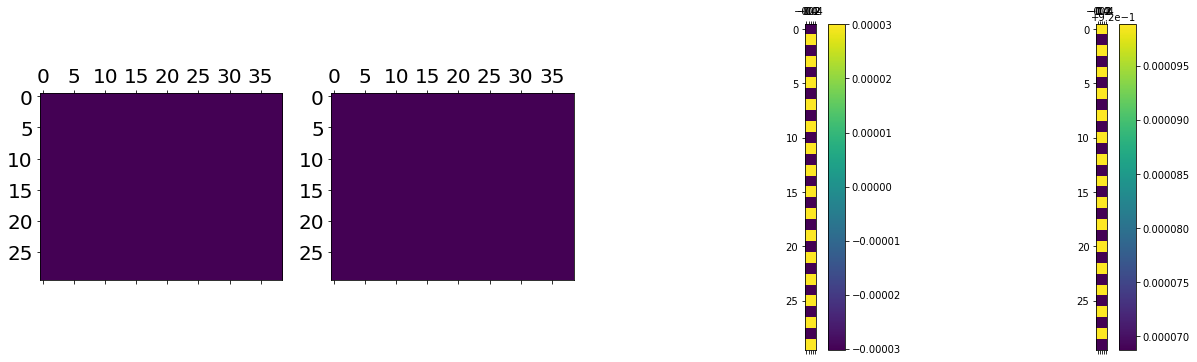

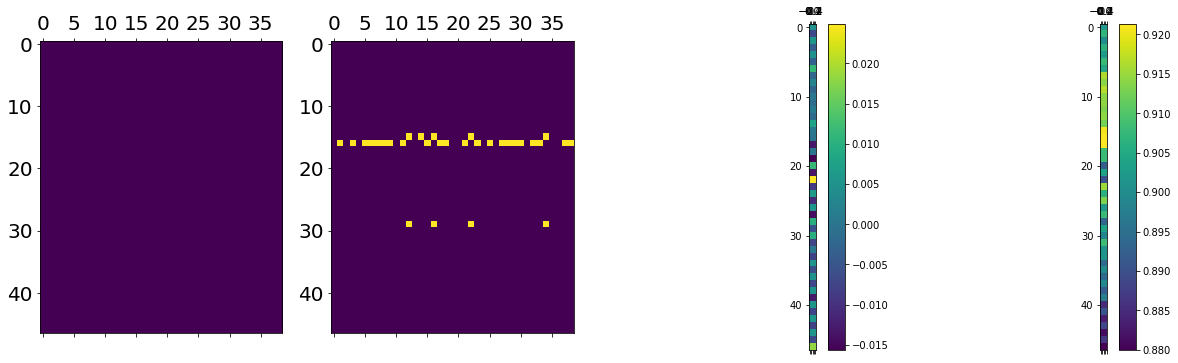

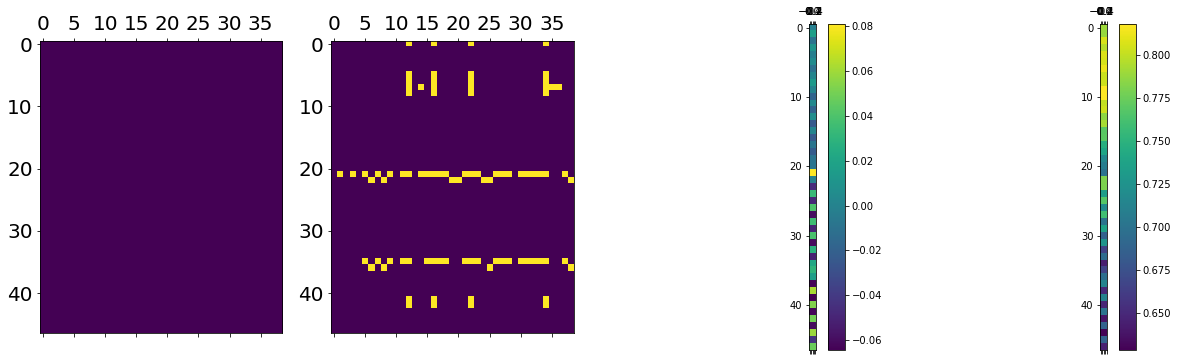

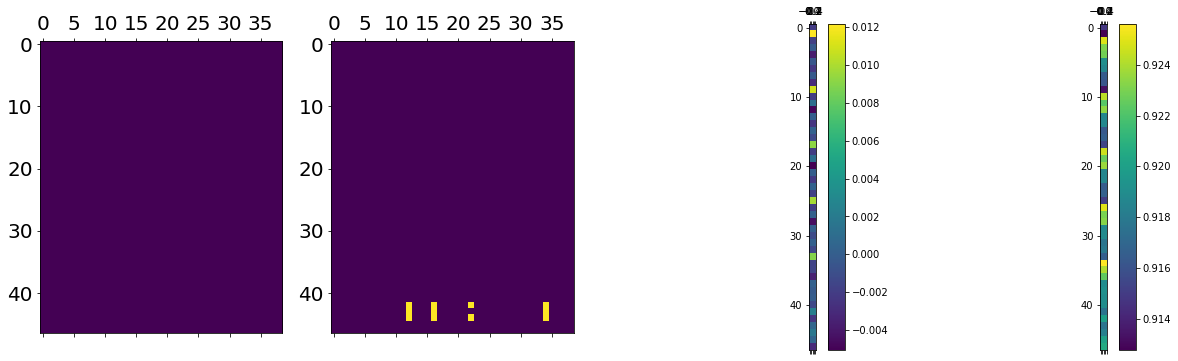

In [64]:
# visualize agent action and physician action for first n dead patients
for i in range(50):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))
    # agent policy
    ax[0].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].seq_actions.values))
    # phy policy
    ax[1].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].cur_actions.values))
    # probability gain
    the_plot = ax[2].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].prob_gain.values))

    plt.colorbar(the_plot, ax=ax[2])
    # cur probability
    the_plot = ax[3].matshow(
        np.vstack(
            df[df.patient_inds == mortality_pat_inds[i]].cur_prob.values))

    plt.colorbar(the_plot, ax=ax[3])

    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=20)

    #     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

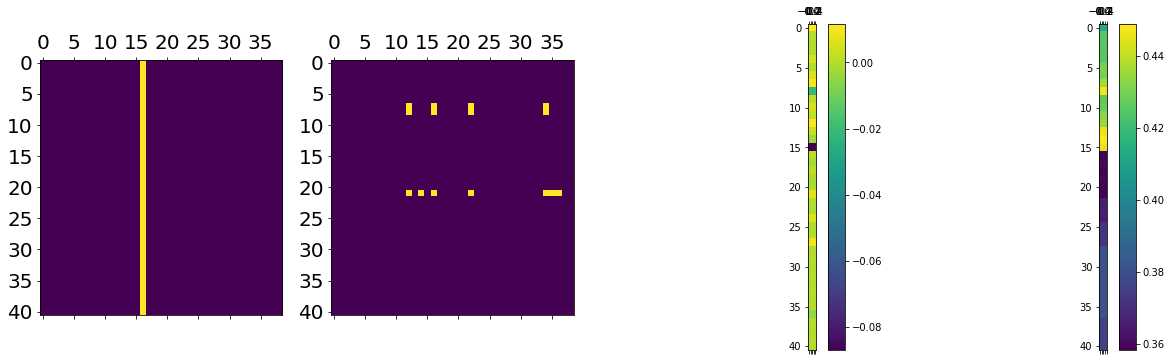

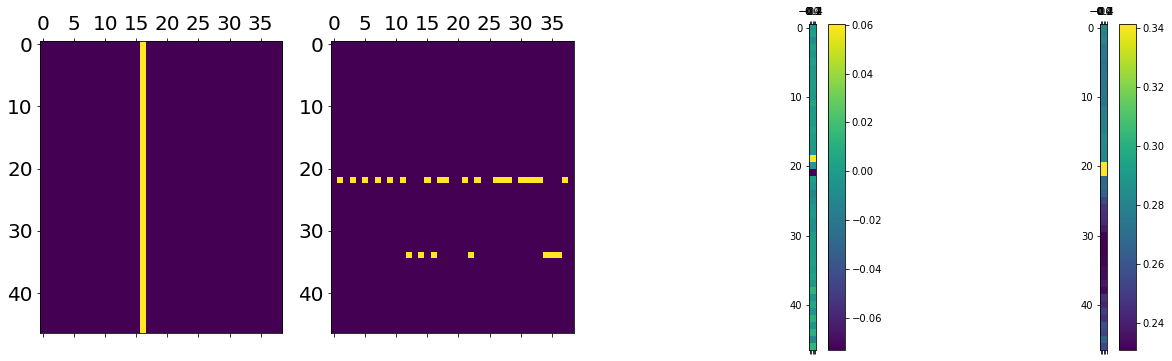

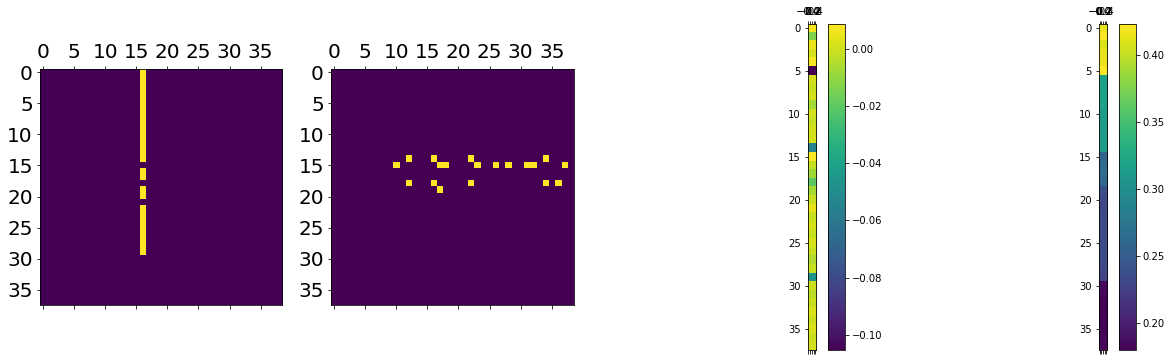

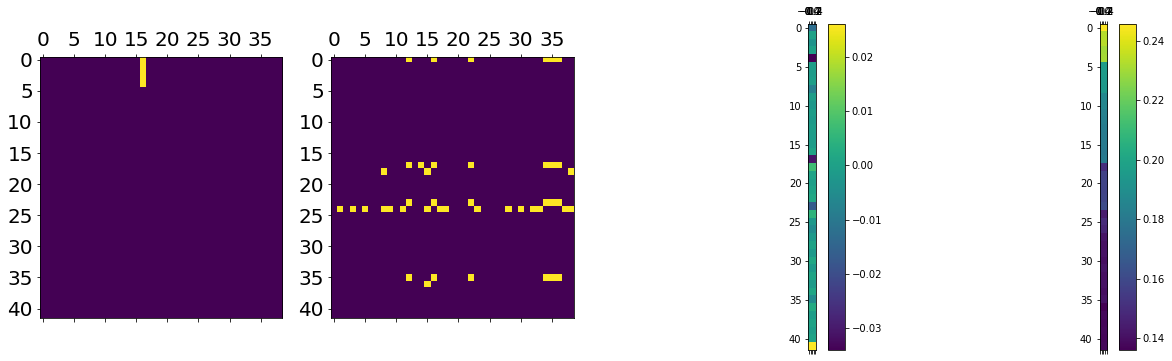

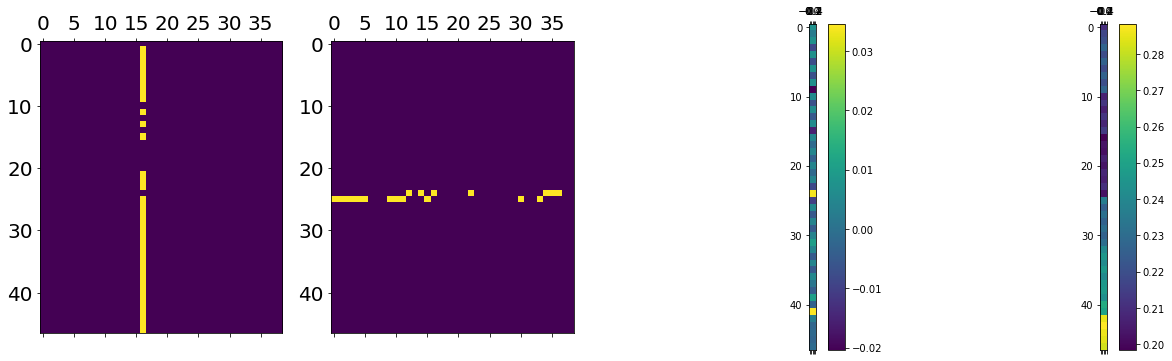

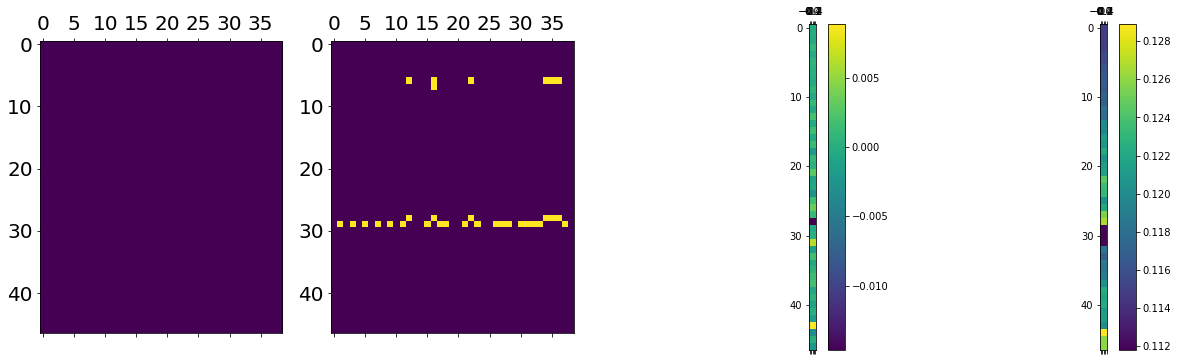

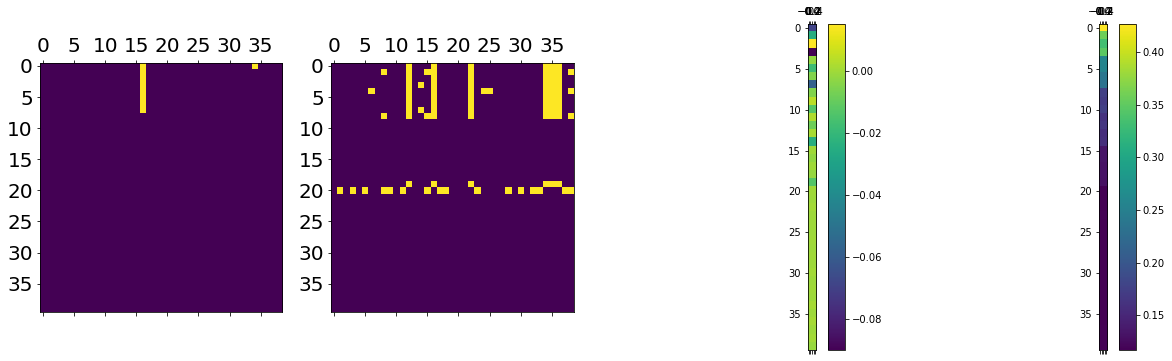

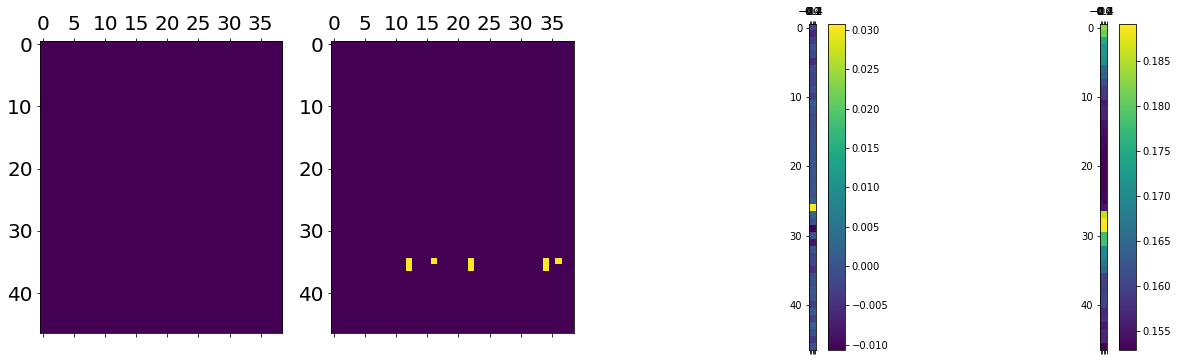

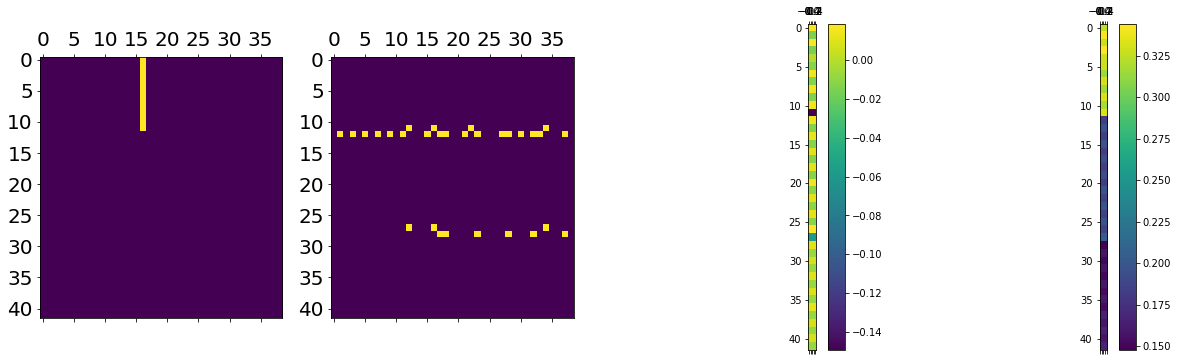

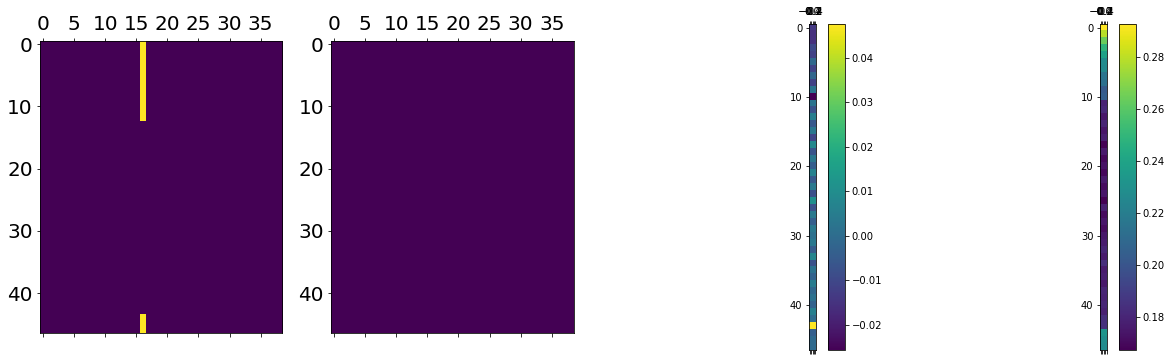

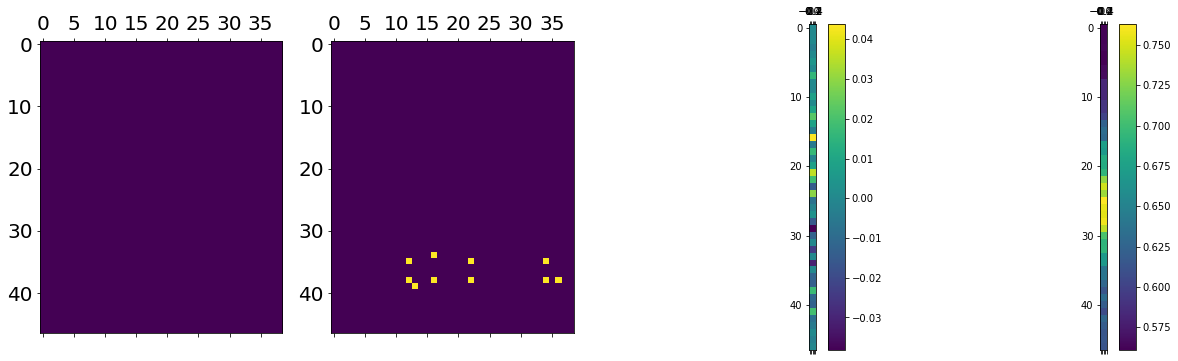

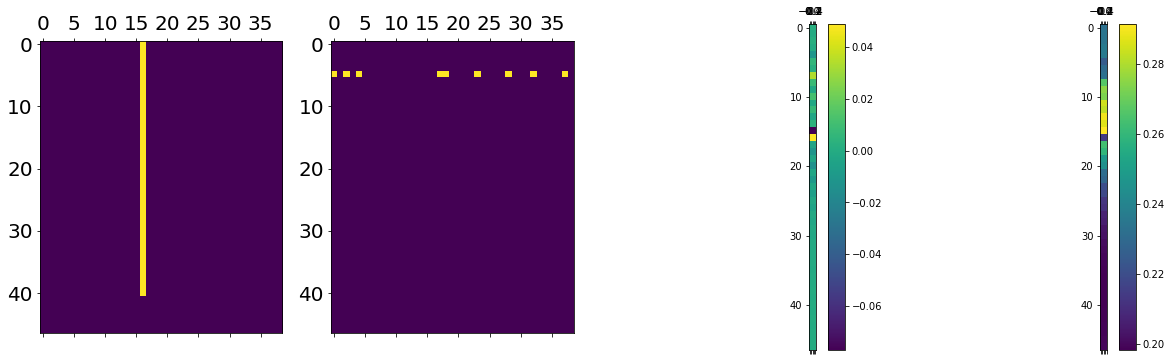

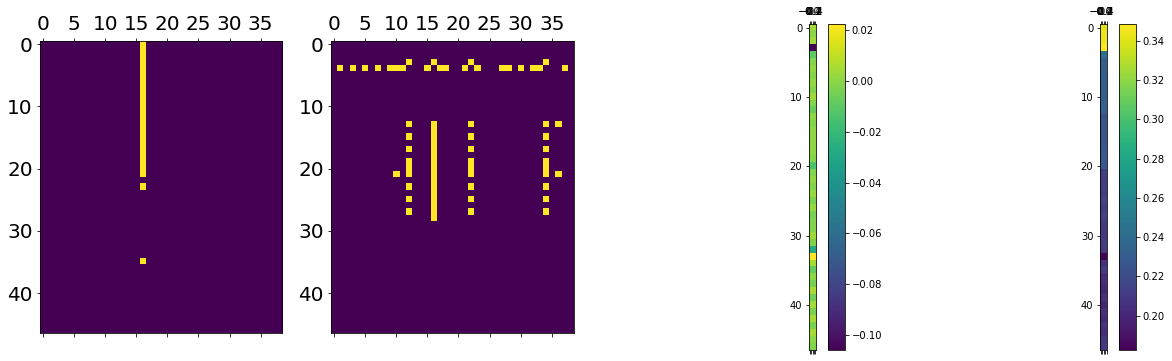

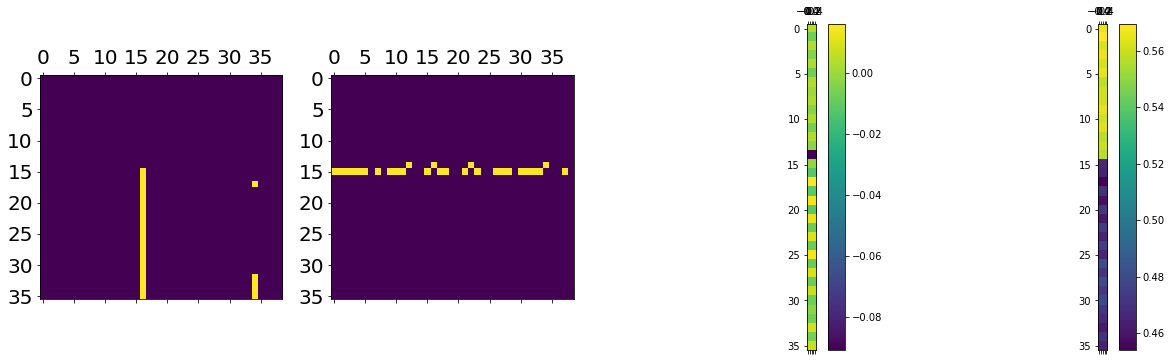

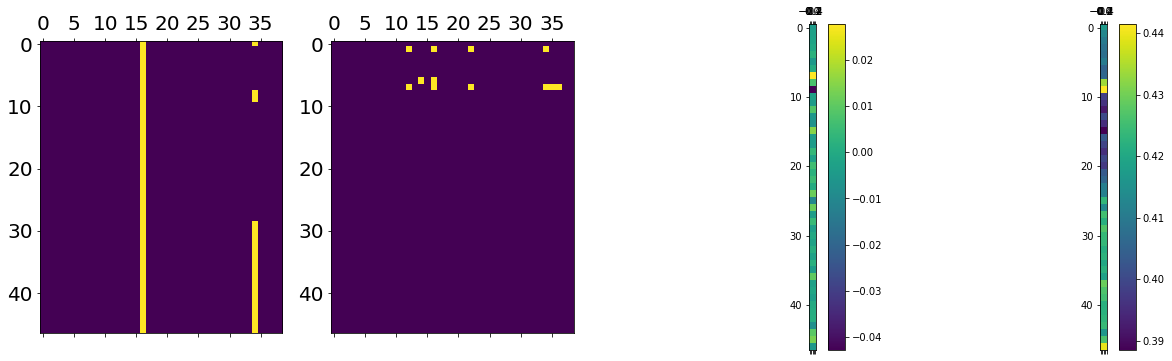

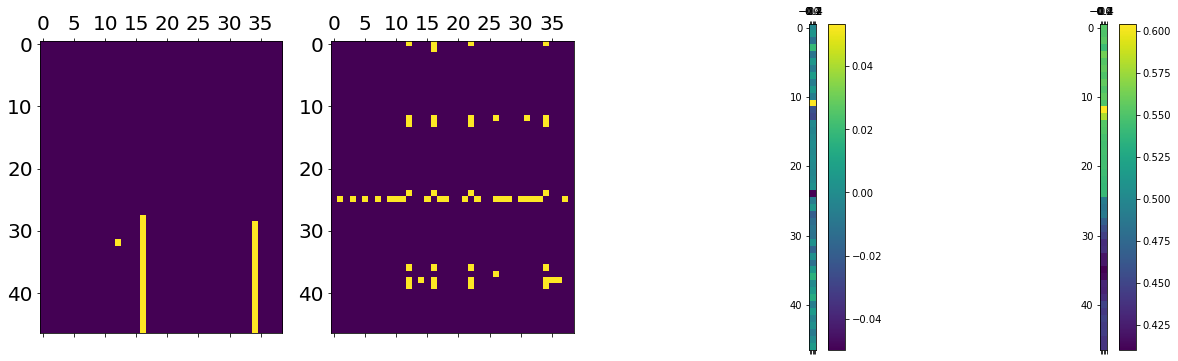

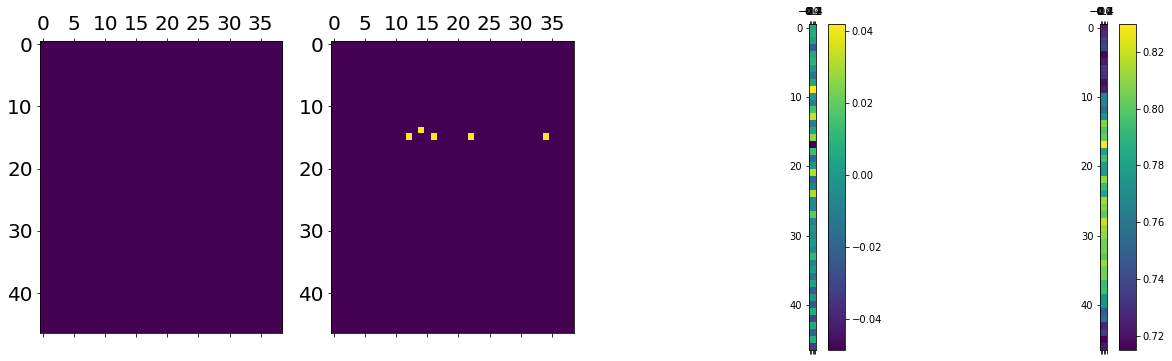

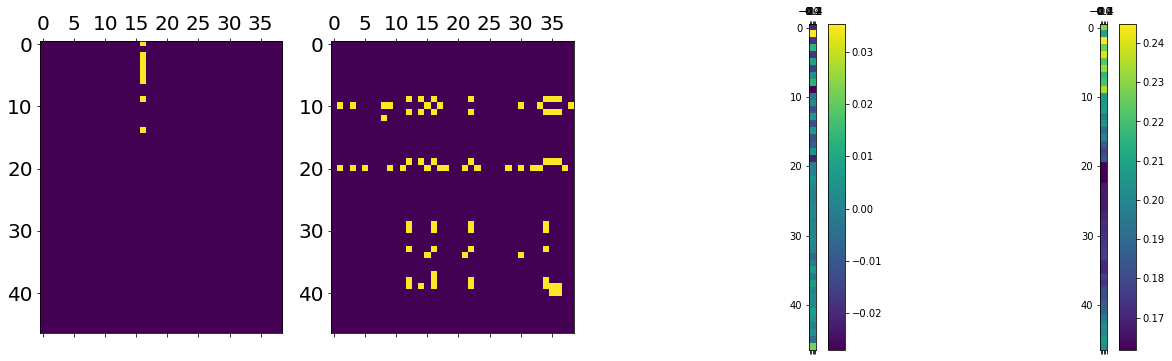

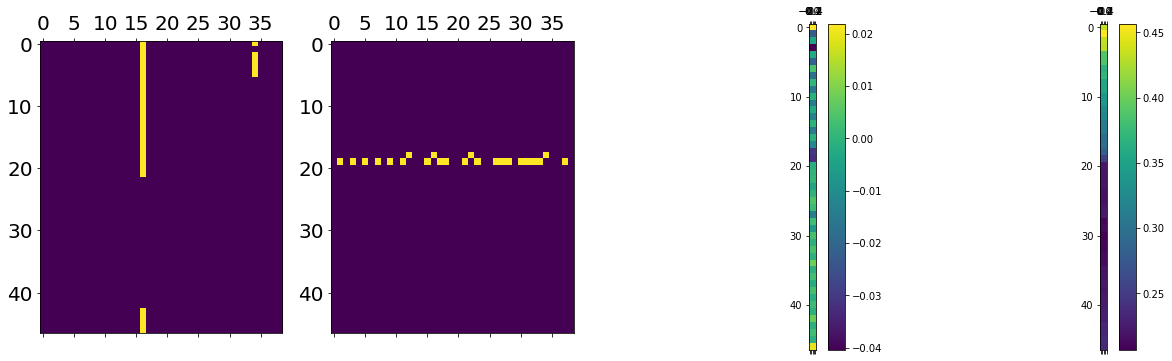

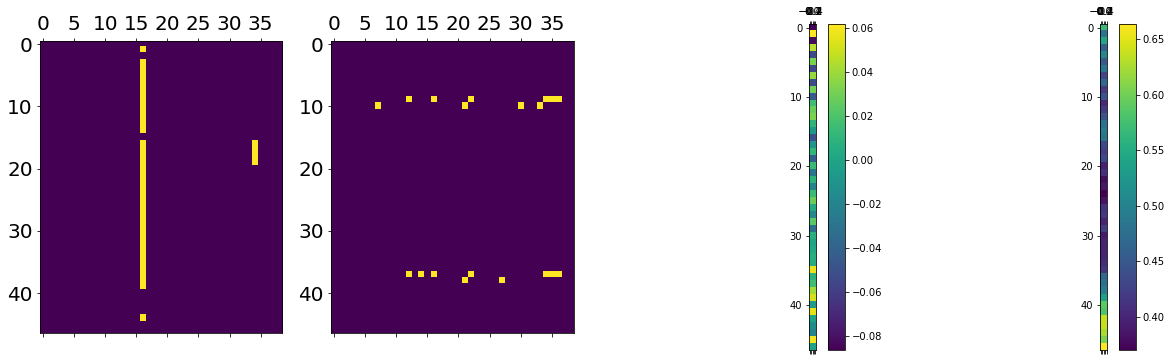

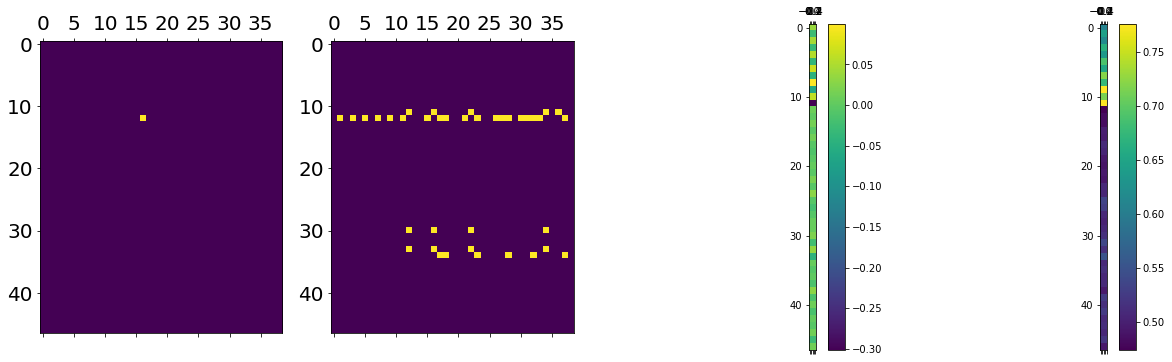

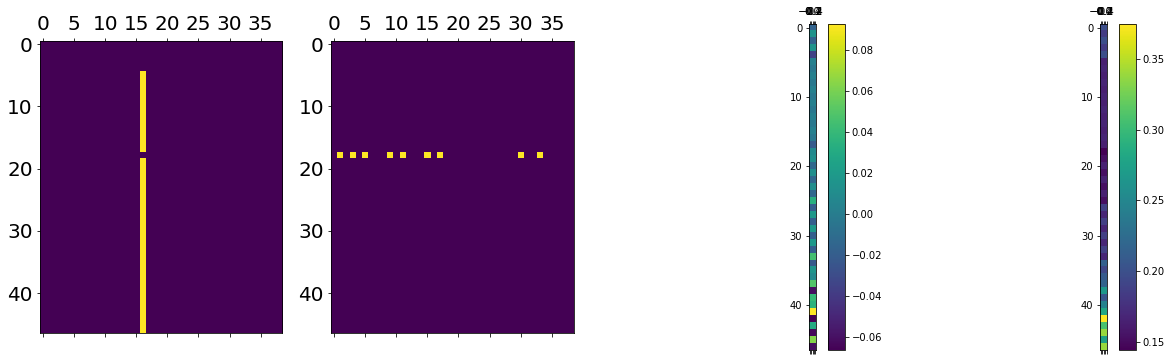

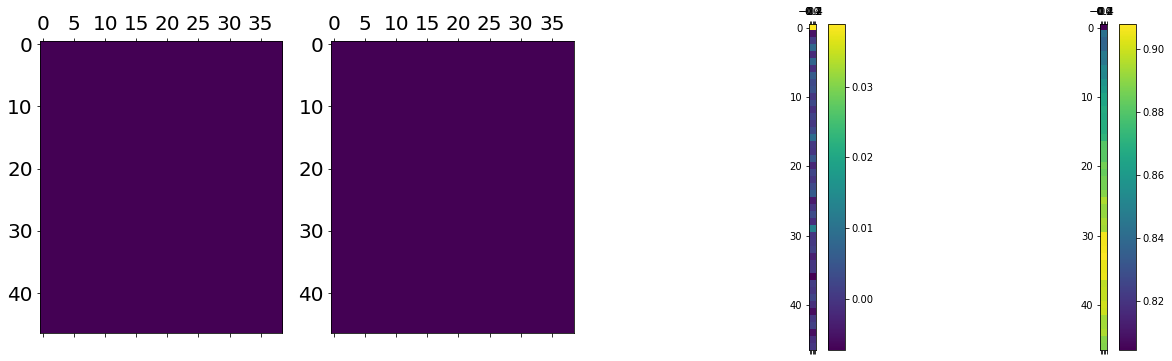

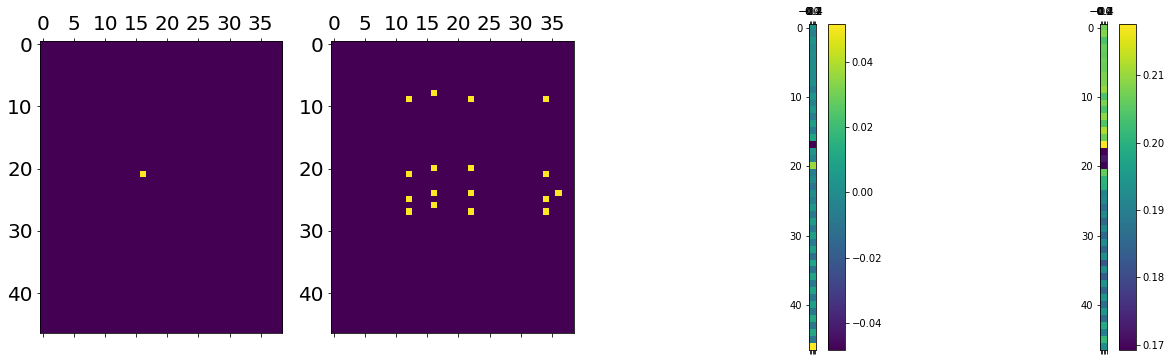

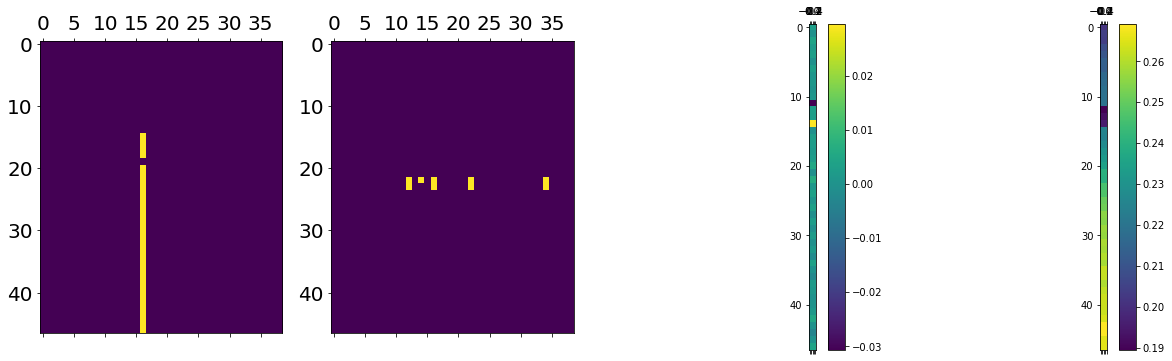

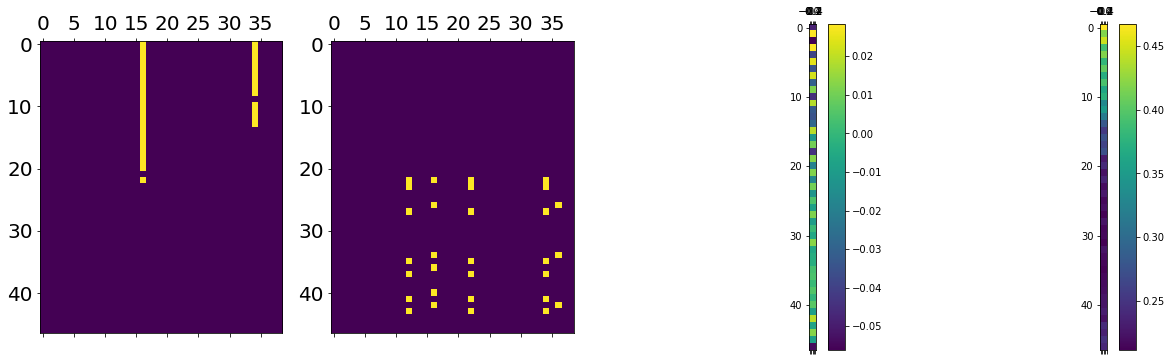

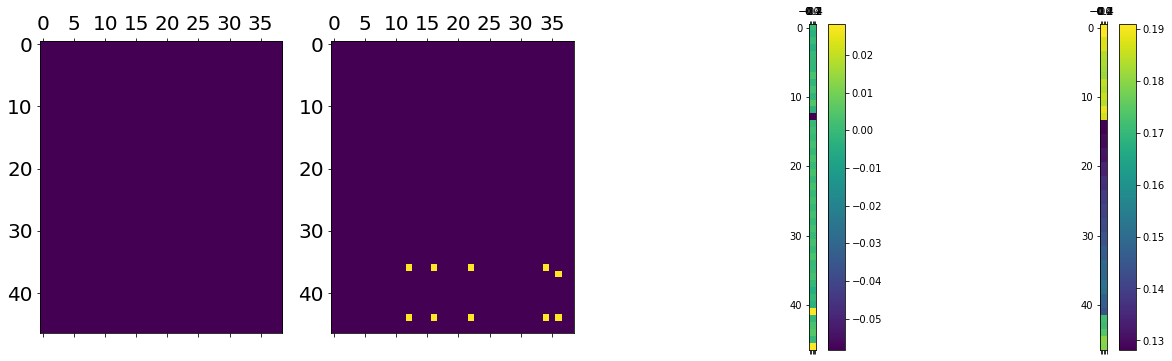

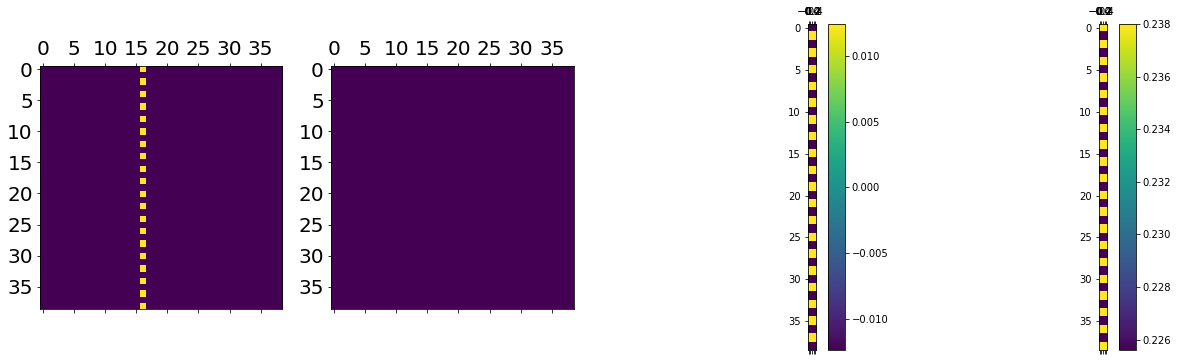

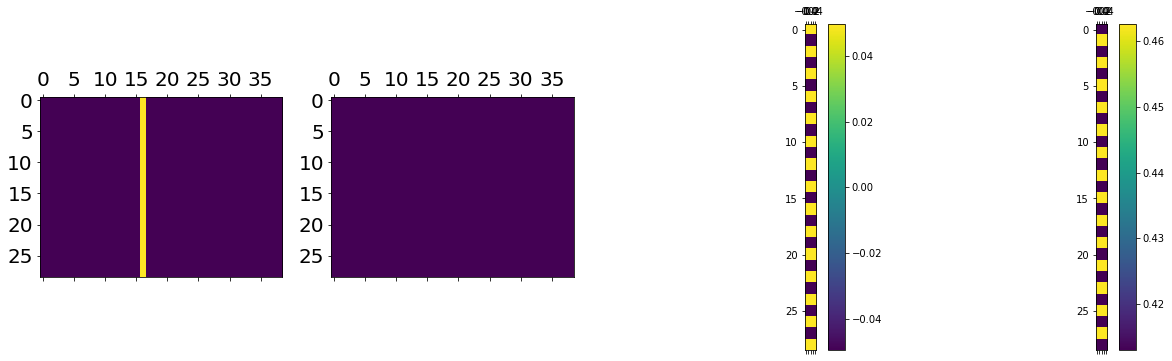

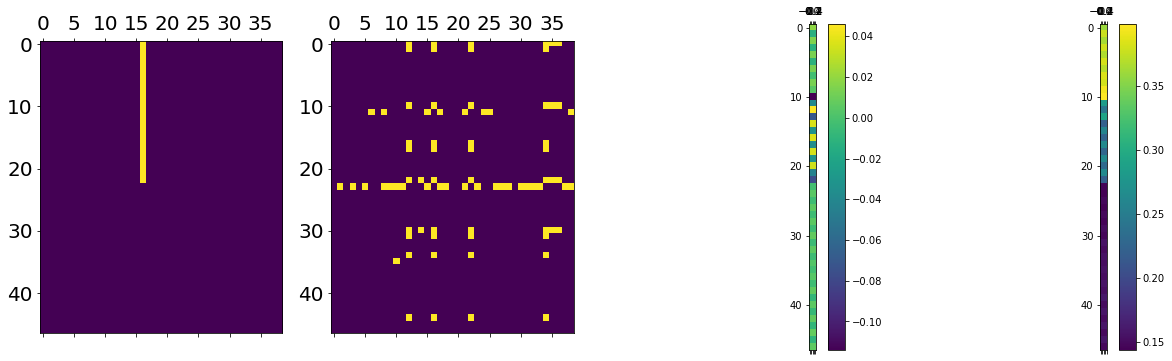

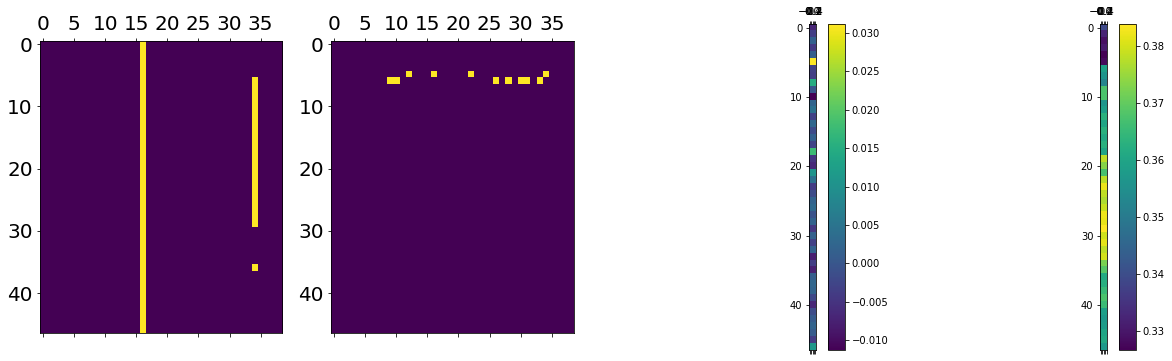

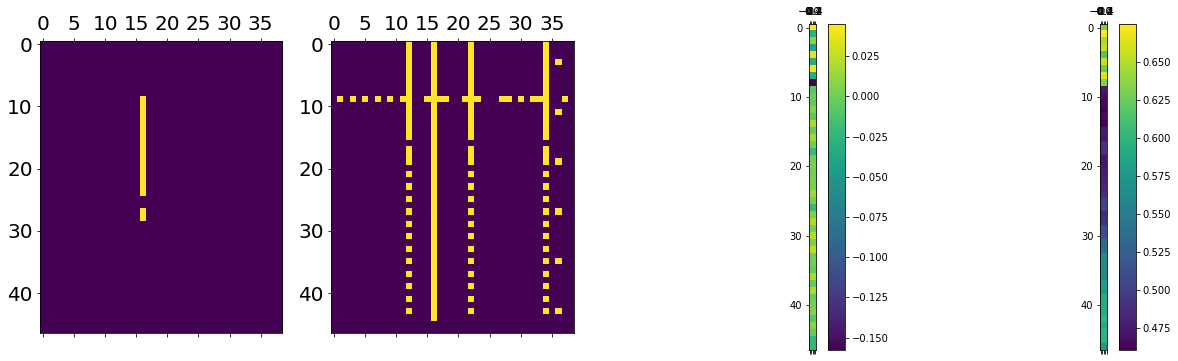

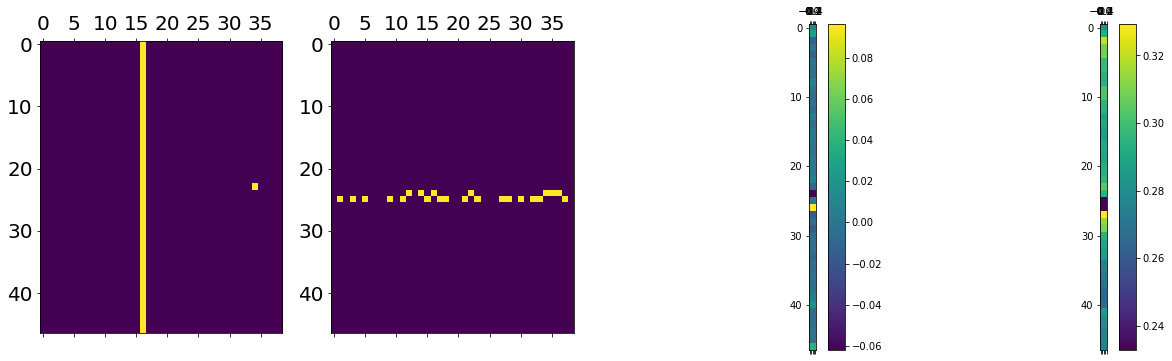

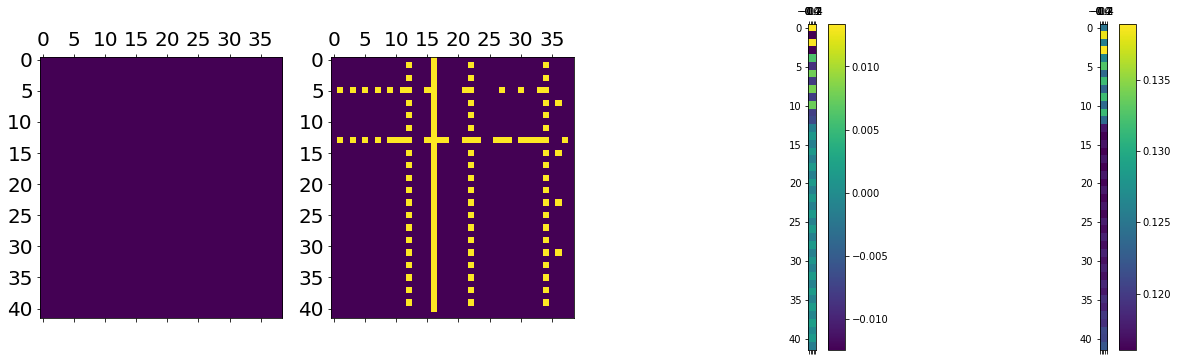

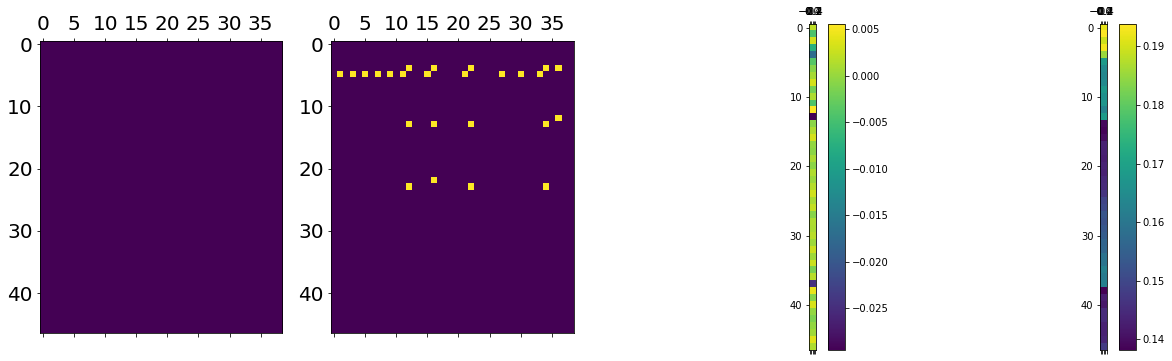

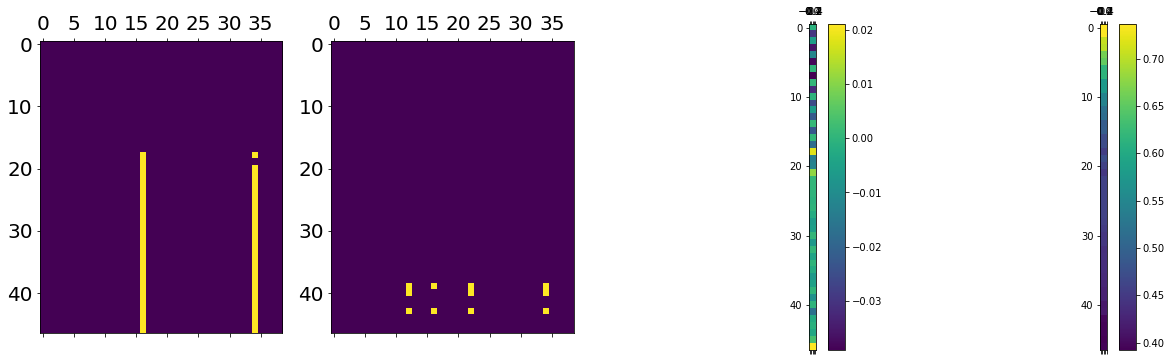

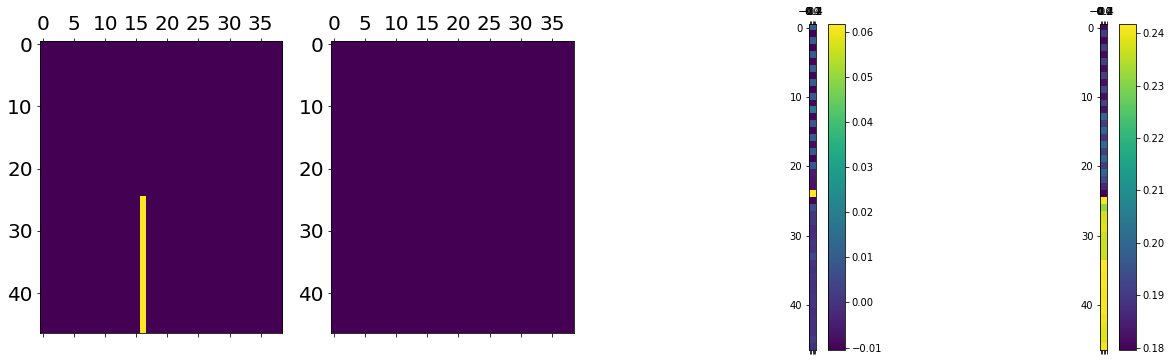

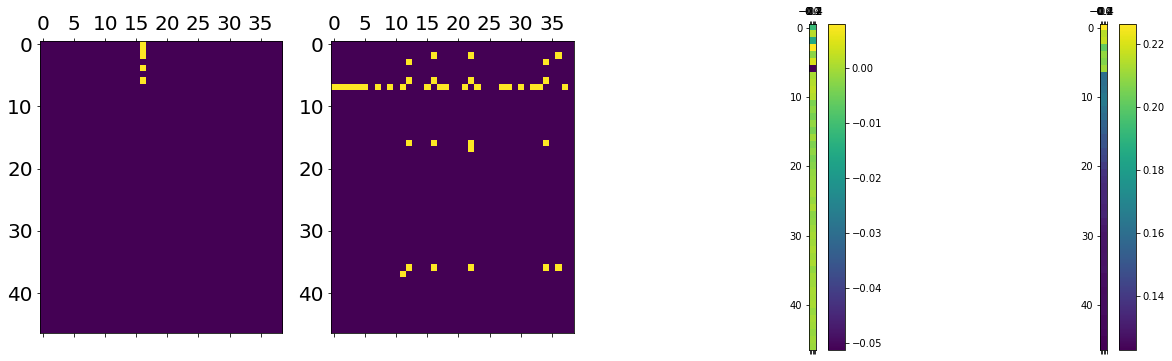

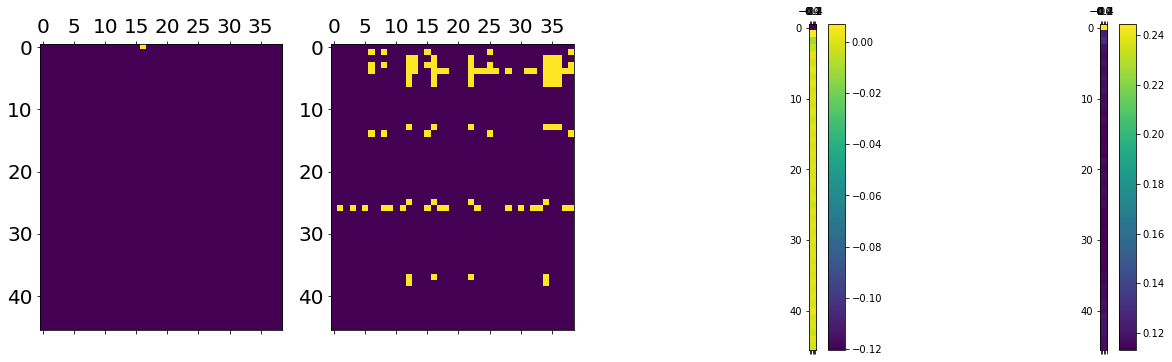

In [65]:
# visualize agent action and physician action for first n live patients
for i in range(40):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))
    # agent policy
    ax[0].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].seq_actions.values))
    # phy policy
    ax[1].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].cur_actions.values))
    # probability gain
    the_plot = ax[2].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].prob_gain.values))

    plt.colorbar(the_plot, ax=ax[2])
    # cur probability
    the_plot = ax[3].matshow(
        np.vstack(df[df.patient_inds == alive_pat_inds[i]].cur_prob.values))

    plt.colorbar(the_plot, ax=ax[3])

    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=20)

    #     plt.colorbar(the_plot, ax=ax[1])
    plt.show()

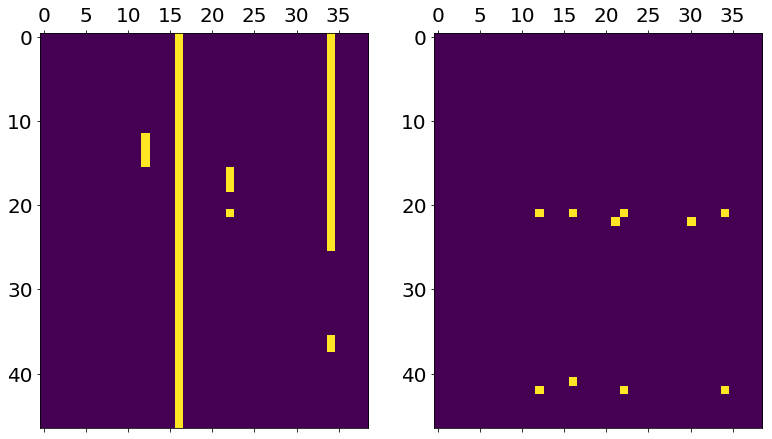

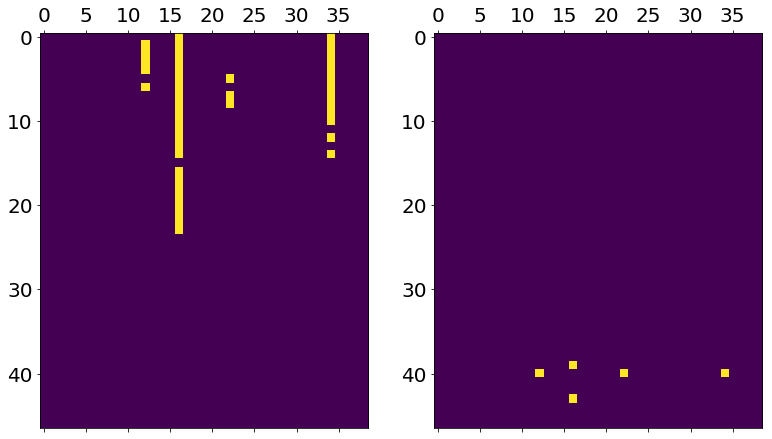

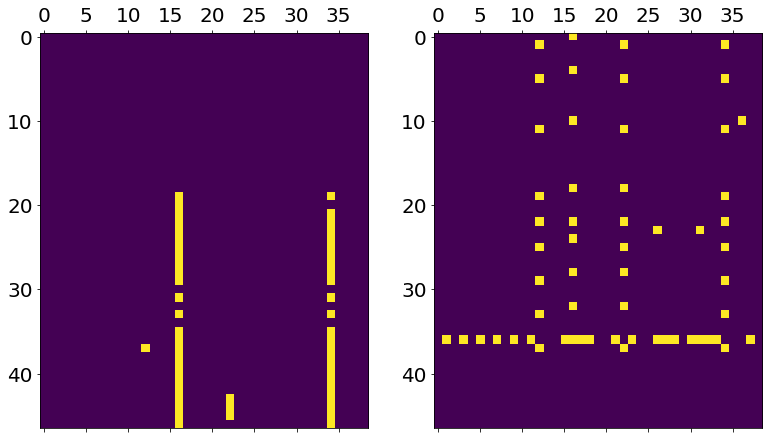

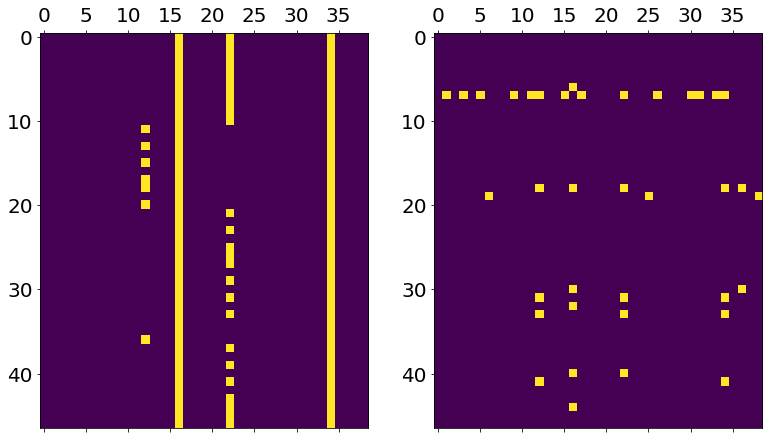

In [99]:
# visualize agent action and physician action for first n live patients
for i in range(1000):
    agent_a = np.vstack(
        df[df.patient_inds == alive_pat_inds[i]].seq_actions.values)
    phy_a = np.vstack(
        df[df.patient_inds == alive_pat_inds[i]].cur_actions.values)
    if np.sum(np.sum(agent_a, axis=0) != 0) > 3:
        fig, ax = plt.subplots(1, 2, figsize=(1.618 * 8, 8))
        ax[1].matshow(phy_a)
        ax[0].matshow(agent_a)
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=20)
        plt.show()

In [ ]:
# visualize agent action and physician action for first n live patients
for i in range(1000):
    agent_a = np.vstack(df[df.patient_inds == dead[i]].seq_actions.values)
    phy_a = np.vstack(
        df[df.patient_inds == alive_pat_inds[i]].cur_actions.values)
    if np.sum(np.sum(agent_a, axis=0) != 0) > 3:
        fig, ax = plt.subplots(1, 2, figsize=(1.618 * 8, 8))
        ax[1].matshow(phy_a)
        ax[0].matshow(agent_a)
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=20)
        plt.show()

# Visualization of policy 0118

In [51]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from arch.RewardEstimator import load_model
from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [148]:
cache_dir = '../RL_exp_cache/0117-30mins-24hrs-20order-rnn-neg_sampled/'
policy_dir = '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-64-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1'
policy_dir = '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1'
reward_estimator_dir = '../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/'
rnn_dir = "../models/0117-24hours_39feats_38cov_negsampled_rnn-mimic-nh128-nl2-c1e-07-keeprate0.9_0.7_0.5-npred24-miss1-n_mc_1-MIMIC_window-mingjie_39features_38covs-ManyToOneRNN/"

In [149]:
selected_feature_name_to_idx = pickle.load(
    open(
        '../data/in_hospital_mortality_181111/selected_feature_name_to_idx.pkl',
        'rb'))
idx_to_feature_name = {
    selected_feature_name_to_idx[k]: k
    for k in selected_feature_name_to_idx
}
idx_to_feature_name

{0: 'Anion gap',
 1: 'Bicarbonate',
 2: 'Blood urea nitrogen',
 3: 'Calcium (total)',
 4: 'Chloride (blood)',
 5: 'Creatine kinase',
 6: 'Creatinine (blood)',
 7: 'Diastolic blood pressure',
 8: 'Glascow coma scale total',
 9: 'Glucose (blood)',
 10: 'Heart Rate',
 11: 'Hematocrit',
 12: 'Hemoglobin',
 13: 'Magnesium',
 14: 'Mean blood pressure',
 15: 'Mean corpuscular hemoglobin',
 16: 'Phosphate',
 17: 'Platelets',
 18: 'Potassium',
 19: 'Prothrombin time',
 20: 'Red blood cell count (blood)',
 21: 'Sodium',
 22: 'Systolic blood pressure',
 23: 'Temperature (C)',
 24: 'White blood cell count (blood)',
 25: 'CO2 (ETCO2, PCO2, etc.)',
 26: 'Oxygen saturation',
 27: 'Partial pressure of carbon dioxide',
 28: 'Partial thromboplastin time',
 29: 'pH (blood)',
 30: 'Bilirubin (total)',
 31: 'Lactate',
 32: 'Lactic acid',
 33: 'Positive end-expiratory pressure',
 34: 'Fraction inspired oxygen',
 35: 'Calcium ionized',
 36: 'Alanine aminotransferase',
 37: 'Alkaline phosphate',
 38: 'Asparat

In [178]:
def get_agent_action_mat(policy_dir):
    # Setup the DQN
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.reset_default_graph()
    sess = tf.Session(config=config)

    dqn = SequencialDuelingDQN.load_saved_model(sess, the_dir=policy_dir)
    rew_estimator = load_model(sess, reward_estimator_dir, rnn_dir=rnn_dir)
    test_loader = rew_estimator.get_data_loader(
        mode='test', sess=sess, batch_size=1024)

    all_keys = [
        'seq_actions', 'patient_inds', 'mortality', 'the_steps', 'cur_actions',
        'prob_gain', 'labels', 'cur_prob', 'pred_agent_prob_gain',
        'pred_phy_prob_gain'
    ]
    result = []
    for idx, exp in enumerate(test_loader):
        result.append(
            dqn.get_best_sequential_actions(
                sess=sess, cur_state=exp['cur_state'])[:, :-1])
    result = np.mean(np.concatenate(result, axis=0), axis=0).reshape(3, 13)

    return result


#tmp = get_agent_action_mat('../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1')

In [189]:
policy_dirs = [
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-02-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-512-lr-0.001-reg-0.0-0.7-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-64-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-512-lr-0.001-reg-0.0-0.7-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-256-lr-1e-05-reg-0.001-0.7-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-64-lr-0.001-reg-0.0001-0.7-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-128-lr-1e-05-reg-0.0-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-64-lr-1e-05-reg-0.01-0.7-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-512-lr-0.001-reg-0.0-0.7-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-02-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-512-lr-1e-05-reg-0.01-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-512-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-256-lr-0.001-reg-0.01-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-512-lr-1e-05-reg-0.01-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-32-lr-0.0001-reg-0.01-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1',
    '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-256-lr-0.001-reg-0.01-0.5-s-256-5000-i-50-500-3-1',
]

In [190]:
num_policies = len(policy_dirs)

In [191]:
num_policies

18

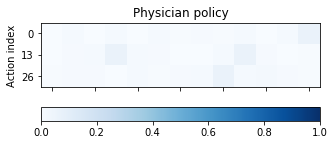

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


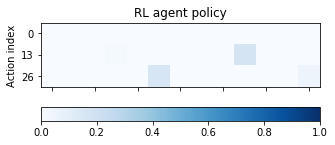

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-02-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-512-lr-0.001-reg-0.0-0.7-s-256-5000-i-50-500-3-1/model-1
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.

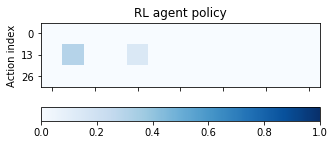

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-64-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


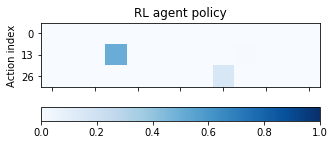

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring para

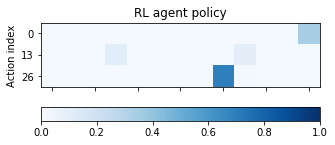

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-512-lr-0.001-reg-0.0-0.7-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.

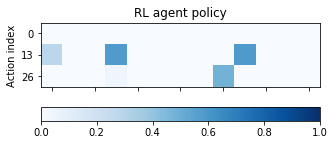

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-256-lr-1e-05-reg-0.001-0.7-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


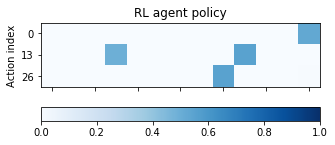

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-64-lr-0.001-reg-0.0001-0.7-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


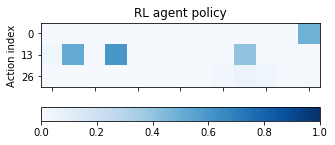

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-128-lr-1e-05-reg-0.0-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 di

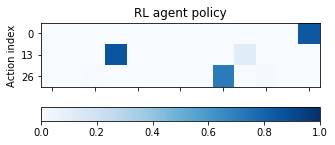

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-64-lr-1e-05-reg-0.01-0.7-s-256-5000-i-50-500-3-1/model-1
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


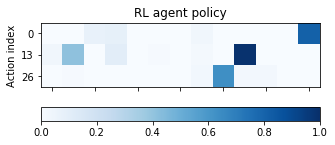

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-1-1-512-lr-0.001-reg-0.0-0.7-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.

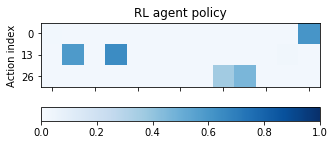

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-02-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-512-lr-1e-05-reg-0.01-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring para

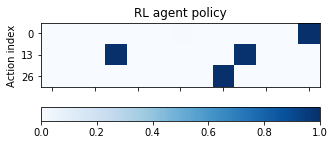

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-512-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


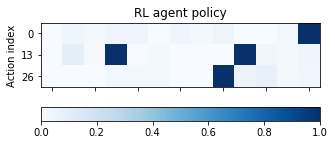

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac0.0e+00-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-256-lr-0.001-reg-0.01-0.5-s-256-5000-i-50-500-3-1/model-2
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-4-1-512-lr-1e-05-reg-0.01-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


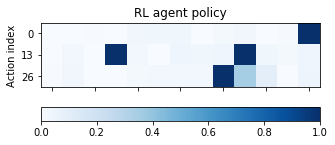

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-32-lr-0.0001-reg-0.01-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


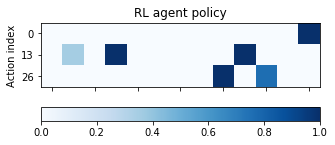

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-03-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-3-1-256-lr-1e-05-reg-0.001-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


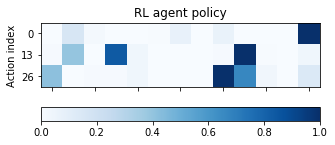

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac1.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-256-lr-0.001-reg-0.01-0.5-s-256-5000-i-50-500-3-1/model-2
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring parameters from ../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/model-3


In [196]:
fig = plt.figure(figsize=(5, 1.5 * 1.618))
#plt.subplot(str(num_policies + 1) + '11')
plt.title('Physician policy')
plt.imshow(
    np.mean(action_mat_all_phy, axis=0).reshape(3, 13), cmap=plt.cm.Blues)
plt.colorbar(orientation='horizontal')
plt.ylabel('Action index')
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([0, 0, 13, 26])
plt.clim(0, 1)
plt.show()
fig.savefig('action_mat/phy_policy.pdf', bbox_inches='tight', dpi=300)

for i in range(num_policies):
    fig = plt.figure(figsize=(5, 1.5 * 1.618))
    #plt.subplot(str(num_policies + 1) + '1' + str(i + 2))
    plt.title('RL agent policy')
    plt.imshow(get_agent_action_mat(policy_dirs[i]), cmap=plt.cm.Blues)
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Action index')

    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([0, 0, 13, 26])
    plt.clim(0, 1)
    plt.show()
    fig.savefig(
        f'action_mat/agent_policy{i}.pdf', bbox_inches='tight', dpi=300)

# 0123 - Find policy illustration for patient trajectory

In [1]:
import argparse
import json
import os
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from arch.simple_neural_network import NNRegressor
from arch.RewardEstimator import load_model
from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from database.MIMIC_cache_exp import MIMIC_cache_discretized_joint_exp_random_order, MIMIC_cache_discretized_exp_env_v3

In [2]:
selected_feature_name_to_idx = pickle.load(
    open(
        '../data/in_hospital_mortality_181111/selected_feature_name_to_idx.pkl',
        'rb'))
idx_to_feature_name = {
    selected_feature_name_to_idx[k]: k
    for k in selected_feature_name_to_idx
}

In [3]:
cache_dir = '../RL_exp_cache/0117-30mins-24hrs-20order-rnn-neg_sampled/'
reward_estimator_dir = '../models/0121_with_larger_training_-StateToProbGainPerTimeEstimator-0121-hl1-hu64-lr0.001-reg0.0001-kp0.7-n1/'
rnn_dir = "../models/0117-24hours_39feats_38cov_negsampled_rnn-mimic-nh128-nl2-c1e-07-keeprate0.9_0.7_0.5-npred24-miss1-n_mc_1-MIMIC_window-mingjie_39features_38covs-ManyToOneRNN/"
policy_dir = '../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1'

# Setup the DQN
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.reset_default_graph()
sess = tf.Session(config=config)

dqn = SequencialDuelingDQN.load_saved_model(sess, the_dir=policy_dir)
rew_estimator = load_model(sess, reward_estimator_dir, rnn_dir=rnn_dir)
test_loader = rew_estimator.get_data_loader(
    mode='test', sess=sess, batch_size=1024)

Normalize the state for the first 128 dim with total 167 dim
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../models/dqn_mimic-0120_24hrs_rand_ac_and_arch_-g1-ac5.0e-04-gamma0.95-fold1.0-only_pos0-sd167-ad40-nn-10000-2-1-128-lr-0.0001-reg-0.0-0.5-s-256-5000-i-50-500-3-1/model-0
Normalize the input for the first 128 dim with total 167 dim
Find results.json ... The best model idx is 3
INFO:tensorflow:Restoring para

In [4]:
# collect key value from test experience
# next(test_loader).keys()
# dict_keys(['cur_state', 'next_state', 'cur_obs', 'next_obs', 'cur_actions', 'next_actions',
# 'prob_gain', 'cur_prob', 'next_prob', 'labels', 'patient_inds', 'the_steps', 'total_steps', 'mortality'])
all_keys = [
    'seq_actions', 'patient_inds', 'mortality', 'the_steps', 'cur_actions',
    'prob_gain', 'labels', 'cur_prob', 'pred_agent_prob_gain',
    'pred_phy_prob_gain'
]
result = {k: [] for k in all_keys}
for idx, exp in enumerate(test_loader):
    exp['seq_actions'] = dqn.get_best_sequential_actions(
        sess=sess, cur_state=exp['cur_state'])[:, :-1]
    exp['pred_agent_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp, agent_a=exp['seq_actions'])
    exp['pred_phy_prob_gain'] = rew_estimator.get_predicted_prob_gain(
        sess, exp)
    for k in all_keys:
        result[k].append(exp[k])

for k in all_keys:
    result[k] = np.concatenate(result[k], axis=0)
    if result[k].ndim > 1:
        result[k] = result[k].tolist()
df = pd.DataFrame(result)
df.shape

(272575, 10)

In [5]:
action_mat_all = np.vstack(df.seq_actions)
{
    idx_to_feature_name[idx]: val
    for idx, val in enumerate(np.mean(action_mat_all, axis=0))
}

{'Anion gap': 0.012304870219205724,
 'Bicarbonate': 0.012304870219205724,
 'Blood urea nitrogen': 0.012304870219205724,
 'Calcium (total)': 0.012304870219205724,
 'Chloride (blood)': 0.012304870219205724,
 'Creatine kinase': 0.013196367972117765,
 'Creatinine (blood)': 0.015537008162890947,
 'Diastolic blood pressure': 0.01449509309364395,
 'Glascow coma scale total': 0.01547097129230487,
 'Glucose (blood)': 0.012304870219205724,
 'Heart Rate': 0.012304870219205724,
 'Hematocrit': 0.012304870219205724,
 'Hemoglobin': 0.34459139686324863,
 'Magnesium': 0.012304870219205724,
 'Mean blood pressure': 0.012359900944694122,
 'Mean corpuscular hemoglobin': 0.012304870219205724,
 'Phosphate': 0.10719985325139869,
 'Platelets': 0.012304870219205724,
 'Potassium': 0.012304870219205724,
 'Prothrombin time': 0.014454737228285794,
 'Red blood cell count (blood)': 0.012304870219205724,
 'Sodium': 0.012304870219205724,
 'Systolic blood pressure': 0.09981106117582317,
 'Temperature (C)': 0.01230487021

In [24]:
tmp_df = df[df.patient_inds == pat_inds[26]]
np.vstack(tmp_df.seq_actions.values)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

4789


11695


11771


25122


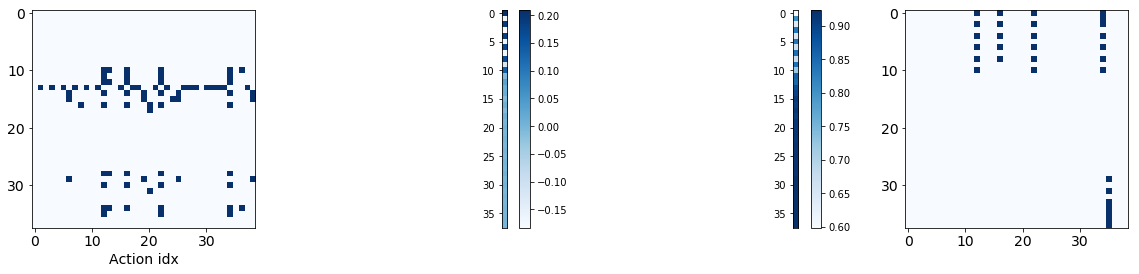

28065


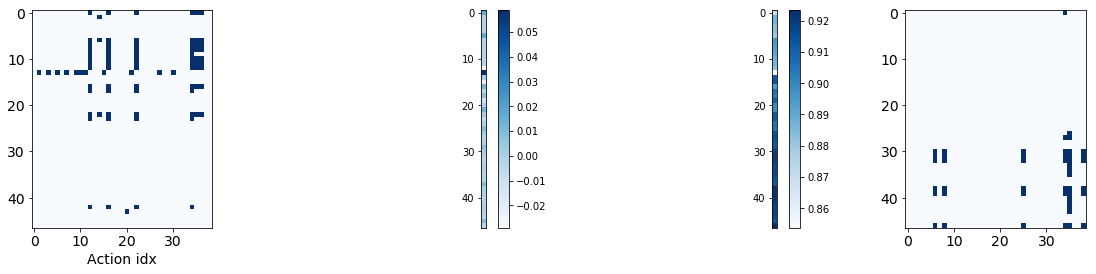

In [66]:
pat_inds = df.patient_inds.unique()
# visualize agent action and physician action for first n patient
for i in range(5000):
    tmp_df = df[df.patient_inds == pat_inds[i]]
    agent_a = np.vstack(tmp_df.seq_actions.values)
    phy_a = np.vstack(tmp_df.cur_actions.values)
    
    agent_freq_0 = np.sum(np.sum(agent_a, axis=0) != 0)
    agent_freq_1 = np.sum(np.sum(agent_a, axis=1) != 0)
    phy_freq_0 = np.sum(np.sum(phy_a, axis=0) != 0)
    phy_freq_1 = np.sum(np.sum(phy_a, axis=1) != 0)
    
    if  agent_freq_0 > 4 and agent_freq_0 < 10 and phy_freq_1 > 5 and agent_freq_1 < 20:
        print(pat_inds[i])
        fig, ax = plt.subplots(1, 4, figsize=(20, 4))
        ax[0].imshow(phy_a, cmap=plt.cm.Blues)
        ax[0].tick_params(axis='both', which='major', labelsize=14)
        ax[0].set_xlabel('Action idx', fontsize=14)
        ax[0].set_xlabel('Action idx', fontsize=14)
        
        ax[3].imshow(agent_a, cmap=plt.cm.Blues)
        ax[3].tick_params(axis='both', which='major', labelsize=14)
        

        # probability gain
        the_plot = ax[1].imshow(np.vstack(tmp_df.prob_gain.values), cmap=plt.cm.Blues)
        plt.colorbar(the_plot, ax=ax[1])#, fraction=0.08, pad=0.04)
        ax[1].set_xticks([], [])
        # cur probability
        the_plot = ax[2].imshow(np.vstack(tmp_df.cur_prob.values), cmap=plt.cm.Blues)
        plt.colorbar(the_plot, ax=ax[2])#, fraction=0.08, pad=0.04)
        ax[2].set_xticks([], [])
        plt.show()

4789


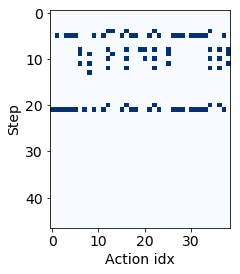

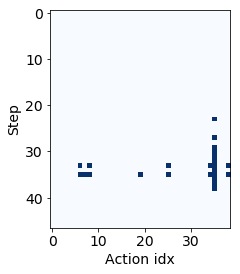

11771


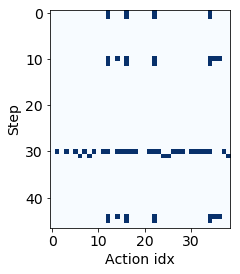

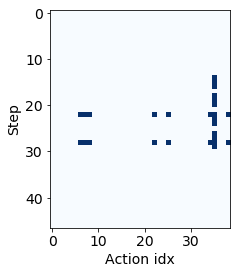

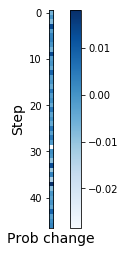

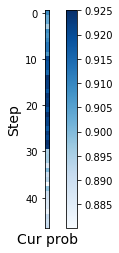

28065


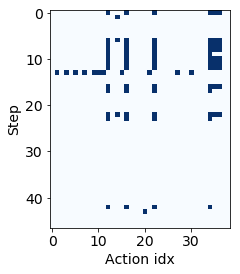

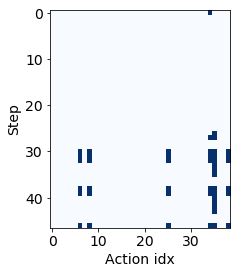

In [72]:
pat_inds = [4789, 11771, 28065]
# visualize agent action and physician action for first n patient
for i in range(len(pat_inds)):
    tmp_df = df[df.patient_inds == pat_inds[i]]
    agent_a = np.vstack(tmp_df.seq_actions.values)
    phy_a = np.vstack(tmp_df.cur_actions.values)
    
    print(pat_inds[i])
    fig = plt.figure()
    plt.imshow(phy_a, cmap=plt.cm.Blues)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Action idx', fontsize=14)
    plt.ylabel('Step', fontsize=14)
    plt.show()
    fig.savefig(f'./paper_190123/policy_{i}_0.pdf', bbox_inches='tight', dpi=300)

    fig = plt.figure()
    plt.imshow(agent_a, cmap=plt.cm.Blues)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Action idx', fontsize=14)
    plt.ylabel('Step', fontsize=14)
    plt.show()
    fig.savefig(f'./paper_190123/policy_{i}_1.pdf', bbox_inches='tight', dpi=300)
    
    # probability gain
    fig = plt.figure()
    the_plot = plt.imshow(np.vstack(tmp_df.prob_gain.values), cmap=plt.cm.Blues)
    plt.ylabel('Step', fontsize=14)
    plt.xlabel('Prob change', fontsize=14)
    plt.colorbar()#, fraction=0.08, pad=0.04)
    plt.xticks([], [])
    plt.show()
    fig.savefig(f'./paper_190123/policy_{i}_2.pdf', bbox_inches='tight', dpi=300)
    
    # cur probability
    fig = plt.figure()
    the_plot = plt.imshow(np.vstack(tmp_df.cur_prob.values), cmap=plt.cm.Blues)
    plt.colorbar()#, fraction=0.08, pad=0.04)
    plt.xticks([], [])
    plt.ylabel('Step', fontsize=14)
    plt.xlabel('Cur prob', fontsize=14)
    plt.show()
    fig.savefig(f'./paper_190123/policy_{i}_3.pdf', bbox_inches='tight', dpi=300)